# 1. Introduction


In [1]:
import pandas as pd
import numpy as np
import scipy as sp
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as pyplt
%matplotlib inline
import keras as ks
import sklearn.preprocessing as pre
import sklearn.model_selection as mod
import sklearn.decomposition as dec
from sklearn.utils import shuffle
from sklearn.datasets import load_boston
boston = load_boston()

Using TensorFlow backend.
c:\users\conor\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\conor\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\conor\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\users\conor\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

In [2]:
#df = pd.DataFrame(boston.data, columns=boston.feature_names)
#df['target'] = boston.target

In [3]:
df = pd.DataFrame(boston.data)
df['Median_Value'] = boston.target

In [4]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,Median_Value
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


### About the Dataset

This dataset was created from data taken from the 1970 United States census and other sources and used in a paper investigating the willingness of people to pay more for clean air in the Boston housing market. 

Harrison, D. and Rubinfeld, D. (1978). Hedonic housing prices and the demand for clean air. Journal of Environmental Economics and Management, 5(1), pp.81-102.

The scikit learn source includes a description file that can be printed to learn more about the dataset and it's features:

In [5]:
print(boston.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

However, I found the above descriptions the datasets attributes to be unclear so I read the original source paper to get more detail. My updated decscriptions are included below are based on Table IV in the source paper.

|Orginal Attribute Name|New Name|Description|Assumed Relationship to Housing Values|
|:------------------------|:---------|:-----------|:------------------------------|
|CRIM|Crime_Rate|Crime rate by town|Negative|
|ZN|%_Large_Plots|Proportion of residential land zoned for large plots|Postive|
|INDUS|%_Indus|Proportion of land zoned for industrial use|Negative|
|CHAS|By_River|Boolean value for whether the land borders the Charles River|Positive|
|NOX|NOX|Nitrogen oxide concentrations in the air|Negative|
|RM|Rooms|Average number of rooms in houses|Positive|
|AGE|%_Pre_1940|Proporation of houses constructed before 1940. Older housing is of good quality in Boston|Positive|
|DIS|Dist_to_Jobs|Weighted distance to places of employment|Positive|
|RAD|Highway_Access|Index of accessabilty to highways|Positive|
|TAX|Tax|Property Tax rate in the area|Negative|
|PTRATIO|PTRatio|Pupil-Teacher ration in the area. Higher values mean more students per teacher|Negative|
|B|Blks_per_1000|Proportion of the population that are black. Regarded as undisirable by Whites|Negative|
|LSTAT|%_Lower_Status|Proportion of adults without a high school education or male laborers|Negative|

### Adding more readable column names

In [6]:
#setting columns names
df.columns = ["Crime_Rate", "%_Large_Plots", "%_Indus", "By_River", "NOX", "Rooms", "%_Pre_1940", "Dist_to_Jobs", "Highway_Access", "Tax", "PTRatio", "Blks_per_1000", "%_Lower_Status", "Median_Val"]

In [7]:
#checking the new column names line up 
df.head()

,Crime_Rate,%_Large_Plots,%_Indus,By_River,NOX,Rooms,%_Pre_1940,Dist_to_Jobs,Highway_Access,Tax,PTRatio,Blks_per_1000,%_Lower_Status,Median_Val
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [8]:
df.tail()

,Crime_Rate,%_Large_Plots,%_Indus,By_River,NOX,Rooms,%_Pre_1940,Dist_to_Jobs,Highway_Access,Tax,PTRatio,Blks_per_1000,%_Lower_Status,Median_Val
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48,22.0
505,0.04741,0.0,11.93,0.0,0.573,6.030,80.8,2.5050,1.0,273.0,21.0,396.90,7.88,11.9


In [9]:
df.columns

Index(['Crime_Rate', '%_Large_Plots', '%_Indus', 'By_River', 'NOX', 'Rooms',
       '%_Pre_1940', 'Dist_to_Jobs', 'Highway_Access', 'Tax', 'PTRatio',
       'Blks_per_1000', '%_Lower_Status', 'Median_Val'],
      dtype='object')

# 2. Descriptive Analysis

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
Crime_Rate        506 non-null float64
%_Large_Plots     506 non-null float64
%_Indus           506 non-null float64
By_River          506 non-null float64
NOX               506 non-null float64
Rooms             506 non-null float64
%_Pre_1940        506 non-null float64
Dist_to_Jobs      506 non-null float64
Highway_Access    506 non-null float64
Tax               506 non-null float64
PTRatio           506 non-null float64
Blks_per_1000     506 non-null float64
%_Lower_Status    506 non-null float64
Median_Val        506 non-null float64
dtypes: float64(14)
memory usage: 55.5 KB


#### Distribution of values

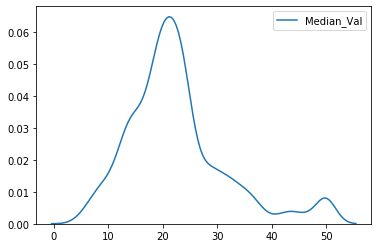

In [11]:
sns.kdeplot(df['Median_Val'])

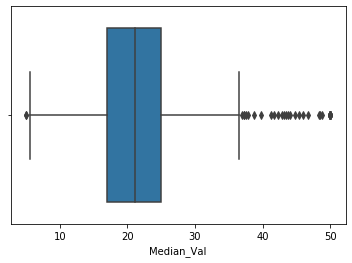

In [12]:
sns.boxplot(df['Median_Val'])

In [13]:
df.describe()

,Crime_Rate,%_Large_Plots,%_Indus,By_River,NOX,Rooms,%_Pre_1940,Dist_to_Jobs,Highway_Access,Tax,PTRatio,Blks_per_1000,%_Lower_Status,Median_Val
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


There are lots of outliers in the upper range of values

### Note look at this article 
https://www.ritchieng.com/machine-learning-project-boston-home-prices/

Good examples of data exoplorations and statistics on pricing 
And linear regression later on.

Creating a corrolation matrix to see if there is any relationship betweek the variables.

In [14]:
corr_matrix = df.corr().round(2)
corr_matrix.style.background_gradient(cmap='coolwarm')

,Crime_Rate,%_Large_Plots,%_Indus,By_River,NOX,Rooms,%_Pre_1940,Dist_to_Jobs,Highway_Access,Tax,PTRatio,Blks_per_1000,%_Lower_Status,Median_Val
Crime_Rate,1,-0.2,0.41,-0.06,0.42,-0.22,0.35,-0.38,0.63,0.58,0.29,-0.39,0.46,-0.39
%_Large_Plots,-0.2,1,-0.53,-0.04,-0.52,0.31,-0.57,0.66,-0.31,-0.31,-0.39,0.18,-0.41,0.36
%_Indus,0.41,-0.53,1,0.06,0.76,-0.39,0.64,-0.71,0.6,0.72,0.38,-0.36,0.6,-0.48
By_River,-0.06,-0.04,0.06,1,0.09,0.09,0.09,-0.1,-0.01,-0.04,-0.12,0.05,-0.05,0.18
NOX,0.42,-0.52,0.76,0.09,1,-0.3,0.73,-0.77,0.61,0.67,0.19,-0.38,0.59,-0.43
Rooms,-0.22,0.31,-0.39,0.09,-0.3,1,-0.24,0.21,-0.21,-0.29,-0.36,0.13,-0.61,0.7
%_Pre_1940,0.35,-0.57,0.64,0.09,0.73,-0.24,1,-0.75,0.46,0.51,0.26,-0.27,0.6,-0.38
Dist_to_Jobs,-0.38,0.66,-0.71,-0.1,-0.77,0.21,-0.75,1,-0.49,-0.53,-0.23,0.29,-0.5,0.25
Highway_Access,0.63,-0.31,0.6,-0.01,0.61,-0.21,0.46,-0.49,1,0.91,0.46,-0.44,0.49,-0.38
Tax,0.58,-0.31,0.72,-0.04,0.67,-0.29,0.51,-0.53,0.91,1,0.46,-0.44,0.54,-0.47


In [15]:
median_val_corr = corr_matrix.iloc[-1]
median_val_corr.sort_values(ascending=True)

%_Lower_Status   -0.74
PTRatio          -0.51
%_Indus          -0.48
Tax              -0.47
NOX              -0.43
Crime_Rate       -0.39
%_Pre_1940       -0.38
Highway_Access   -0.38
By_River          0.18
Dist_to_Jobs      0.25
Blks_per_1000     0.33
%_Large_Plots     0.36
Rooms             0.70
Median_Val        1.00
Name: Median_Val, dtype: float64

The average number of Rooms per House (0.7) and the % of People of Lower Status (-0.74) are the mostly strongly corrolated with the Median Value of houses

Also, worth noting the high corrolation between NOX and industrialisation (0.76) , Tax and Access to Highways (0.91)

### Corrolation and Sensitivity to different variables

1. Benefit of less NOX drops when DIS and RAD are removed. This is because the advantages of greater accessability cancel out the disadvantages of less clean air. 
2. The affect of higher NOX levels can easily be attributed to a higher proportion of lower status households. 
3. In general there is a high degree of heteroscedasticity. As X increases there is a larger variance in Y. 

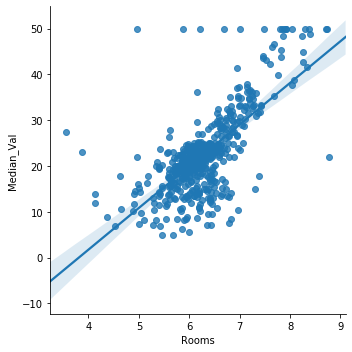

In [16]:
sns.lmplot(x="Rooms", y="Median_Val", data=df)

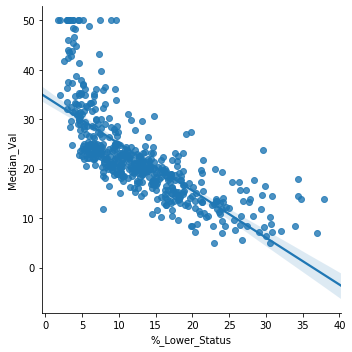

In [17]:
sns.lmplot(x="%_Lower_Status", y="Median_Val", data=df)

Looking at 2 next most closely corrolated attributes: Crime rate and Pupil teacher ratio shows there is a far less obvious relationship.

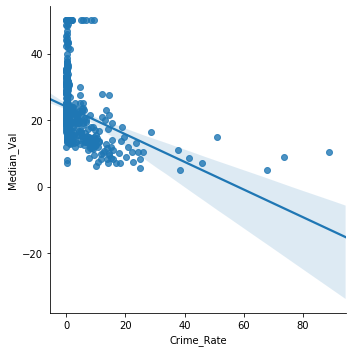

In [18]:
# lmplot of a weakly corrolated value "Distance to areas of employement (Dist_to_Jobs)"
sns.lmplot(x="Crime_Rate", y="Median_Val", data=df)

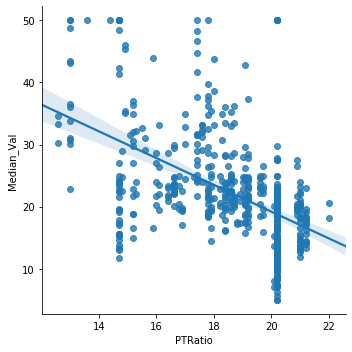

In [19]:
# lmplot of a weakly corrolated value "Distance to areas of employement (Dist_to_Jobs)"
sns.lmplot(x="PTRatio", y="Median_Val", data=df)

# 3. Inferential Statistics

#### Objective 2: Analyse whether there is a significant difference between median house prices between houses that are along the Charles river and those that aren't.

The first attribute who's effect on housing prices that I was asked to investigate is whether the house is by the Charles River or not ("CHAS" or "By_River").

In the original paper this dataset was derived from, the authors assumed there would be a positive relationship between being next to the river and housing prices.

As I have shown above, there only seems to be a very week positive corrolation (0.18).

In order to investigate further I have performed a T-Test below..

In [20]:
# getting the count of areas next to the Charles river
count_by_river = len(df[df['By_River'] == 1.0])
count_by_river

35

In [21]:
# getting the count of areas away from the Charles River
count_away_from_river = len(df[df['By_River'] == 0.0])
count_away_from_river

471

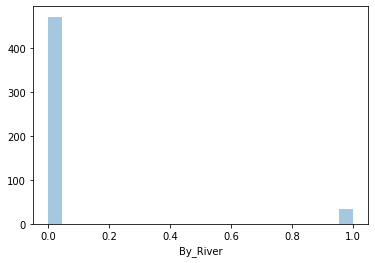

In [22]:
sns.distplot(df['By_River'], kde=False)

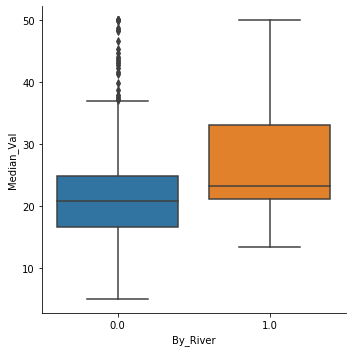

In [23]:
sns.catplot(x='By_River', y='Median_Val', kind='box', data=df)
# What do all the outliers mean

As we can see from the above counts and histogram, there are significantly more areas in our dataset that are located away from the Charles rive (471) vs next to the Charles River (35). There are also a significant number of outliers in the Median Value of houses in areas that are away from the river.

### Discuss issues with unequal sample sizes

Unequal sample sizes are a common issue that can lead to:
* Unequal variances between samples, which affects the assumption of equal variances in ANOVA Tests. 
* A general loss of power as equal size groups maxamize statistical power. This means it less likely the test will detect and effect if there is an effect to be detected.
* Issues with confounding variables.

However, while we need to be mindful of this it does not invalidate the results of an ANOVA test. 

In [24]:
next_to_river = df[df['By_River'] == 1]
away_from_river = df[df['By_River'] == 0]
next_to_river["Median_Val"].describe()

count    35.000000
mean     28.440000
std      11.816643
min      13.400000
25%      21.100000
50%      23.300000
75%      33.150000
max      50.000000
Name: Median_Val, dtype: float64

In [25]:
away_from_river["Median_Val"].describe()

count    471.000000
mean      22.093843
std        8.831362
min        5.000000
25%       16.600000
50%       20.900000
75%       24.800000
max       50.000000
Name: Median_Val, dtype: float64

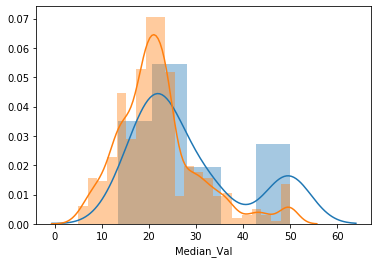

In [26]:
ax = sns.distplot(next_to_river['Median_Val'])
ax = sns.distplot(away_from_river['Median_Val'])
pyplt.rcParams["figure.figsize"] = (20,20)

### T-test

Before we can apply a T-Test, it first necessary to ensure that our datasets meet the requirements:

|#|Requirement|Pass|Reasoning|
|:------------------------|:---------|:-----------|:-----------|
|1|Dependent variable should be measured on continuous scale|YES|Median Value is measured on continuous scale|
|2|Independent variable should consist of two categorical independant groups|YES|Areas are either by or not by the river|
|3|Independence of observations|YES|None of the areas appear twice and no house appears in more than one area|
|4|There should be no significant outliers|NO|There are a number of outliers in the Median Values of houses not by the river|
|5|Dependent variable should be approximately normally distributed for each group|UNKNOWN|At first glance yes, but we will need to test to be sure|
|6|Needs to be homogeneity of variances|UNKNOWN|We will also need to test for this|


As you can see above, the first three requirements were met, but the 4th requirement was failed and the 5th and 6th requirements required further investigation before we can continue with out T-Test.

### Removing Outliers

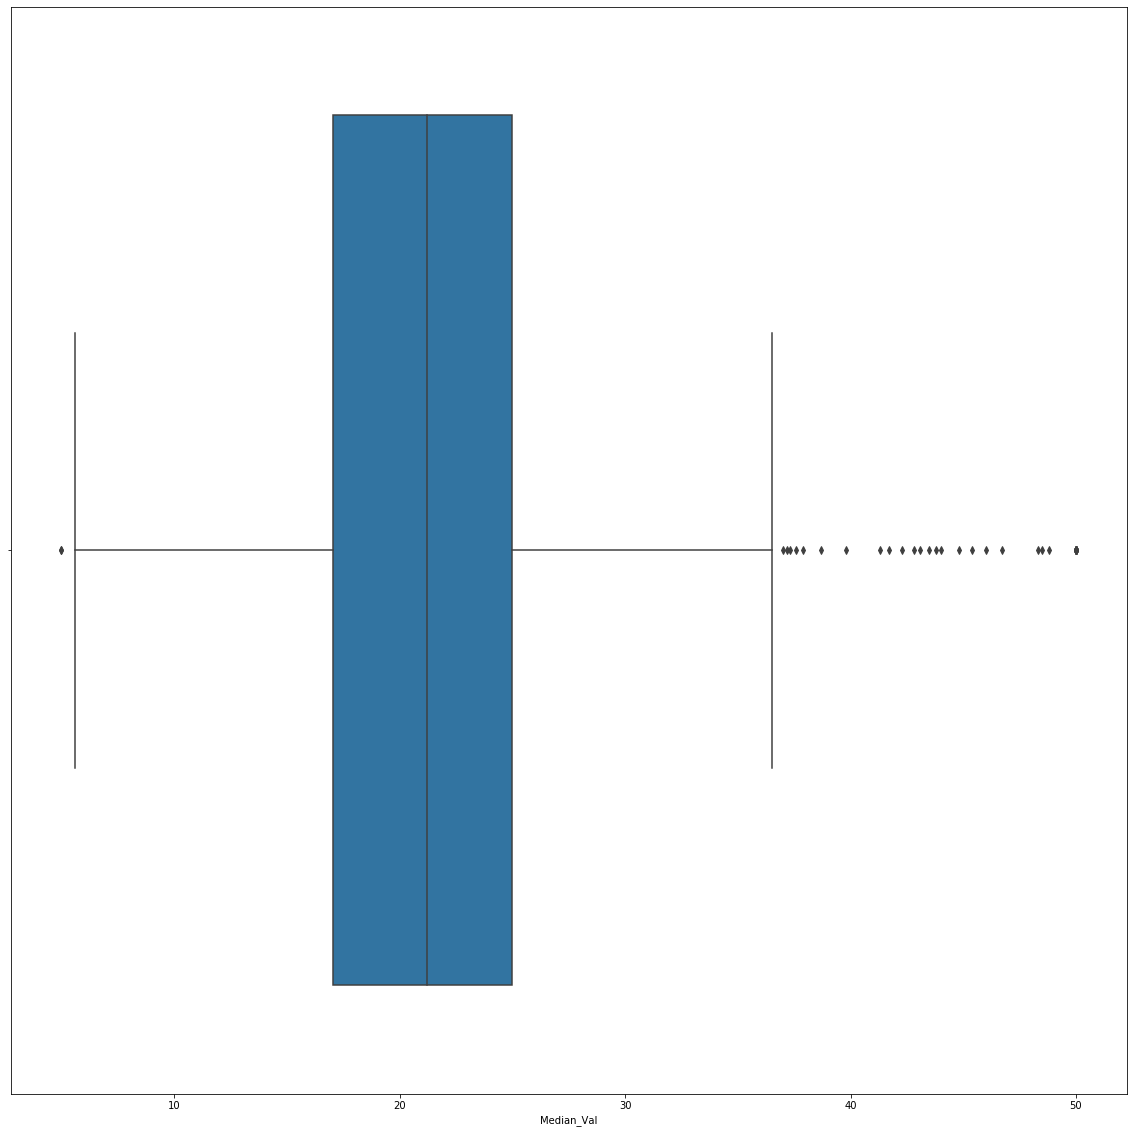

In [27]:
sns.boxplot(df['Median_Val'])

As we can see from the boxplot that we generated earlier there are a significant number of outliers in the target variable ("Median_Val"). There are also 16 areas where the median value of houses is $50,000. This indicates  that there might be a cap on values in the dataset at this value or that this value was entered where accurate information was not available. We could just remove these values, but first I will investigate how many outliers there are in total.

In order to identify the outliers we need to assign a threshold for the Median Value, above or below which we will consider the data point to be an outlier. The most obvious way of this is to follow the same method as the box-plot an remove an datapoints that are outside of the 75th and 25th percentiles. The Pandas library has a built in quantile method that can be used to calculate these thresholds.

In [28]:
Q1 = df['Median_Val'].quantile(0.25)
Q1

17.025

In [29]:
Q3 = df['Median_Val'].quantile(0.75)
Q3

25.0

In [30]:
IQR = Q3 - Q1
IQR

7.975000000000001

Now that the interquartile range has been calculated we can find the upper and lower "whisker" values for the box plot which will acts as our thresholds.

In [31]:
# calculate where the tip of the lower boxplot whisker is
lower_thresh = Q1 - 1.5 * IQR
lower_thresh

5.0624999999999964

In [32]:
# calculate where the tip of the upper boxplot whisker is
upper_thresh = Q3 + 1.5 * IQR
upper_thresh

36.962500000000006

In [33]:
# show all values that are below the lower outlier threshold
below = df.loc[df['Median_Val'] < lower_thresh]
below

,Crime_Rate,%_Large_Plots,%_Indus,By_River,NOX,Rooms,%_Pre_1940,Dist_to_Jobs,Highway_Access,Tax,PTRatio,Blks_per_1000,%_Lower_Status,Median_Val
398,38.3518,0.0,18.1,0.0,0.693,5.453,100.0,1.4896,24.0,666.0,20.2,396.90,30.59,5.0
405,67.9208,0.0,18.1,0.0,0.693,5.683,100.0,1.4254,24.0,666.0,20.2,384.97,22.98,5.0


There are two data points below the lower threshold.

In [34]:
# show all values that are above the upper outlier threshold
above = df.loc[df['Median_Val'] > upper_thresh]
above

,Crime_Rate,%_Large_Plots,%_Indus,By_River,NOX,Rooms,%_Pre_1940,Dist_to_Jobs,Highway_Access,Tax,PTRatio,Blks_per_1000,%_Lower_Status,Median_Val
97,0.12083,0.0,2.89,0.0,0.4450,8.069,76.0,3.4952,2.0,276.0,18.0,396.90,4.21,38.7
98,0.08187,0.0,2.89,0.0,0.4450,7.820,36.9,3.4952,2.0,276.0,18.0,393.53,3.57,43.8
157,1.22358,0.0,19.58,0.0,0.6050,6.943,97.4,1.8773,5.0,403.0,14.7,363.43,4.59,41.3
161,1.46336,0.0,19.58,0.0,0.6050,7.489,90.8,1.9709,5.0,403.0,14.7,374.43,1.73,50.0
162,1.83377,0.0,19.58,1.0,0.6050,7.802,98.2,2.0407,5.0,403.0,14.7,389.61,1.92,50.0
163,1.51902,0.0,19.58,1.0,0.6050,8.375,93.9,2.1620,5.0,403.0,14.7,388.45,3.32,50.0
166,2.01019,0.0,19.58,0.0,0.6050,7.929,96.2,2.0459,5.0,403.0,14.7,369.30,3.70,50.0
179,0.05780,0.0,2.46,0.0,0.4880,6.980,58.4,2.8290,3.0,193.0,17.8,396.90,5.04,37.2
180,0.06588,0.0,2.46,0.0,0.4880,7.765,83.3,2.7410,3.0,193.0,17.8,395.56,7.56,39.8
182,0.09103,0.0,2.46,0.0,0.4880,7.155,92.2,2.7006,3.0,193.0,17.8,394.12,4.82,37.9


In [35]:
above["Median_Val"].count()

38

There are 38 datapoints that are higher that the upper threshold. We can create a dataset called "no_outliers" that does not contain any outliers by removing both these groups.

In [36]:
no_outliers = df[((df['Median_Val'] > lower_thresh) & (df['Median_Val'] < upper_thresh))]
no_outliers

,Crime_Rate,%_Large_Plots,%_Indus,By_River,NOX,Rooms,%_Pre_1940,Dist_to_Jobs,Highway_Access,Tax,PTRatio,Blks_per_1000,%_Lower_Status,Median_Val
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2
5,0.02985,0.0,2.18,0.0,0.458,6.430,58.7,6.0622,3.0,222.0,18.7,394.12,5.21,28.7
6,0.08829,12.5,7.87,0.0,0.524,6.012,66.6,5.5605,5.0,311.0,15.2,395.60,12.43,22.9
7,0.14455,12.5,7.87,0.0,0.524,6.172,96.1,5.9505,5.0,311.0,15.2,396.90,19.15,27.1
8,0.21124,12.5,7.87,0.0,0.524,5.631,100.0,6.0821,5.0,311.0,15.2,386.63,29.93,16.5
9,0.17004,12.5,7.87,0.0,0.524,6.004,85.9,6.5921,5.0,311.0,15.2,386.71,17.10,18.9


We can then compare what our two populations look like with the outliers removed.

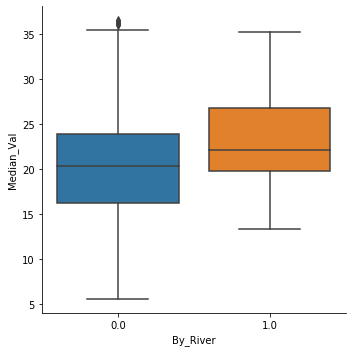

In [37]:

sns.catplot(x='By_River', y='Median_Val', kind='box', data=no_outliers)

### The dependant varibale needs to be approxmately normally distributed in each group.

In order to test this I created two new groups from the "no_outliers" dataset.

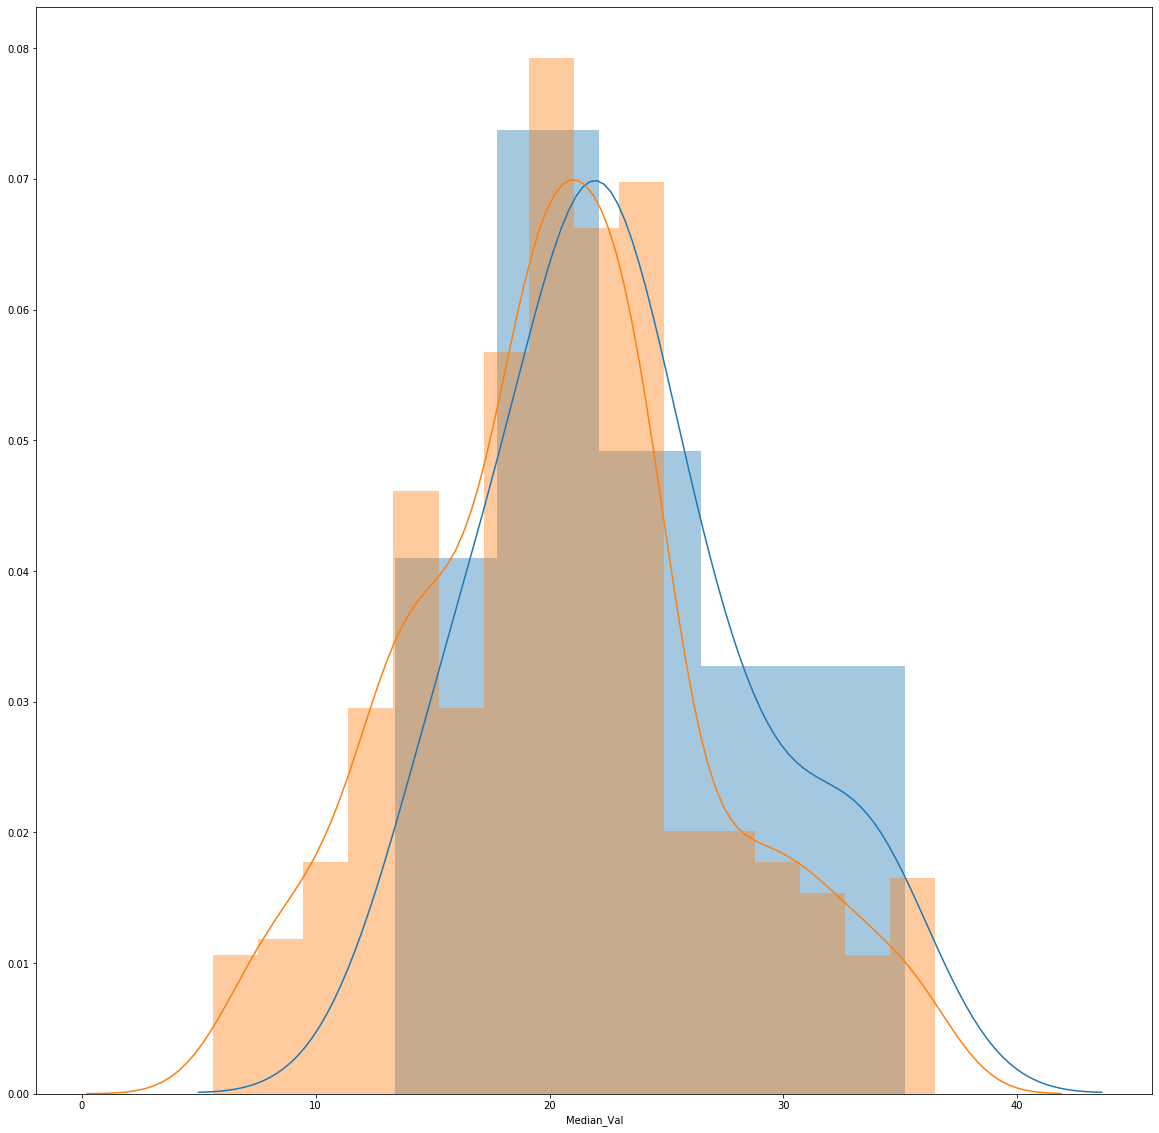

In [38]:
cleansed_next_to_river = no_outliers[no_outliers['By_River'] == 1]
cleansed_away_from_river = no_outliers[no_outliers['By_River'] == 0]

ax = sns.distplot(cleansed_next_to_river['Median_Val'])
ax = sns.distplot(cleansed_away_from_river['Median_Val'])
pyplt.rcParams["figure.figsize"] = (20,20)

From looking at the two "cleansed" datasets it can be observed that both are much closer to appearing to be normally distributed. However, we will need to test for this using Scipys "normaltest" function.

In [39]:
from scipy import stats
next_to_river_Ntest = stats.normaltest(cleansed_next_to_river['Median_Val'])
away_from_river_Ntest = stats.normaltest(cleansed_away_from_river['Median_Val'])
print(next_to_river_Ntest)
print(away_from_river_Ntest)


NormaltestResult(statistic=1.289316190319236, pvalue=0.5248419574390437)
NormaltestResult(statistic=3.405851916816045, pvalue=0.1821497808954563)


For both groups the Pvalue is greater than the alpha threshold(0.05). We can therefore say with a good degree of certainty that the data is normally distributed.
https://machinelearningmastery.com/a-gentle-introduction-to-normality-tests-in-python/

### Homogenity of Variances

Homogeneity of variance is an assumption underlying t tests in which the population variances (i.e., the distribution, or “spread,” of scores around the mean) of two or more samples are considered equal. In correlations and regressions, the term “homogeneity of variance in arrays,” also called “homoskedasticity,” refers to the assumption that, within the population, the variance of Y for each value of X is constant.

In order to perform a valid ttest we need to check if both samples have similar variances. Levenes test can be used to do this it. It tests the null hypothosis that variances are equal. 

In [40]:
# 
stats.levene(cleansed_next_to_river['Median_Val'], cleansed_away_from_river['Median_Val'])

LeveneResult(statistic=0.7964820987689898, pvalue=0.3726098479576784)

The Pvalue is greater than the threshold of 0.05 so we can say that there is no signifcant difference in the variances of both groups.

In [41]:
# variance of median values of houses next to the river
print(np.var(cleansed_next_to_river['Median_Val']))

31.402091836734694


In [42]:
# variance of values of house in areas away from the river
print(np.var(cleansed_away_from_river['Median_Val']))

41.76279086132484


### Summary of T Test Requirement Statuses

|#|Requirement|Pass|Reasoning|
|:------------------------|:---------|:-----------|:-----------|
|1|Dependent variable should be measured on continuous scale|YES|Median Value is measured on continuous scale|
|2|Independent variable should consist of two categorical independant groups|YES|Areas are either by or not by the river|
|3|Independence of observations|YES|None of the areas appear twice and no house appears in more than one area|
|4|There should be no significant outliers|YES|There were originally, but they have removed them.|
|5|Dependent variable should be approximately normally distributed for each group|YES|Both groups are approximately normally distrubuted.|
|6|Needs to be homogeneity of variances|YES|There is homogenity of variances|


### T Test Results

Since all the requirements were met, it was appropriate to proceed with the T Test.

In [43]:
stats.ttest_ind(cleansed_next_to_river['Median_Val'], cleansed_away_from_river['Median_Val'])

Ttest_indResult(statistic=2.100509858104912, pvalue=0.03622310352018016)

The purpose of the current study was to test if there is a significant difference in the Median_Value between the house prices in areas by or not by the Charles River in Boston.

In [44]:
import researchpy as rp

tt_descriptives, tt_results = rp.ttest(cleansed_next_to_river['Median_Val'], cleansed_away_from_river['Median_Val'])

tt_descriptives

,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,Median_Val,28.0,23.192857,5.706587,1.078444,20.980074,25.405640
1,Median_Val,438.0,20.560959,6.469804,0.309139,19.953375,21.168543
2,combined,466.0,20.719099,6.451416,0.298856,20.131823,21.306374


In [45]:
tt_results

,Independent t-test,results
0,Difference (Median_Val - Median_Val) =,2.6319
1,Degrees of freedom =,464.0000
2,t =,2.1005
3,Two side test p value =,0.0362
4,Difference > 0 p value =,0.9819
5,Difference < 0 p value =,0.0181
6,Cohen's d =,0.4095
7,Hedge's g =,0.4088
8,Glass's delta =,0.4612
9,r =,0.0971


The results of the test show a P value of 0.0362. This is lower than the 0.05 giving a strong indication that we can reject the null hypothesis that there is no difference between Median Value of houses in areas that are by or away from the Charles River in Boston. If the value was greater than 0.05 this would indicate that there was no difference between the two groups.

We can thereforce conclude that there is a significant difference between the housing prices for houses along the Charles River and those not along the Charles River.

# 4. Predictions


Add section discussiong the variables that were selected and why. 

What is the relationship between them all.

ANOVA Test?

## 4.1 Pre-Processing

Preprocessing is an integral step in Machine Learning. Quality of the data must be as good as possible before feeding into the model.

There are a number of different steps we can take to preprocesss the data and ensure the quality of the data:

1. Deal with any Null values
2. Deal with Categorical Variables
3. Standardise the Data


### 4.1.1 Null Values

First we will check to ensure if our cleansed dataset contains any Null values. If there are Null values, the row containing the value will be need to be removed of the value will need to be replaced.

In [46]:
no_outliers.isnull().sum()

Crime_Rate        0
%_Large_Plots     0
%_Indus           0
By_River          0
NOX               0
Rooms             0
%_Pre_1940        0
Dist_to_Jobs      0
Highway_Access    0
Tax               0
PTRatio           0
Blks_per_1000     0
%_Lower_Status    0
Median_Val        0
dtype: int64

As we can see, no of the columns contain Null values. So we can move on.

### 4.1.2 Check for Categorical Variables

As we have already seen there is one categorical variable in the dataset showing whether the area is located by or away from the Charles River.

Luckily this has already been coverted into a "dummy variable" of 0 for No and 1 for Yes. Therefore we dont have to do any encoding or processing of this variable.

In [47]:
no_outliers["By_River"]

0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
501    0.0
502    0.0
503    0.0
504    0.0
505    0.0
Name: By_River, Length: 466, dtype: float64

### 4.1.3 Standardise the Data

In standardisation we transform all values such that the means of the values is 0 and the standard deviation is 1.

This helps to prevent a machine learning model from giving a different weight to values that are at a different scale to other values. For example, if we look at the below we can see that variables like the number of black people per 1000 is always going to be higher than the number of Rooms in a house or the Pupil Teacher Ratio.

In [48]:
no_outliers.head()

,Crime_Rate,%_Large_Plots,%_Indus,By_River,NOX,Rooms,%_Pre_1940,Dist_to_Jobs,Highway_Access,Tax,PTRatio,Blks_per_1000,%_Lower_Status,Median_Val
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


Before we scale the data it needs to be split into the independent and dependent variables for the model.

It also a good idea to shuffle the data before going any further. 

In [49]:
no_outliers = shuffle(no_outliers)

In [50]:
# create the input from the first 13 variables
# output is the Median Value
x_input = no_outliers.iloc[:, 0:13]
y_output = no_outliers["Median_Val"]

The data then needs to be split into the testing and training sets. For this project we will use a 80:20 train:test split. 

We can use Sklearns model selection tool for this.

In [51]:
#train test splitting
x_train, x_test, y_train, y_test = mod.train_test_split(x_input, y_output, test_size=0.2)

In [52]:
x_train.iloc[0]

Crime_Rate          0.1415
%_Large_Plots       0.0000
%_Indus             6.9100
By_River            0.0000
NOX                 0.4480
Rooms               6.1690
%_Pre_1940          6.6000
Dist_to_Jobs        5.7209
Highway_Access      3.0000
Tax               233.0000
PTRatio            17.9000
Blks_per_1000     383.3700
%_Lower_Status      5.8100
Name: 42, dtype: float64

Once the data is split into testing and training sets it can be scaled.


In [53]:
scaler = pre.StandardScaler()
x_train = pd.DataFrame(scaler.fit_transform(x_train), columns=x_input.columns)
x_test = pd.DataFrame(scaler.transform(x_test), columns=x_input.columns)

In [54]:
x_train.iloc[0]

Crime_Rate       -0.431584
%_Large_Plots    -0.493786
%_Indus          -0.623325
By_River         -0.262613
NOX              -0.893438
Rooms            -0.028461
%_Pre_1940       -2.253115
Dist_to_Jobs      0.822681
Highway_Access   -0.753702
Tax              -1.056723
PTRatio          -0.325789
Blks_per_1000     0.315898
%_Lower_Status   -1.063686
Name: 0, dtype: float64

##  4.2 Baseline prediction test

At this stage I performed an inital test of the model to act as a performance baseline. I tuned this model further following this test.

In [55]:
# Defining the Baseline test model
m = ks.models.Sequential()
m.add(ks.layers.Dense(13, input_dim=13, activation="relu"))
m.add(ks.layers.Dense(1))
m.compile(loss="mean_squared_error", optimizer="adam")


Instructions for updating:
Colocations handled automatically by placer.


In [56]:

m.fit(x_train, y_train, epochs=100, batch_size=5)

Instructions for updating:
Use tf.cast instead.
Epoch 1/100
372/372 [==============================] - 0s 541us/step - loss: 456.3730
Epoch 2/100
372/372 [==============================] - 0s 159us/step - loss: 420.9276
Epoch 3/100
372/372 [==============================] - 0s 152us/step - loss: 385.3633
Epoch 4/100
372/372 [==============================] - 0s 159us/step - loss: 345.6882
Epoch 5/100
372/372 [==============================] - 0s 150us/step - loss: 300.9154
Epoch 6/100
372/372 [==============================] - 0s 152us/step - loss: 253.7621
Epoch 7/100
372/372 [==============================] - 0s 150us/step - loss: 207.6073
Epoch 8/100
372/372 [==============================] - 0s 146us/step - loss: 165.1669
Epoch 9/100
372/372 [==============================] - 0s 156us/step - loss: 129.2508
Epoch 10/100
372/372 [==============================] - 0s 206us/step - loss: 100.9047
Epoch 11/100
372/372 [==============================] - 0s 170us/step - loss: 79.5003
Epoch

372/372 [==============================] - 0s 140us/step - loss: 6.4043
Epoch 94/100
372/372 [==============================] - 0s 134us/step - loss: 6.3358
Epoch 95/100
372/372 [==============================] - 0s 150us/step - loss: 6.4671
Epoch 96/100
372/372 [==============================] - 0s 150us/step - loss: 6.2961
Epoch 97/100
372/372 [==============================] - 0s 142us/step - loss: 6.2887
Epoch 98/100
372/372 [==============================] - 0s 131us/step - loss: 6.2607
Epoch 99/100
372/372 [==============================] - 0s 131us/step - loss: 6.1648
Epoch 100/100
372/372 [==============================] - 0s 144us/step - loss: 6.1569


In [57]:
# show the predicted prices for the test input variables
MedianVal_prediction = m.predict(x_test).T
MedianVal_prediction

array([[26.188843 , 31.81453  , 32.394424 , 22.583652 , 18.492458 ,
        14.210079 , 15.4516735, 23.48384  , 15.697155 , 32.7646   ,
        27.202862 , 28.782707 , 15.409534 , 20.622135 , 20.595531 ,
        14.30411  , 19.229307 , 21.363598 , 28.437819 , 16.390217 ,
        23.945904 , 22.026447 , 29.957787 , 23.976364 , 23.218662 ,
        22.633545 , 28.10116  , 16.610842 , 23.714937 , 19.429405 ,
        18.990925 , 21.089355 , 26.960434 , 28.178263 , 26.352648 ,
        17.205791 , 21.98693  , 24.717552 , 18.68852  , 25.036469 ,
        18.633558 , 15.359837 , 19.543798 , 23.487406 ,  8.156921 ,
        24.92431  , 25.713167 , 12.654188 , 23.147234 , 24.927713 ,
        18.277666 , 24.367155 , 19.062948 , 19.304724 , 23.24491  ,
        23.018143 , 24.435331 , 21.27994  , 14.965775 ,  7.4489074,
        10.014896 , 18.59679  ,  9.888866 , 21.158264 , 15.152964 ,
        19.482151 , 19.771397 , 10.70706  , 20.743135 , 11.967041 ,
        19.914875 , 31.153885 , 15.026655 , 18.1

In [58]:
#show the real values
MedianVal_real = y_test.as_matrix().astype(np.float32)
MedianVal_real

c:\users\conor\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


array([23.9, 34.7, 33.2, 21.9, 17.7, 19.1, 23.2, 22.3, 14.3, 36.5, 27. ,
       29.1, 14.9, 16.1, 20.6,  7.2, 19.6, 22. , 31.5, 19.6, 25. , 20.6,
       32.9, 23.9, 24.4, 29.8, 27.9, 19.7, 23.2, 18.8, 21.1, 23.1, 29.8,
       30.8, 24.6, 15.6, 22.2, 22. , 21.9, 28.1, 22.5, 17.8, 22.2, 22.4,
        8.7, 23.7, 28.7, 13.5, 23.8, 22.1, 19.9, 25. , 18.8, 22. , 22.6,
       23.3, 29.6, 21.7, 14.1,  5.6, 13.8, 13.8, 13.4, 19.8, 14.1, 19.3,
       19.5, 10.5, 21.1,  8.3, 20.1, 31.1, 12.1, 20.4, 10.9,  7. , 12.8,
       10.5, 19.5, 23.2, 24.8, 15.4, 18.3, 29. , 10.4, 14.8, 15.2, 19.4,
       31.2, 10.2, 23.8, 15.6, 24. , 15. ], dtype=float32)

In [59]:
# Show prediction vs real side by side with difference between the two
predicted_V_real_df = pd.DataFrame({'Prediction': MedianVal_prediction.ravel(), 'Real_value': MedianVal_real.ravel()})
predicted_V_real_df['%Difference'] = 100*(abs(predicted_V_real_df['Prediction'] - predicted_V_real_df['Real_value'])/predicted_V_real_df['Prediction'])
predicted_V_real_df

,Prediction,Real_value,%Difference
0,26.188843,23.900000,8.739764
1,31.814529,34.700001,9.069666
2,32.394424,33.200001,2.486775
3,22.583652,21.900000,3.027202
4,18.492458,17.700001,4.285301
5,14.210079,19.100000,34.411640
6,15.451674,23.200001,50.145554
7,23.483841,22.299999,5.041091
8,15.697155,14.300000,8.900688
9,32.764599,36.500000,11.400723


In [60]:
# average of the percentage difference
predicted_V_real_df['%Difference'].mean()

11.5708475

In [61]:
# Evaluate the accuracy 
m.evaluate(x_test, y_test)

94/94 [==============================] - 0s 244us/step


7.615793694841101

## 4.3 Factor to Consider When Creating a Model

Before going any further it is worth outlining my reasoning for selecting the options that I did when creating this Baseline model and considerations for improving the model in later iterations.

#### Model Selection

I used the Sequential Model. This is "default" model for Keras. It functions by adding sequential layers of neurons. Inputs are fed into the first layers with outputs being passed on to subsequent layers. 

In the Baseline Test I have just added an input later that takes in 13 variables, and an output layers that gives out a single values (Y).

There is also the option to create custom "functional models" in Keras, but this was not necessary what we are trying to achieve.

#### Density

This is the layer type. In this type all node/neurons in the next layer are connected to all nodes in the previous layer. This is the best layer type for this projects use case. However, other layer types exist, such as Convolutional Layers (used for image prediction) and Recurrent Layers (used for time series data). 

#### Number of Layers

For the baseline we have added 1 input later and 1 output layer. This is the absolute minimum number we can have. There is also an single "hidden layer" automatically created from the outputs of the input layer.

In the case of linear and generalized linear models , having no hidden layers is enough and increasing this number doesn't necessarily improve the performance of the model. However, if there are mutliple inputs (such as in our data) having up to 2 hidden layers can help to improve accuracy, but there is no set rules for what will deliver the best results. [1][2]. 

I will introduce additional layers in later iterations of the model.

#### Number of Units per Layer

The number of input units should match the number of variables being inputted while the number of output units should match the number of outputs required. In this case we have 13 input variables and required 1 output. This is what has been entered into the Baseline test.

The number of units in a hidden layer depends on a number of factors [3]:

* the numbers of input and output units 
* the number of training cases 
* the amount of noise in the targets 
* the complexity of the function or classification to be learned 
* the architecture 
* the type of hidden unit activation function 
* the training algorithm 
* regularization 
 
Having too few or too many hidden units can result in underfitting and overfitting respectively reducing accuracy. 

There are some rules of thumb such as:
* somewhere between the size of the input and output layer
* (inputs + outputs) x 2/3
* never more than twice the number of the input layer

These fail to take account of size of the training dataset and other considerations [3]. 

We will expriment with different unit sizes in later iterations.



#### Activation Function

Choosing an appropriate activation function is one of the most important considerations when designing a model. An activation function is the non-linear transformation that is performed on the input data to create the output. In the absense of an activation function the model is just a linear regression model[4].

Different activation functions have different use cases. For example, Binary Step Functions is used in classification where there are only two choices. This is obviously not suitable for this projects dataset, but there are several others that are worth considering. 

##### Linear 
* Assumes input is proportional to output 
* Only suitable for simple tasks as each layer in the model only does a linear transformation of the output of the previous layer and passes it on.
* This is also the default function in Keras if no other function is specified.

##### Sigmoid 
* Non-linear
* Tries to push Y values to extremes making it useful for classification

##### Tanh 
* Essentially a scalled version of the Sigmoid function

##### ReLU
* The most widely used activation function.
* Full name is Rectified Linear Unit
* It's non-linear allowing for back propigation of erros. 
* Allows for mutliple layers of activated by the ReLU function. 
* ReLu should only be used in hidden layers.

As a rule of thumb, ReLu should be the first port of call when creating a model. If it's results are not optimal, then other functions can be considered [7]. This is why ReLU was used in the Baseline Model. The output was left at the default linear function. 




#### Loss Function

This is the method used to find the error between the actual values and predicted value. Different metrics are used for different use cases. 

For regression problems the best option is "mean-squared error" [6].

#### Optimizer

Optimizers try to minimise the loss function and make predictions as correct as possible. They do this by updating the model in response to the output of the loss function[10]. 

Adam is generally recommended as the best optimizer to use [8] along with SGD using Nestorov momentum[9]. I have used Adam in the baseline model and given that Adam incorporates many of the good features of SGD I do not think there would be much value in using other optimizers.

#### Epochs

An epoch is single pass of the entire training dataset through a machine learning model.

One pass is not enough as the model is learning each time the model is passed through. If there are too many epochs the model will go from underfitting to overfitting. That being said, there is no fixed rule on how many epochs is best for a given dataset [11]. 

In our Baseline Model we have set the model to perform 100 epochs. We will try larger numbers of epochs in later iterations. 

#### Batch Size

The batch size is the number of samples processed before the model is updated. For example, in the Baseline Model the batch size is 5. There are 372 samples (rows) in the training dataset so the date will be divided into 74 batches each with 5 rows. Therefore each epoch will involved 74 updates to the model. 

Generally, batch sizes are set to values that are to the power of 2 e.g. 32, 64, 128 etc. A good default batch size is 32 with smaller batches tending to give better results [12]. 


## 4.4 Model Tuning - Round 1

I will now test updating the model based on some of the possible improvements discussed above

1. Decreasing batch sizes beginning at 32
2. Increasing number of epochs starting at 100
3. Varied Layer Sizes
4. Increased numbers of layers

I will not be changing:
1. Activation functions
2. Loss function
3. Optimizer
From my investigation, the options in the Baseline Model already seem to be the best fit for the dataset.

### 4.4.1 Batch Sizes

###### Test 1-  Increasing Batch Size to 32


In [62]:
# Test 1
m = ks.models.Sequential()
m.add(ks.layers.Dense(13, input_dim=13, activation="relu"))
m.add(ks.layers.Dense(1))

m.compile(loss="mean_squared_error", optimizer="adam")

m.fit(x_train, y_train, epochs=100, batch_size=32)

batch_test1_prediction = m.predict(x_test).T

MedianVal_real = y_test.as_matrix().astype(np.float32)

result_batch1 = m.evaluate(x_test, y_test)

Epoch 1/100
372/372 [==============================] - 0s 272us/step - loss: 439.9232
Epoch 2/100
372/372 [==============================] - 0s 32us/step - loss: 432.4121
Epoch 3/100
372/372 [==============================] - 0s 27us/step - loss: 424.6808
Epoch 4/100
372/372 [==============================] - 0s 38us/step - loss: 416.1991
Epoch 5/100
372/372 [==============================] - 0s 35us/step - loss: 407.4132
Epoch 6/100
372/372 [==============================] - 0s 29us/step - loss: 397.8435
Epoch 7/100
372/372 [==============================] - 0s 35us/step - loss: 387.8086
Epoch 8/100
372/372 [==============================] - 0s 35us/step - loss: 376.9512
Epoch 9/100
372/372 [==============================] - 0s 29us/step - loss: 366.0204
Epoch 10/100
372/372 [==============================] - 0s 32us/step - loss: 354.3569
Epoch 11/100
372/372 [==============================] - 0s 38us/step - loss: 342.5203
Epoch 12/100
372/372 [==============================] - 0s 32u

372/372 [==============================] - 0s 27us/step - loss: 15.8211
Epoch 98/100
372/372 [==============================] - 0s 29us/step - loss: 15.7014
Epoch 99/100
372/372 [==============================] - 0s 32us/step - loss: 15.6033
Epoch 100/100
94/94 [==============================] - 0s 294us/step


c:\users\conor\anaconda3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':


In [63]:
result_batch1

18.551668775842543

###### Test 2 - Batch Size to 16

In [64]:
# Test 2
m = ks.models.Sequential()
m.add(ks.layers.Dense(13, input_dim=13, activation="relu"))
m.add(ks.layers.Dense(1))

m.compile(loss="mean_squared_error", optimizer="adam")

m.fit(x_train, y_train, epochs=100, batch_size=16)

batch_test1_prediction = m.predict(x_test).T

MedianVal_real = y_test.as_matrix().astype(np.float32)

result_batch2 = m.evaluate(x_test, y_test)

Epoch 1/100
372/372 [==============================] - 0s 317us/step - loss: 472.9925
Epoch 2/100
372/372 [==============================] - 0s 56us/step - loss: 457.4949
Epoch 3/100
372/372 [==============================] - 0s 54us/step - loss: 442.3234
Epoch 4/100
372/372 [==============================] - 0s 64us/step - loss: 426.4595
Epoch 5/100
372/372 [==============================] - 0s 56us/step - loss: 410.2577
Epoch 6/100
372/372 [==============================] - 0s 62us/step - loss: 392.9818
Epoch 7/100
372/372 [==============================] - 0s 48us/step - loss: 374.5949
Epoch 8/100
372/372 [==============================] - 0s 64us/step - loss: 355.1048
Epoch 9/100
372/372 [==============================] - 0s 59us/step - loss: 335.2191
Epoch 10/100
372/372 [==============================] - 0s 59us/step - loss: 314.6577
Epoch 11/100
372/372 [==============================] - 0s 57us/step - loss: 294.0237
Epoch 12/100
372/372 [==============================] - 0s 54u

372/372 [==============================] - 0s 48us/step - loss: 11.8773
Epoch 98/100
372/372 [==============================] - 0s 51us/step - loss: 11.7791
Epoch 99/100
372/372 [==============================] - 0s 56us/step - loss: 11.6386
Epoch 100/100
94/94 [==============================] - 0s 319us/step


c:\users\conor\anaconda3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':


In [65]:
result_batch2

15.396381256428171

###### Test 3 - Batch Size to 4

In [66]:
# Test 3
m = ks.models.Sequential()
m.add(ks.layers.Dense(13, input_dim=13, activation="relu"))
m.add(ks.layers.Dense(1))

m.compile(loss="mean_squared_error", optimizer="adam")

m.fit(x_train, y_train, epochs=100, batch_size=4)

batch_test1_prediction = m.predict(x_test).T

MedianVal_real = y_test.as_matrix().astype(np.float32)

result_batch3 = m.evaluate(x_test, y_test)

Epoch 1/100
372/372 [==============================] - 0s 534us/step - loss: 459.9512
Epoch 2/100
372/372 [==============================] - 0s 247us/step - loss: 408.6083
Epoch 3/100
372/372 [==============================] - 0s 230us/step - loss: 351.3227
Epoch 4/100
372/372 [==============================] - 0s 240us/step - loss: 283.8339
Epoch 5/100
372/372 [==============================] - 0s 219us/step - loss: 211.8583
Epoch 6/100
372/372 [==============================] - 0s 207us/step - loss: 148.1091
Epoch 7/100
372/372 [==============================] - 0s 206us/step - loss: 103.3144
Epoch 8/100
372/372 [==============================] - 0s 226us/step - loss: 75.7096
Epoch 9/100
372/372 [==============================] - 0s 206us/step - loss: 58.5690
Epoch 10/100
372/372 [==============================] - 0s 202us/step - loss: 47.1145
Epoch 11/100
372/372 [==============================] - 0s 209us/step - loss: 39.0486
Epoch 12/100
372/372 [==============================] - 

372/372 [==============================] - 0s 195us/step - loss: 6.3909
Epoch 97/100
372/372 [==============================] - 0s 188us/step - loss: 6.3564
Epoch 98/100
372/372 [==============================] - 0s 183us/step - loss: 6.3584
Epoch 99/100
372/372 [==============================] - 0s 181us/step - loss: 6.3633
Epoch 100/100
94/94 [==============================] - 0s 413us/step


c:\users\conor\anaconda3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':


In [67]:
result_batch3

6.889675576636132

###### Test 4 - Batch Size to 2

In [68]:
# Test 4
m = ks.models.Sequential()
m.add(ks.layers.Dense(13, input_dim=13, activation="relu"))
m.add(ks.layers.Dense(1))

m.compile(loss="mean_squared_error", optimizer="adam")

m.fit(x_train, y_train, epochs=100, batch_size=2)

batch_test1_prediction = m.predict(x_test).T

MedianVal_real = y_test.as_matrix().astype(np.float32)

result_batch4 = m.evaluate(x_test, y_test)

Epoch 1/100
372/372 [==============================] - 0s 656us/step - loss: 446.9457
Epoch 2/100
372/372 [==============================] - 0s 382us/step - loss: 346.5456
Epoch 3/100
372/372 [==============================] - 0s 402us/step - loss: 218.9200
Epoch 4/100
372/372 [==============================] - 0s 386us/step - loss: 123.4755
Epoch 5/100
372/372 [==============================] - 0s 375us/step - loss: 74.0386
Epoch 6/100
372/372 [==============================] - 0s 497us/step - loss: 50.0555
Epoch 7/100
372/372 [==============================] - 0s 473us/step - loss: 36.9342
Epoch 8/100
372/372 [==============================] - 0s 406us/step - loss: 29.4098
Epoch 9/100
372/372 [==============================] - 0s 377us/step - loss: 24.9207
Epoch 10/100
372/372 [==============================] - 0s 374us/step - loss: 21.8481
Epoch 11/100
372/372 [==============================] - 0s 382us/step - loss: 19.7973
Epoch 12/100
372/372 [==============================] - 0s 

372/372 [==============================] - 0s 520us/step - loss: 5.5416
Epoch 98/100
372/372 [==============================] - 0s 574us/step - loss: 5.5068
Epoch 99/100
372/372 [==============================] - 0s 542us/step - loss: 5.5247
Epoch 100/100
94/94 [==============================] - 0s 605us/step


c:\users\conor\anaconda3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':


In [69]:
result_batch4

7.125518088645124

#### 4.4.1.1 Commentary

I tested batch sizes multiple times and the results for 2 vs 4 batches was inconclusive. Sometimes 2 performed better and sometimes 4 performed better.

In order to get a more conclusive answer I test each five times and got the average of the tests.

In [70]:
# function to test batch sizes with 10 test and average of results

def batchsize_test(tests, b_size):
    counter = 0
    resultslist = []
    while counter < tests:
        m = ks.models.Sequential()
        m.add(ks.layers.Dense(13, input_dim=13, activation="relu"))
        m.add(ks.layers.Dense(1))

        m.compile(loss="mean_squared_error", optimizer="adam")

        m.fit(x_train, y_train, epochs=100, batch_size=b_size)

        batch_test1_prediction = m.predict(x_test).T

        MedianVal_real = y_test.as_matrix().astype(np.float32)

        result_batch3 = m.evaluate(x_test, y_test)
        counter += 1
        resultslist.append(result_batch3)
    avg_result = sum(resultslist) / tests
    return avg_result

#print(batchsize_test(5, 2))

In [71]:
#print(batchsize_test(5, 4))

###### Result of tests:

A batch size of 2 seems to perform marginally better. Given that we are dealing with a relatively small dataset memory isn't an issue so we should there is no reason not to use the smaller batch size. 

### 4.4.2 Number of Epochs

###### Test 1 - 500 Epochs

In [72]:
# Test 1
m = ks.models.Sequential()
m.add(ks.layers.Dense(13, input_dim=13, activation="relu"))
m.add(ks.layers.Dense(1))

m.compile(loss="mean_squared_error", optimizer="adam")

history = m.fit(x_train, y_train, epochs=500, batch_size=2)

epoch_test1_prediction = m.predict(x_test).T

MedianVal_real = y_test.as_matrix().astype(np.float32)

result_epochv1 = m.evaluate(x_test, y_test)

Epoch 1/500
372/372 [==============================] - 0s 857us/step - loss: 459.5376
Epoch 2/500
372/372 [==============================] - 0s 539us/step - loss: 392.8867
Epoch 3/500
372/372 [==============================] - 0s 646us/step - loss: 314.4830
Epoch 4/500
372/372 [==============================] - 0s 360us/step - loss: 224.2506
Epoch 5/500
372/372 [==============================] - 0s 393us/step - loss: 122.5790
Epoch 6/500
372/372 [==============================] - 0s 484us/step - loss: 51.1928
Epoch 7/500
372/372 [==============================] - 0s 525us/step - loss: 27.0399
Epoch 8/500
372/372 [==============================] - 0s 473us/step - loss: 21.3800
Epoch 9/500
372/372 [==============================] - 0s 594us/step - loss: 19.0120
Epoch 10/500
372/372 [==============================] - 0s 454us/step - loss: 17.3967
Epoch 11/500
372/372 [==============================] - 0s 403us/step - loss: 16.1235
Epoch 12/500
372/372 [==============================] - 0s

372/372 [==============================] - 0s 369us/step - loss: 5.6199
Epoch 98/500
372/372 [==============================] - 0s 376us/step - loss: 5.6302
Epoch 99/500
372/372 [==============================] - 0s 423us/step - loss: 5.5884
Epoch 100/500
372/372 [==============================] - 0s 442us/step - loss: 5.5437
Epoch 101/500
372/372 [==============================] - 0s 380us/step - loss: 5.5421
Epoch 102/500
372/372 [==============================] - 0s 376us/step - loss: 5.5872
Epoch 103/500
372/372 [==============================] - 0s 385us/step - loss: 5.5319
Epoch 104/500
372/372 [==============================] - 0s 374us/step - loss: 5.5380
Epoch 105/500
372/372 [==============================] - 0s 364us/step - loss: 5.4830
Epoch 106/500
372/372 [==============================] - 0s 384us/step - loss: 5.4752
Epoch 107/500
372/372 [==============================] - 0s 369us/step - loss: 5.4843
Epoch 108/500
372/372 [==============================] - 0s 384us/step

372/372 [==============================] - 0s 378us/step - loss: 4.7671
Epoch 193/500
372/372 [==============================] - 0s 377us/step - loss: 4.8085
Epoch 194/500
372/372 [==============================] - 0s 388us/step - loss: 4.7713
Epoch 195/500
372/372 [==============================] - 0s 402us/step - loss: 4.8144
Epoch 196/500
372/372 [==============================] - 0s 471us/step - loss: 4.7183
Epoch 197/500
372/372 [==============================] - 0s 407us/step - loss: 4.8144
Epoch 198/500
372/372 [==============================] - 0s 365us/step - loss: 4.8009
Epoch 199/500
372/372 [==============================] - 0s 371us/step - loss: 4.7711
Epoch 200/500
372/372 [==============================] - 0s 376us/step - loss: 4.7682
Epoch 201/500
372/372 [==============================] - 0s 371us/step - loss: 4.7556
Epoch 202/500
372/372 [==============================] - 0s 383us/step - loss: 4.7655
Epoch 203/500
372/372 [==============================] - 0s 380us/st

372/372 [==============================] - 0s 381us/step - loss: 4.4723
Epoch 288/500
372/372 [==============================] - 0s 371us/step - loss: 4.4877
Epoch 289/500
372/372 [==============================] - 0s 385us/step - loss: 4.4633
Epoch 290/500
372/372 [==============================] - 0s 376us/step - loss: 4.4084
Epoch 291/500
372/372 [==============================] - 0s 379us/step - loss: 4.4710
Epoch 292/500
372/372 [==============================] - 0s 375us/step - loss: 4.3904
Epoch 293/500
372/372 [==============================] - 0s 372us/step - loss: 4.3907
Epoch 294/500
372/372 [==============================] - 0s 372us/step - loss: 4.4021
Epoch 295/500
372/372 [==============================] - 0s 373us/step - loss: 4.4855
Epoch 296/500
372/372 [==============================] - 0s 408us/step - loss: 4.3727
Epoch 297/500
372/372 [==============================] - 0s 464us/step - loss: 4.4270
Epoch 298/500
372/372 [==============================] - 0s 445us/st

372/372 [==============================] - 0s 372us/step - loss: 4.1644
Epoch 383/500
372/372 [==============================] - 0s 379us/step - loss: 4.1938
Epoch 384/500
372/372 [==============================] - 0s 369us/step - loss: 4.1357
Epoch 385/500
372/372 [==============================] - 0s 373us/step - loss: 4.1558
Epoch 386/500
372/372 [==============================] - 0s 377us/step - loss: 4.1623
Epoch 387/500
372/372 [==============================] - 0s 381us/step - loss: 4.1246
Epoch 388/500
372/372 [==============================] - 0s 376us/step - loss: 4.2115
Epoch 389/500
372/372 [==============================] - 0s 371us/step - loss: 4.1449
Epoch 390/500
372/372 [==============================] - 0s 383us/step - loss: 4.1728
Epoch 391/500
372/372 [==============================] - 0s 374us/step - loss: 4.1824
Epoch 392/500
372/372 [==============================] - 0s 373us/step - loss: 4.1389
Epoch 393/500
372/372 [==============================] - 0s 378us/st

372/372 [==============================] - 0s 375us/step - loss: 4.0397
Epoch 478/500
372/372 [==============================] - 0s 385us/step - loss: 3.9875
Epoch 479/500
372/372 [==============================] - 0s 380us/step - loss: 3.9596
Epoch 480/500
372/372 [==============================] - 0s 368us/step - loss: 3.9893
Epoch 481/500
372/372 [==============================] - 0s 421us/step - loss: 3.9926
Epoch 482/500
372/372 [==============================] - 0s 387us/step - loss: 3.9878
Epoch 483/500
372/372 [==============================] - 0s 376us/step - loss: 3.9852
Epoch 484/500
372/372 [==============================] - 0s 375us/step - loss: 3.9731
Epoch 485/500
372/372 [==============================] - 0s 380us/step - loss: 3.9505
Epoch 486/500
372/372 [==============================] - 0s 369us/step - loss: 4.0249
Epoch 487/500
372/372 [==============================] - 0s 380us/step - loss: 3.9627
Epoch 488/500
372/372 [==============================] - 0s 373us/st

c:\users\conor\anaconda3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':


In [73]:
print(history.history.keys())

dict_keys(['loss'])


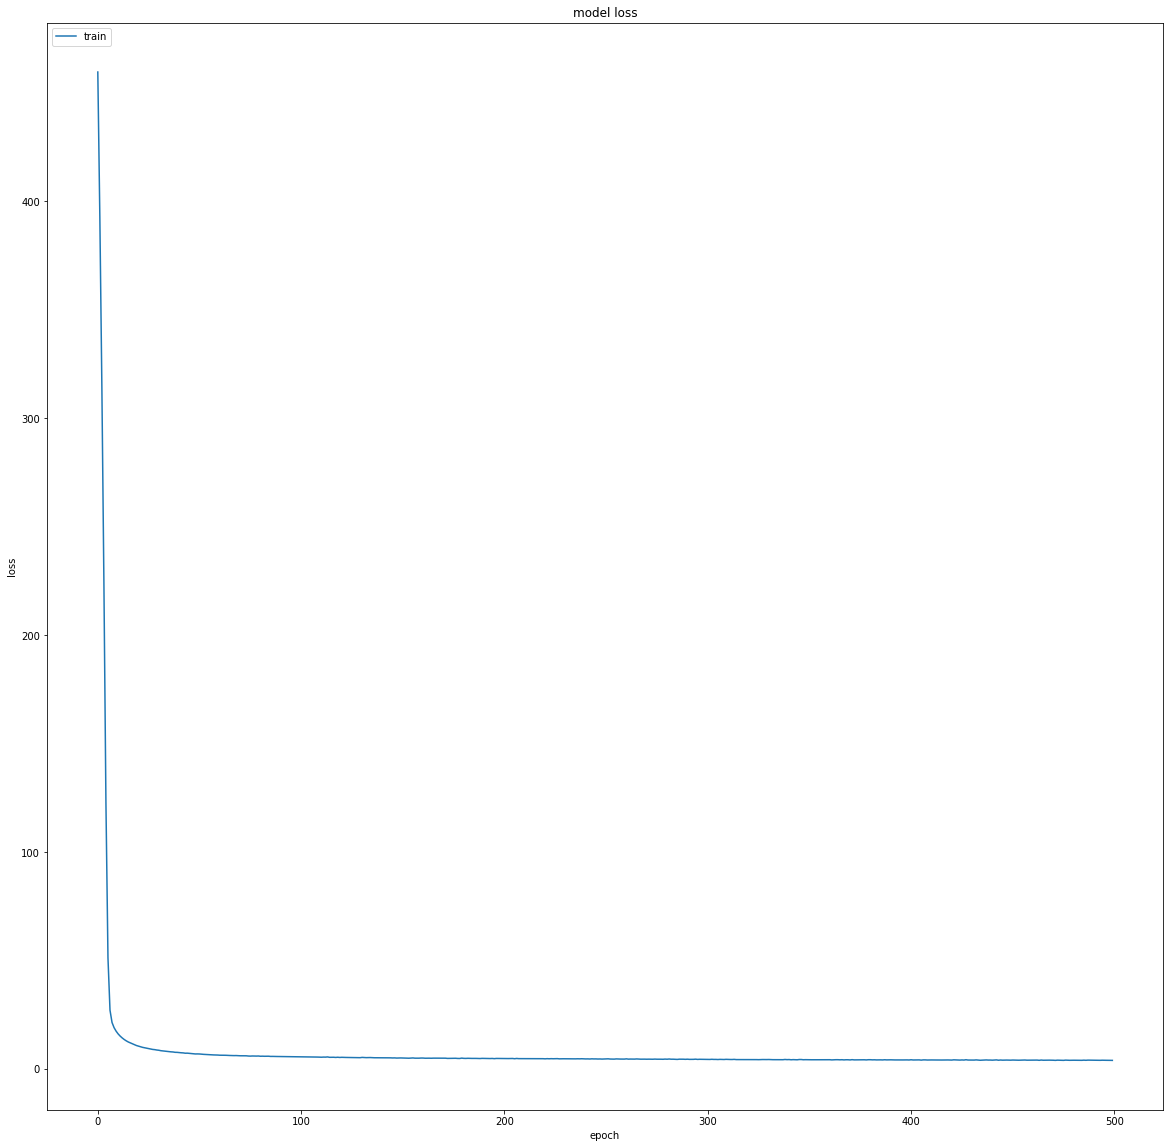

In [74]:
pyplt.plot(history.history['loss'])
pyplt.title('model loss')
pyplt.ylabel('loss')
pyplt.xlabel('epoch')
pyplt.legend(['train', 'test'], loc='upper left')
pyplt.show()

In [75]:
result_epochv1

7.111798550220246

From looking at the above results there definitely seems to deminishing returns or even signs of overfitting after the 300 epoch mark. With that it may be best to introduce early stopping once the loss metric stops reducing.  

###### Test 2 - 500 Epochs with Early Stopping

In [76]:
# Test 2
from keras.callbacks import EarlyStopping
m = ks.models.Sequential()
m.add(ks.layers.Dense(13, input_dim=13, activation="relu"))
m.add(ks.layers.Dense(1))

m.compile(loss="mean_squared_error", optimizer="adam")

#add early stopping
es = EarlyStopping(monitor='loss', patience=10, verbose=1)

history = m.fit(x_train, y_train, epochs=500, batch_size=2, callbacks=[es])

ES_prediction = m.predict(x_test).T

MedianVal_real = y_test.as_matrix().astype(np.float32)

result_ES = m.evaluate(x_test, y_test)

Epoch 1/500
372/372 [==============================] - 0s 755us/step - loss: 446.5204
Epoch 2/500
372/372 [==============================] - 0s 378us/step - loss: 357.8924
Epoch 3/500
372/372 [==============================] - 0s 375us/step - loss: 242.5864
Epoch 4/500
372/372 [==============================] - 0s 437us/step - loss: 134.5776
Epoch 5/500
372/372 [==============================] - 0s 414us/step - loss: 61.2979
Epoch 6/500
372/372 [==============================] - 0s 445us/step - loss: 31.3221
Epoch 7/500
372/372 [==============================] - 0s 386us/step - loss: 22.7407
Epoch 8/500
372/372 [==============================] - 0s 391us/step - loss: 19.4511
Epoch 9/500
372/372 [==============================] - 0s 382us/step - loss: 17.6260
Epoch 10/500
372/372 [==============================] - 0s 382us/step - loss: 16.3407
Epoch 11/500
372/372 [==============================] - 0s 391us/step - loss: 15.3540
Epoch 12/500
372/372 [==============================] - 0s 

372/372 [==============================] - 0s 385us/step - loss: 5.1184
Epoch 98/500
372/372 [==============================] - 0s 379us/step - loss: 5.1035
Epoch 99/500
372/372 [==============================] - 0s 371us/step - loss: 5.1218
Epoch 100/500
372/372 [==============================] - 0s 371us/step - loss: 5.0450
Epoch 101/500
372/372 [==============================] - 0s 396us/step - loss: 5.1205
Epoch 102/500
372/372 [==============================] - 0s 390us/step - loss: 5.0105
Epoch 103/500
372/372 [==============================] - 0s 382us/step - loss: 5.0454
Epoch 104/500
372/372 [==============================] - 0s 388us/step - loss: 5.0468
Epoch 105/500
372/372 [==============================] - 0s 442us/step - loss: 5.0299
Epoch 106/500
372/372 [==============================] - 0s 469us/step - loss: 4.9798
Epoch 107/500
372/372 [==============================] - 0s 400us/step - loss: 4.9592
Epoch 108/500
372/372 [==============================] - 0s 344us/step

372/372 [==============================] - 0s 398us/step - loss: 4.5853
Epoch 193/500
372/372 [==============================] - 0s 472us/step - loss: 4.5421
Epoch 194/500
372/372 [==============================] - 0s 398us/step - loss: 4.5406
Epoch 195/500
372/372 [==============================] - 0s 392us/step - loss: 4.5588
Epoch 196/500
372/372 [==============================] - 0s 383us/step - loss: 4.5685
Epoch 00196: early stopping
94/94 [==============================] - 0s 609us/step


c:\users\conor\anaconda3\lib\site-packages\ipykernel_launcher.py:16: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  app.launch_new_instance()


In [77]:
result_ES

7.766973911447728

#### 4.4.2.1 Commentary

Early stopping kicked in at before the 230 epoch mark in most test. This is even when the test was set to only stop when the loss value had no descresed for the previous 10 epochs.

In future there is probably no benefit to be gained from going over 250 Epochs

### 4.4.3 Number of Units per Layer

###### Test 1 - (inputs + outputs) x 2/3

One heuristic is that the number of units in the  hidden layer should be calculated using the above formula. We will test this first.

In [78]:
14*(2/3)


9.333333333333332

In [79]:
# Test 1
m = ks.models.Sequential()
m.add(ks.layers.Dense(9, input_dim=13, activation="relu"))
m.add(ks.layers.Dense(1))

m.compile(loss="mean_squared_error", optimizer="adam")

#add early stopping
es = EarlyStopping(monitor='loss', patience=10, verbose=1)

history = m.fit(x_train, y_train, epochs=250, batch_size=2, callbacks=[es])

layersize9_prediction = m.predict(x_test).T

MedianVal_real = y_test.as_matrix().astype(np.float32)

result_layerN9 = m.evaluate(x_test, y_test)

Epoch 1/250
372/372 [==============================] - 0s 916us/step - loss: 384.5424
Epoch 2/250
372/372 [==============================] - 0s 458us/step - loss: 285.5062
Epoch 3/250
372/372 [==============================] - 0s 406us/step - loss: 178.6202
Epoch 4/250
372/372 [==============================] - 0s 403us/step - loss: 99.4593
Epoch 5/250
372/372 [==============================] - 0s 396us/step - loss: 56.3741
Epoch 6/250
372/372 [==============================] - 0s 394us/step - loss: 37.4724
Epoch 7/250
372/372 [==============================] - 0s 395us/step - loss: 29.1534
Epoch 8/250
372/372 [==============================] - 0s 396us/step - loss: 24.6561
Epoch 9/250
372/372 [==============================] - 0s 368us/step - loss: 21.7531
Epoch 10/250
372/372 [==============================] - 0s 389us/step - loss: 19.8485
Epoch 11/250
372/372 [==============================] - 0s 421us/step - loss: 18.4943
Epoch 12/250
372/372 [==============================] - 0s 3

372/372 [==============================] - 0s 388us/step - loss: 5.9906
Epoch 98/250
372/372 [==============================] - 0s 383us/step - loss: 6.0428
Epoch 99/250
372/372 [==============================] - 0s 381us/step - loss: 6.0488
Epoch 100/250
372/372 [==============================] - 0s 411us/step - loss: 5.9827
Epoch 101/250
372/372 [==============================] - 0s 499us/step - loss: 5.9867
Epoch 102/250
372/372 [==============================] - 0s 390us/step - loss: 5.9991
Epoch 103/250
372/372 [==============================] - 0s 386us/step - loss: 5.9674
Epoch 104/250
372/372 [==============================] - 0s 389us/step - loss: 5.9269
Epoch 105/250
372/372 [==============================] - 0s 386us/step - loss: 5.9713
Epoch 106/250
372/372 [==============================] - 0s 377us/step - loss: 5.9257
Epoch 107/250
372/372 [==============================] - 0s 392us/step - loss: 5.9083
Epoch 108/250
372/372 [==============================] - 0s 377us/step

c:\users\conor\anaconda3\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app


In [80]:
result_layerN9

7.517161064959587

###### Test 2 - Twice the number of Inputs

One heuristics is that the number of units in the hidden layer should not be over twice the number of inputs.

In [81]:
# Test 2
m = ks.models.Sequential()
m.add(ks.layers.Dense(26, input_dim=13, activation="relu"))
m.add(ks.layers.Dense(1))

m.compile(loss="mean_squared_error", optimizer="adam")

#add early stopping
es = EarlyStopping(monitor='loss', patience=10, verbose=1)

history = m.fit(x_train, y_train, epochs=250, batch_size=2, callbacks=[es])

layersize26_prediction = m.predict(x_test).T

MedianVal_real = y_test.as_matrix().astype(np.float32)

result_layerN26 = m.evaluate(x_test, y_test)

Epoch 1/250
372/372 [==============================] - 0s 916us/step - loss: 423.0057
Epoch 2/250
372/372 [==============================] - 0s 408us/step - loss: 270.9344
Epoch 3/250
372/372 [==============================] - 0s 434us/step - loss: 125.3884
Epoch 4/250
372/372 [==============================] - 0s 475us/step - loss: 57.1502
Epoch 5/250
372/372 [==============================] - 0s 403us/step - loss: 33.0498
Epoch 6/250
372/372 [==============================] - 0s 396us/step - loss: 23.6821
Epoch 7/250
372/372 [==============================] - 0s 389us/step - loss: 19.6096
Epoch 8/250
372/372 [==============================] - 0s 387us/step - loss: 17.3140
Epoch 9/250
372/372 [==============================] - 0s 395us/step - loss: 16.0365
Epoch 10/250
372/372 [==============================] - 0s 406us/step - loss: 14.9008
Epoch 11/250
372/372 [==============================] - 0s 398us/step - loss: 14.0451
Epoch 12/250
372/372 [==============================] - 0s 4

372/372 [==============================] - 0s 426us/step - loss: 4.3107
Epoch 98/250
372/372 [==============================] - 0s 393us/step - loss: 4.2786
Epoch 99/250
372/372 [==============================] - 0s 398us/step - loss: 4.2702
Epoch 100/250
372/372 [==============================] - 0s 398us/step - loss: 4.2974
Epoch 101/250
372/372 [==============================] - 0s 388us/step - loss: 4.2580
Epoch 102/250
372/372 [==============================] - 0s 388us/step - loss: 4.2358
Epoch 103/250
372/372 [==============================] - 0s 395us/step - loss: 4.2445
Epoch 104/250
372/372 [==============================] - 0s 402us/step - loss: 4.1398
Epoch 105/250
372/372 [==============================] - 0s 504us/step - loss: 4.2277
Epoch 106/250
372/372 [==============================] - 0s 380us/step - loss: 4.1770
Epoch 107/250
372/372 [==============================] - 0s 410us/step - loss: 4.1568
Epoch 108/250
372/372 [==============================] - 0s 390us/step

372/372 [==============================] - 0s 415us/step - loss: 3.4984
Epoch 193/250
372/372 [==============================] - 0s 497us/step - loss: 3.4309
Epoch 194/250
372/372 [==============================] - 0s 414us/step - loss: 3.4956
Epoch 195/250
372/372 [==============================] - 0s 385us/step - loss: 3.4702
Epoch 196/250
372/372 [==============================] - 0s 386us/step - loss: 3.3559
Epoch 197/250
372/372 [==============================] - 0s 403us/step - loss: 3.4094
Epoch 198/250
372/372 [==============================] - 0s 411us/step - loss: 3.4317
Epoch 199/250
372/372 [==============================] - 0s 392us/step - loss: 3.3878
Epoch 200/250
372/372 [==============================] - 0s 395us/step - loss: 3.3716
Epoch 201/250
372/372 [==============================] - 0s 409us/step - loss: 3.3858
Epoch 202/250
372/372 [==============================] - 0s 390us/step - loss: 3.4047
Epoch 203/250
372/372 [==============================] - 0s 395us/st

c:\users\conor\anaconda3\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app


In [82]:
result_layerN26

9.170963064153144

###### Test 3 - Quadrupel the Input

In [83]:
m = ks.models.Sequential()
m.add(ks.layers.Dense(52, input_dim=13, activation="relu"))
m.add(ks.layers.Dense(1))

m.compile(loss="mean_squared_error", optimizer="adam")

#add early stopping
es = EarlyStopping(monitor='loss', patience=10, verbose=1)

history = m.fit(x_train, y_train, epochs=250, batch_size=2, callbacks=[es])

layersize52_prediction = m.predict(x_test).T

MedianVal_real = y_test.as_matrix().astype(np.float32)

result_layerN52 = m.evaluate(x_test, y_test)

Epoch 1/250
372/372 [==============================] - 0s 856us/step - loss: 370.6237
Epoch 2/250
372/372 [==============================] - 0s 422us/step - loss: 153.9478
Epoch 3/250
372/372 [==============================] - 0s 455us/step - loss: 49.6064
Epoch 4/250
372/372 [==============================] - 0s 442us/step - loss: 26.4010
Epoch 5/250
372/372 [==============================] - 0s 437us/step - loss: 18.9808
Epoch 6/250
372/372 [==============================] - 0s 436us/step - loss: 16.0520
Epoch 7/250
372/372 [==============================] - 0s 426us/step - loss: 14.5203
Epoch 8/250
372/372 [==============================] - 0s 417us/step - loss: 13.4721
Epoch 9/250
372/372 [==============================] - 0s 401us/step - loss: 12.5536
Epoch 10/250
372/372 [==============================] - 0s 423us/step - loss: 11.7119
Epoch 11/250
372/372 [==============================] - 0s 412us/step - loss: 11.1009
Epoch 12/250
372/372 [==============================] - 0s 41

372/372 [==============================] - 0s 394us/step - loss: 3.7839
Epoch 98/250
372/372 [==============================] - 0s 466us/step - loss: 3.6933
Epoch 99/250
372/372 [==============================] - 0s 485us/step - loss: 3.6845
Epoch 100/250
372/372 [==============================] - 0s 402us/step - loss: 3.6802
Epoch 101/250
372/372 [==============================] - 0s 395us/step - loss: 3.6901
Epoch 102/250
372/372 [==============================] - 0s 391us/step - loss: 3.6921
Epoch 103/250
372/372 [==============================] - 0s 408us/step - loss: 3.6146
Epoch 104/250
372/372 [==============================] - 0s 523us/step - loss: 3.6538
Epoch 105/250
372/372 [==============================] - 0s 397us/step - loss: 3.6635
Epoch 106/250
372/372 [==============================] - 0s 400us/step - loss: 3.6181
Epoch 107/250
372/372 [==============================] - 0s 385us/step - loss: 3.6229
Epoch 108/250
372/372 [==============================] - 0s 400us/step

372/372 [==============================] - 0s 425us/step - loss: 3.0723
Epoch 193/250
372/372 [==============================] - 0s 398us/step - loss: 2.8981
Epoch 194/250
372/372 [==============================] - 0s 416us/step - loss: 2.8952
Epoch 00194: early stopping
94/94 [==============================] - 0s 997us/step


c:\users\conor\anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [84]:
result_layerN52

8.098444776332125

Results appear inconclusive again. Need to test mutliple times and get an average.

In [85]:
def unitsize_test(tests, batchsize, unit_size):
    counter = 0
    resultslist = []
    while counter < tests:
        m = ks.models.Sequential()
        m.add(ks.layers.Dense(unit_size, input_dim=13, activation="relu"))
        m.add(ks.layers.Dense(1))

        m.compile(loss="mean_squared_error", optimizer="adam")
        
        es = EarlyStopping(monitor='loss', patience=10, verbose=1)
        
        m.fit(x_train, y_train, epochs=300, batch_size=batchsize, callbacks=[es])

        #unit_prediction = m.predict(x_test).T

        #MedianVal_real = y_test.as_matrix().astype(np.float32)

        result_units = m.evaluate(x_test, y_test)
        counter += 1
        resultslist.append(result_units)
    avg_result = sum(resultslist) / tests
    return avg_result

In [86]:
# hidden layer size = 26
# batch size = 2
# epoch = 300 - with early stopping
#print(unitsize_test(5, 2, 26))

Result was 8.461502002147919

In [87]:
# hidden layer size = 26
# batch size = 4
# epoch = 300 - with early stopping
#print(unitsize_test(5, 4, 26))

Result was 7.670181302821382

In [88]:
# hidden layer size = 52
# batch size = 2
# epoch = 300 - with early stopping
#print(unitsize_test(5, 2, 52))

Result was 8.024365358149751

In [89]:
# hidden layer size = 52
# batch size = 4
# epoch = 300 - with early stopping
#print(unitsize_test(5, 4, 52))

Result was 7.862417864292226

In [90]:
# hidden layer size = 64
# batch size = 2
# epoch = 300 - with early stopping
#print(unitsize_test(5, 2, 64))

Result was 8.067290689590129

In [91]:
# hidden layer size = 64
# batch size = 4
# epoch = 300 - with early stopping
#print(unitsize_test(5, 4, 64))

Result was 7.880062107329673

The best result seems to be a hidden layer of 26 units and a batch size of 4 per epoch. Batch sizes of 4 seem to consistently perform better.

### 4.4.4 Number of Layers

To begin with we will test adding one additional hidden layer of various sizes.

In [100]:
def layer_count_test(tests, batchsize, unit_size1, unit_size2):
    counter = 0
    resultslist = []
    while counter < tests:
        m = ks.models.Sequential()
        m.add(ks.layers.Dense(unit_size1, input_dim=13, activation="relu"))
        m.add(ks.layers.Dense(unit_size2, activation="relu"))
        m.add(ks.layers.Dense(1))

        m.compile(loss="mean_squared_error", optimizer="adam")
        
        es = EarlyStopping(monitor='loss', patience=10, verbose=1)
        
        m.fit(x_train, y_train, epochs=300, batch_size=batchsize, callbacks=[es])

        result_units = m.evaluate(x_test, y_test)
        
        counter += 1
        
        resultslist.append(result_units)
        print("Version: " + tests, batchsize, unit_size1, unit_size2 + " iteration: " + counter)
        
    avg_result = sum(resultslist) / tests
    return avg_result

In [105]:
layers_test_results = [
    layer_count_test(5, 4, 13, 13),
    layer_count_test(5, 4, 26, 26),
    layer_count_test(5, 4, 26, 13),
    layer_count_test(5, 4, 52, 26),
    layer_count_test(5, 4, 64, 13),
]

Epoch 1/300
372/372 [==============================] - 1s 3ms/step - loss: 411.5883
Epoch 2/300
372/372 [==============================] - 0s 445us/step - loss: 264.0360
Epoch 3/300
372/372 [==============================] - 0s 472us/step - loss: 97.7874
Epoch 4/300
372/372 [==============================] - 0s 484us/step - loss: 45.5065
Epoch 5/300
372/372 [==============================] - 0s 453us/step - loss: 31.0136
Epoch 6/300
372/372 [==============================] - 0s 476us/step - loss: 23.6416
Epoch 7/300
372/372 [==============================] - 0s 483us/step - loss: 19.6922
Epoch 8/300
372/372 [==============================] - 0s 461us/step - loss: 17.4662
Epoch 9/300
372/372 [==============================] - 0s 454us/step - loss: 15.7928
Epoch 10/300
372/372 [==============================] - 0s 476us/step - loss: 14.6159
Epoch 11/300
372/372 [==============================] - 0s 465us/step - loss: 13.4952
Epoch 12/300
372/372 [==============================] - 0s 465u

372/372 [==============================] - 0s 409us/step - loss: 4.3216
Epoch 98/300
372/372 [==============================] - 0s 480us/step - loss: 4.2874
Epoch 99/300
372/372 [==============================] - 0s 432us/step - loss: 4.1796
Epoch 100/300
372/372 [==============================] - 0s 403us/step - loss: 4.1631
Epoch 101/300
372/372 [==============================] - 0s 416us/step - loss: 4.1773
Epoch 102/300
372/372 [==============================] - 0s 422us/step - loss: 4.2150
Epoch 103/300
372/372 [==============================] - 0s 424us/step - loss: 4.0778
Epoch 104/300
372/372 [==============================] - 0s 450us/step - loss: 4.0744
Epoch 105/300
372/372 [==============================] - 0s 446us/step - loss: 4.1168
Epoch 106/300
372/372 [==============================] - 0s 438us/step - loss: 4.0460
Epoch 107/300
372/372 [==============================] - 0s 485us/step - loss: 4.0019
Epoch 108/300
372/372 [==============================] - 0s 430us/step

372/372 [==============================] - 0s 450us/step - loss: 3.0340
Epoch 193/300
372/372 [==============================] - 0s 414us/step - loss: 3.0435
Epoch 194/300
372/372 [==============================] - 0s 447us/step - loss: 3.0218
Epoch 195/300
372/372 [==============================] - 0s 429us/step - loss: 3.0828
Epoch 196/300
372/372 [==============================] - 0s 405us/step - loss: 3.0272
Epoch 197/300
372/372 [==============================] - 0s 415us/step - loss: 2.9936
Epoch 198/300
372/372 [==============================] - 0s 424us/step - loss: 3.0465
Epoch 199/300
372/372 [==============================] - 0s 420us/step - loss: 3.0265
Epoch 200/300
372/372 [==============================] - 0s 431us/step - loss: 3.0271
Epoch 201/300
372/372 [==============================] - 0s 436us/step - loss: 2.9851
Epoch 202/300
372/372 [==============================] - 0s 448us/step - loss: 2.9746
Epoch 203/300
372/372 [==============================] - 0s 416us/st

372/372 [==============================] - 0s 448us/step - loss: 34.6264
Epoch 6/300
372/372 [==============================] - 0s 435us/step - loss: 25.4464
Epoch 7/300
372/372 [==============================] - 0s 430us/step - loss: 20.0236
Epoch 8/300
372/372 [==============================] - 0s 425us/step - loss: 16.9670
Epoch 9/300
372/372 [==============================] - 0s 444us/step - loss: 15.0343
Epoch 10/300
372/372 [==============================] - 0s 417us/step - loss: 13.7020
Epoch 11/300
372/372 [==============================] - 0s 406us/step - loss: 12.7189
Epoch 12/300
372/372 [==============================] - 0s 448us/step - loss: 12.0719
Epoch 13/300
372/372 [==============================] - 0s 496us/step - loss: 11.4045
Epoch 14/300
372/372 [==============================] - 0s 410us/step - loss: 10.7613
Epoch 15/300
372/372 [==============================] - 0s 447us/step - loss: 10.3177
Epoch 16/300
372/372 [==============================] - 0s 444us/step -

372/372 [==============================] - 0s 439us/step - loss: 4.2308
Epoch 102/300
372/372 [==============================] - 0s 402us/step - loss: 4.1889
Epoch 103/300
372/372 [==============================] - 0s 424us/step - loss: 4.1619
Epoch 104/300
372/372 [==============================] - 0s 415us/step - loss: 4.2803
Epoch 105/300
372/372 [==============================] - 0s 412us/step - loss: 4.1384
Epoch 106/300
372/372 [==============================] - 0s 415us/step - loss: 4.1709
Epoch 107/300
372/372 [==============================] - 0s 431us/step - loss: 4.1748
Epoch 108/300
372/372 [==============================] - 0s 418us/step - loss: 4.2049
Epoch 109/300
372/372 [==============================] - 0s 402us/step - loss: 4.1550
Epoch 110/300
372/372 [==============================] - 0s 416us/step - loss: 4.0758
Epoch 111/300
372/372 [==============================] - 0s 416us/step - loss: 4.0621
Epoch 112/300
372/372 [==============================] - 0s 421us/st

372/372 [==============================] - 0s 449us/step - loss: 3.3038
Epoch 197/300
372/372 [==============================] - 0s 407us/step - loss: 3.2866
Epoch 198/300
372/372 [==============================] - 0s 441us/step - loss: 3.3205
Epoch 199/300
372/372 [==============================] - 0s 436us/step - loss: 3.3436
Epoch 200/300
372/372 [==============================] - 0s 421us/step - loss: 3.2795
Epoch 201/300
372/372 [==============================] - 0s 426us/step - loss: 3.2776
Epoch 202/300
372/372 [==============================] - 0s 423us/step - loss: 3.2894
Epoch 203/300
372/372 [==============================] - 0s 431us/step - loss: 3.2905
Epoch 204/300
372/372 [==============================] - 0s 400us/step - loss: 3.2468
Epoch 205/300
372/372 [==============================] - 0s 442us/step - loss: 3.2963
Epoch 206/300
372/372 [==============================] - 0s 411us/step - loss: 3.3310
Epoch 207/300
372/372 [==============================] - 0s 432us/st

372/372 [==============================] - 0s 463us/step - loss: 6.2035
Epoch 55/300
372/372 [==============================] - 0s 451us/step - loss: 6.2295
Epoch 56/300
372/372 [==============================] - 0s 428us/step - loss: 6.2081
Epoch 57/300
372/372 [==============================] - 0s 433us/step - loss: 6.1364
Epoch 58/300
372/372 [==============================] - 0s 454us/step - loss: 6.1073
Epoch 59/300
372/372 [==============================] - 0s 456us/step - loss: 6.0259
Epoch 60/300
372/372 [==============================] - 0s 455us/step - loss: 6.0280
Epoch 61/300
372/372 [==============================] - 0s 427us/step - loss: 6.0228
Epoch 62/300
372/372 [==============================] - 0s 458us/step - loss: 5.9241
Epoch 63/300
372/372 [==============================] - 0s 428us/step - loss: 5.9866
Epoch 64/300
372/372 [==============================] - 0s 424us/step - loss: 5.8992
Epoch 65/300
372/372 [==============================] - 0s 415us/step - loss: 

Epoch 150/300
372/372 [==============================] - 0s 410us/step - loss: 4.4546
Epoch 151/300
372/372 [==============================] - 0s 418us/step - loss: 4.4959
Epoch 152/300
372/372 [==============================] - 0s 414us/step - loss: 4.4675
Epoch 153/300
372/372 [==============================] - 0s 419us/step - loss: 4.4083
Epoch 154/300
372/372 [==============================] - 0s 414us/step - loss: 4.4465
Epoch 155/300
372/372 [==============================] - 0s 416us/step - loss: 4.4517
Epoch 156/300
372/372 [==============================] - 0s 436us/step - loss: 4.5009
Epoch 157/300
372/372 [==============================] - 0s 420us/step - loss: 4.3696
Epoch 158/300
372/372 [==============================] - 0s 445us/step - loss: 4.4865
Epoch 159/300
372/372 [==============================] - 0s 440us/step - loss: 4.3423
Epoch 160/300
372/372 [==============================] - 0s 433us/step - loss: 4.2435
Epoch 161/300
372/372 [==============================]

372/372 [==============================] - 0s 477us/step - loss: 3.6888
Epoch 246/300
372/372 [==============================] - 0s 443us/step - loss: 3.5667
Epoch 247/300
372/372 [==============================] - 0s 436us/step - loss: 3.5338
Epoch 248/300
372/372 [==============================] - 0s 414us/step - loss: 3.5680
Epoch 249/300
372/372 [==============================] - 0s 525us/step - loss: 3.6035
Epoch 250/300
372/372 [==============================] - 0s 445us/step - loss: 3.5566
Epoch 251/300
372/372 [==============================] - 0s 421us/step - loss: 3.4962
Epoch 252/300
372/372 [==============================] - 0s 407us/step - loss: 3.5117
Epoch 253/300
372/372 [==============================] - 0s 441us/step - loss: 3.5390
Epoch 254/300
372/372 [==============================] - 0s 575us/step - loss: 3.5427
Epoch 255/300
372/372 [==============================] - 0s 470us/step - loss: 3.5740
Epoch 256/300
372/372 [==============================] - 0s 456us/st

372/372 [==============================] - 0s 456us/step - loss: 5.6267
Epoch 66/300
372/372 [==============================] - 0s 448us/step - loss: 5.5261
Epoch 67/300
372/372 [==============================] - 0s 450us/step - loss: 5.5502
Epoch 68/300
372/372 [==============================] - 0s 413us/step - loss: 5.5012
Epoch 69/300
372/372 [==============================] - 0s 418us/step - loss: 5.5380
Epoch 70/300
372/372 [==============================] - 0s 444us/step - loss: 5.3718
Epoch 71/300
372/372 [==============================] - 0s 470us/step - loss: 5.5140
Epoch 72/300
372/372 [==============================] - 0s 441us/step - loss: 5.4207
Epoch 73/300
372/372 [==============================] - 0s 451us/step - loss: 5.3412
Epoch 74/300
372/372 [==============================] - 0s 451us/step - loss: 5.3201
Epoch 75/300
372/372 [==============================] - 0s 445us/step - loss: 5.3205
Epoch 76/300
372/372 [==============================] - 0s 439us/step - loss: 

372/372 [==============================] - 0s 550us/step - loss: 4.1273
Epoch 161/300
372/372 [==============================] - 0s 565us/step - loss: 4.0699
Epoch 162/300
372/372 [==============================] - 0s 544us/step - loss: 4.2269
Epoch 163/300
372/372 [==============================] - 0s 485us/step - loss: 4.0636
Epoch 164/300
372/372 [==============================] - 0s 563us/step - loss: 4.0869
Epoch 165/300
372/372 [==============================] - 0s 686us/step - loss: 4.1223
Epoch 166/300
372/372 [==============================] - 0s 638us/step - loss: 4.0612
Epoch 167/300
372/372 [==============================] - 0s 576us/step - loss: 4.1314
Epoch 168/300
372/372 [==============================] - 0s 673us/step - loss: 4.1149
Epoch 169/300
372/372 [==============================] - 0s 619us/step - loss: 3.9577
Epoch 170/300
372/372 [==============================] - 0s 534us/step - loss: 4.1445
Epoch 171/300
372/372 [==============================] - 0s 683us/st

372/372 [==============================] - 0s 438us/step - loss: 3.5292
Epoch 256/300
372/372 [==============================] - 0s 452us/step - loss: 3.5676
Epoch 257/300
372/372 [==============================] - 0s 459us/step - loss: 3.4743
Epoch 258/300
372/372 [==============================] - 0s 457us/step - loss: 3.5022
Epoch 259/300
372/372 [==============================] - 0s 450us/step - loss: 3.4431
Epoch 260/300
372/372 [==============================] - 0s 446us/step - loss: 3.5909
Epoch 261/300
372/372 [==============================] - 0s 466us/step - loss: 3.5812
Epoch 262/300
372/372 [==============================] - 0s 417us/step - loss: 3.5047
Epoch 263/300
372/372 [==============================] - 0s 444us/step - loss: 3.5078
Epoch 264/300
372/372 [==============================] - 0s 457us/step - loss: 3.6263
Epoch 265/300
372/372 [==============================] - 0s 447us/step - loss: 3.4276
Epoch 266/300
372/372 [==============================] - 0s 449us/st

372/372 [==============================] - 0s 462us/step - loss: 5.2982
Epoch 56/300
372/372 [==============================] - 0s 457us/step - loss: 5.1106
Epoch 57/300
372/372 [==============================] - 0s 470us/step - loss: 5.0244
Epoch 58/300
372/372 [==============================] - 0s 456us/step - loss: 5.0831
Epoch 59/300
372/372 [==============================] - 0s 457us/step - loss: 5.1394
Epoch 60/300
372/372 [==============================] - 0s 462us/step - loss: 4.9824
Epoch 61/300
372/372 [==============================] - 0s 463us/step - loss: 5.0415
Epoch 62/300
372/372 [==============================] - 0s 481us/step - loss: 4.9356
Epoch 63/300
372/372 [==============================] - 0s 436us/step - loss: 4.9657
Epoch 64/300
372/372 [==============================] - 0s 461us/step - loss: 4.9467
Epoch 65/300
372/372 [==============================] - 0s 463us/step - loss: 5.0730
Epoch 66/300
372/372 [==============================] - 0s 449us/step - loss: 

372/372 [==============================] - 0s 470us/step - loss: 4.0801
Epoch 151/300
372/372 [==============================] - 0s 478us/step - loss: 4.0087
Epoch 152/300
372/372 [==============================] - 0s 557us/step - loss: 4.1031
Epoch 153/300
372/372 [==============================] - 0s 582us/step - loss: 3.9822
Epoch 154/300
372/372 [==============================] - 0s 473us/step - loss: 3.9378
Epoch 155/300
372/372 [==============================] - 0s 461us/step - loss: 3.9634
Epoch 156/300
372/372 [==============================] - 0s 428us/step - loss: 3.8854
Epoch 157/300
372/372 [==============================] - 0s 465us/step - loss: 3.9208
Epoch 158/300
372/372 [==============================] - 0s 457us/step - loss: 3.9356
Epoch 159/300
372/372 [==============================] - 0s 460us/step - loss: 3.9330
Epoch 160/300
372/372 [==============================] - 0s 460us/step - loss: 3.9574
Epoch 161/300
372/372 [==============================] - 0s 447us/st

372/372 [==============================] - 0s 482us/step - loss: 6.9210
Epoch 22/300
372/372 [==============================] - 0s 468us/step - loss: 6.7969
Epoch 23/300
372/372 [==============================] - 0s 472us/step - loss: 6.6494
Epoch 24/300
372/372 [==============================] - 0s 484us/step - loss: 6.5900
Epoch 25/300
372/372 [==============================] - 0s 620us/step - loss: 6.4626
Epoch 26/300
372/372 [==============================] - 0s 496us/step - loss: 6.2522
Epoch 27/300
372/372 [==============================] - 0s 473us/step - loss: 6.1594
Epoch 28/300
372/372 [==============================] - 0s 474us/step - loss: 6.0930
Epoch 29/300
372/372 [==============================] - 0s 478us/step - loss: 5.9775
Epoch 30/300
372/372 [==============================] - 0s 449us/step - loss: 5.9808
Epoch 31/300
372/372 [==============================] - 0s 449us/step - loss: 5.8127
Epoch 32/300
372/372 [==============================] - 0s 462us/step - loss: 

372/372 [==============================] - 0s 555us/step - loss: 3.1271
Epoch 117/300
372/372 [==============================] - 0s 449us/step - loss: 3.1292
Epoch 118/300
372/372 [==============================] - 0s 530us/step - loss: 3.0867
Epoch 119/300
372/372 [==============================] - 0s 578us/step - loss: 3.2335
Epoch 120/300
372/372 [==============================] - 0s 444us/step - loss: 3.1628
Epoch 121/300
372/372 [==============================] - 0s 471us/step - loss: 3.0097
Epoch 122/300
372/372 [==============================] - 0s 541us/step - loss: 3.1718
Epoch 123/300
372/372 [==============================] - 0s 594us/step - loss: 3.0586
Epoch 124/300
372/372 [==============================] - 0s 487us/step - loss: 3.0411
Epoch 125/300
372/372 [==============================] - 0s 450us/step - loss: 3.1360
Epoch 126/300
372/372 [==============================] - 0s 625us/step - loss: 3.1503
Epoch 127/300
372/372 [==============================] - 0s 510us/st

372/372 [==============================] - 0s 505us/step - loss: 2.3053 0s - loss: 2.07
Epoch 211/300
372/372 [==============================] - 0s 515us/step - loss: 2.2092
Epoch 212/300
372/372 [==============================] - 0s 460us/step - loss: 2.3295
Epoch 213/300
372/372 [==============================] - 0s 484us/step - loss: 2.2251
Epoch 214/300
372/372 [==============================] - 0s 525us/step - loss: 2.2550
Epoch 215/300
372/372 [==============================] - 0s 465us/step - loss: 2.2700
Epoch 216/300
372/372 [==============================] - 0s 463us/step - loss: 2.1983
Epoch 217/300
372/372 [==============================] - 0s 477us/step - loss: 2.1987
Epoch 218/300
372/372 [==============================] - 0s 499us/step - loss: 2.2892
Epoch 219/300
372/372 [==============================] - 0s 592us/step - loss: 2.2817
Epoch 220/300
372/372 [==============================] - 0s 482us/step - loss: 2.2409
Epoch 221/300
372/372 [=============================

372/372 [==============================] - 0s 502us/step - loss: 9.2320
Epoch 11/300
372/372 [==============================] - 0s 468us/step - loss: 8.5868
Epoch 12/300
372/372 [==============================] - 0s 489us/step - loss: 8.3343
Epoch 13/300
372/372 [==============================] - 0s 496us/step - loss: 7.9567
Epoch 14/300
372/372 [==============================] - 0s 485us/step - loss: 7.7361
Epoch 15/300
372/372 [==============================] - 0s 477us/step - loss: 7.6339
Epoch 16/300
372/372 [==============================] - 0s 450us/step - loss: 7.4408
Epoch 17/300
372/372 [==============================] - 0s 466us/step - loss: 7.1256
Epoch 18/300
372/372 [==============================] - 0s 504us/step - loss: 7.0772
Epoch 19/300
372/372 [==============================] - 0s 475us/step - loss: 6.8435
Epoch 20/300
372/372 [==============================] - 0s 480us/step - loss: 6.7188
Epoch 21/300
372/372 [==============================] - 0s 475us/step - loss: 

372/372 [==============================] - 0s 550us/step - loss: 2.9185
Epoch 107/300
372/372 [==============================] - 0s 541us/step - loss: 2.9947
Epoch 108/300
372/372 [==============================] - 0s 526us/step - loss: 2.8415
Epoch 109/300
372/372 [==============================] - 0s 457us/step - loss: 2.7889
Epoch 110/300
372/372 [==============================] - 0s 498us/step - loss: 2.9434
Epoch 111/300
372/372 [==============================] - 0s 499us/step - loss: 2.8389
Epoch 112/300
372/372 [==============================] - 0s 489us/step - loss: 2.8435
Epoch 113/300
372/372 [==============================] - 0s 538us/step - loss: 2.8053
Epoch 114/300
372/372 [==============================] - 0s 467us/step - loss: 2.7942
Epoch 115/300
372/372 [==============================] - 0s 490us/step - loss: 2.8398
Epoch 116/300
372/372 [==============================] - 0s 534us/step - loss: 2.7988
Epoch 117/300
372/372 [==============================] - 0s 661us/st

372/372 [==============================] - 0s 482us/step - loss: 2.1285
Epoch 201/300
372/372 [==============================] - 0s 472us/step - loss: 1.9922
Epoch 202/300
372/372 [==============================] - 0s 465us/step - loss: 1.9808
Epoch 203/300
372/372 [==============================] - 0s 471us/step - loss: 1.9301
Epoch 00203: early stopping
94/94 [==============================] - 1s 10ms/step
Epoch 1/300
372/372 [==============================] - 1s 3ms/step - loss: 394.3612
Epoch 2/300
372/372 [==============================] - 0s 466us/step - loss: 125.9839
Epoch 3/300
372/372 [==============================] - 0s 469us/step - loss: 24.7297
Epoch 4/300
372/372 [==============================] - 0s 452us/step - loss: 17.0027
Epoch 5/300
372/372 [==============================] - 0s 460us/step - loss: 14.3494
Epoch 6/300
372/372 [==============================] - 0s 482us/step - loss: 13.0693
Epoch 7/300
372/372 [==============================] - 0s 443us/step - loss: 1

372/372 [==============================] - 0s 510us/step - loss: 3.6108
Epoch 92/300
372/372 [==============================] - 0s 618us/step - loss: 3.6715
Epoch 93/300
372/372 [==============================] - 0s 563us/step - loss: 3.5454
Epoch 94/300
372/372 [==============================] - 0s 489us/step - loss: 3.6857
Epoch 95/300
372/372 [==============================] - 0s 567us/step - loss: 3.5259
Epoch 96/300
372/372 [==============================] - 0s 604us/step - loss: 3.4937
Epoch 97/300
372/372 [==============================] - 0s 552us/step - loss: 3.4824
Epoch 98/300
372/372 [==============================] - 0s 507us/step - loss: 3.4810
Epoch 99/300
372/372 [==============================] - 0s 476us/step - loss: 3.5441
Epoch 100/300
372/372 [==============================] - 0s 487us/step - loss: 3.5188
Epoch 101/300
372/372 [==============================] - 0s 461us/step - loss: 3.4683
Epoch 102/300
372/372 [==============================] - 0s 474us/step - los

372/372 [==============================] - 0s 611us/step - loss: 2.3757
Epoch 186/300
372/372 [==============================] - 0s 592us/step - loss: 2.5170
Epoch 187/300
372/372 [==============================] - 0s 515us/step - loss: 2.6692
Epoch 188/300
372/372 [==============================] - 0s 472us/step - loss: 2.4966
Epoch 189/300
372/372 [==============================] - 0s 435us/step - loss: 2.2854
Epoch 190/300
372/372 [==============================] - 0s 475us/step - loss: 2.3375
Epoch 191/300
372/372 [==============================] - 0s 463us/step - loss: 2.3880
Epoch 192/300
372/372 [==============================] - 0s 460us/step - loss: 2.3311
Epoch 193/300
372/372 [==============================] - 0s 447us/step - loss: 2.2819
Epoch 194/300
372/372 [==============================] - 0s 451us/step - loss: 2.3192
Epoch 195/300
372/372 [==============================] - 0s 464us/step - loss: 2.2957
Epoch 196/300
372/372 [==============================] - 0s 472us/st

372/372 [==============================] - 0s 498us/step - loss: 5.0056
Epoch 46/300
372/372 [==============================] - 0s 615us/step - loss: 4.8087
Epoch 47/300
372/372 [==============================] - 0s 482us/step - loss: 4.8350
Epoch 48/300
372/372 [==============================] - 0s 445us/step - loss: 4.7512
Epoch 49/300
372/372 [==============================] - 0s 530us/step - loss: 4.8114
Epoch 50/300
372/372 [==============================] - 0s 583us/step - loss: 4.7453
Epoch 51/300
372/372 [==============================] - 0s 614us/step - loss: 4.6266
Epoch 52/300
372/372 [==============================] - 0s 497us/step - loss: 4.6338
Epoch 53/300
372/372 [==============================] - 0s 495us/step - loss: 4.7126
Epoch 54/300
372/372 [==============================] - 0s 603us/step - loss: 4.5423
Epoch 55/300
372/372 [==============================] - 0s 453us/step - loss: 4.5299
Epoch 56/300
372/372 [==============================] - 0s 505us/step - loss: 

372/372 [==============================] - 0s 508us/step - loss: 2.4121
Epoch 141/300
372/372 [==============================] - 0s 463us/step - loss: 2.4578
Epoch 142/300
372/372 [==============================] - 0s 480us/step - loss: 2.3641
Epoch 143/300
372/372 [==============================] - 0s 465us/step - loss: 2.3299
Epoch 144/300
372/372 [==============================] - 0s 465us/step - loss: 2.4022
Epoch 145/300
372/372 [==============================] - 0s 500us/step - loss: 2.4647
Epoch 146/300
372/372 [==============================] - 0s 520us/step - loss: 2.4161
Epoch 147/300
372/372 [==============================] - 0s 611us/step - loss: 2.3311
Epoch 148/300
372/372 [==============================] - 0s 474us/step - loss: 2.3002
Epoch 149/300
372/372 [==============================] - 0s 476us/step - loss: 2.2460
Epoch 150/300
372/372 [==============================] - 0s 454us/step - loss: 2.3337
Epoch 151/300
372/372 [==============================] - 0s 560us/st

372/372 [==============================] - 0s 579us/step - loss: 6.1697
Epoch 23/300
372/372 [==============================] - 0s 488us/step - loss: 6.1350
Epoch 24/300
372/372 [==============================] - 0s 484us/step - loss: 6.0863
Epoch 25/300
372/372 [==============================] - 0s 482us/step - loss: 5.8934
Epoch 26/300
372/372 [==============================] - 0s 471us/step - loss: 5.8423
Epoch 27/300
372/372 [==============================] - 0s 498us/step - loss: 5.6576
Epoch 28/300
372/372 [==============================] - 0s 492us/step - loss: 5.6913
Epoch 29/300
372/372 [==============================] - 0s 471us/step - loss: 5.5418
Epoch 30/300
372/372 [==============================] - 0s 505us/step - loss: 5.4735
Epoch 31/300
372/372 [==============================] - 0s 498us/step - loss: 5.3752
Epoch 32/300
372/372 [==============================] - 0s 481us/step - loss: 5.2750
Epoch 33/300
372/372 [==============================] - 0s 487us/step - loss: 

372/372 [==============================] - 0s 489us/step - loss: 2.7531
Epoch 118/300
372/372 [==============================] - 0s 465us/step - loss: 2.7558
Epoch 119/300
372/372 [==============================] - 0s 550us/step - loss: 2.7630
Epoch 120/300
372/372 [==============================] - 0s 480us/step - loss: 2.8325
Epoch 121/300
372/372 [==============================] - 0s 464us/step - loss: 2.8363
Epoch 122/300
372/372 [==============================] - 0s 460us/step - loss: 2.7319
Epoch 123/300
372/372 [==============================] - 0s 496us/step - loss: 2.7603
Epoch 124/300
372/372 [==============================] - 0s 489us/step - loss: 2.6370
Epoch 125/300
372/372 [==============================] - 0s 458us/step - loss: 2.6905
Epoch 126/300
372/372 [==============================] - 0s 491us/step - loss: 2.6845
Epoch 127/300
372/372 [==============================] - 0s 505us/step - loss: 2.6395
Epoch 128/300
372/372 [==============================] - 0s 480us/st

372/372 [==============================] - 0s 519us/step - loss: 1.8063
Epoch 213/300
372/372 [==============================] - 0s 492us/step - loss: 1.8629
Epoch 214/300
372/372 [==============================] - 0s 498us/step - loss: 1.9217
Epoch 215/300
372/372 [==============================] - 0s 489us/step - loss: 1.8029
Epoch 216/300
372/372 [==============================] - 0s 474us/step - loss: 1.7616
Epoch 217/300
372/372 [==============================] - 0s 475us/step - loss: 1.8851
Epoch 218/300
372/372 [==============================] - 0s 485us/step - loss: 1.8570
Epoch 219/300
372/372 [==============================] - 0s 480us/step - loss: 1.7750
Epoch 220/300
372/372 [==============================] - 0s 486us/step - loss: 1.7515
Epoch 221/300
372/372 [==============================] - 0s 486us/step - loss: 1.8302
Epoch 222/300
372/372 [==============================] - 0s 502us/step - loss: 1.8472
Epoch 223/300
372/372 [==============================] - 0s 490us/st

372/372 [==============================] - 0s 507us/step - loss: 5.1977
Epoch 55/300
372/372 [==============================] - 0s 475us/step - loss: 5.0496
Epoch 56/300
372/372 [==============================] - 0s 483us/step - loss: 5.0262
Epoch 57/300
372/372 [==============================] - 0s 505us/step - loss: 4.9563
Epoch 58/300
372/372 [==============================] - 0s 484us/step - loss: 4.9439
Epoch 59/300
372/372 [==============================] - 0s 482us/step - loss: 4.8800
Epoch 60/300
372/372 [==============================] - 0s 479us/step - loss: 4.8091
Epoch 61/300
372/372 [==============================] - 0s 494us/step - loss: 4.7833
Epoch 62/300
372/372 [==============================] - 0s 489us/step - loss: 4.9707
Epoch 63/300
372/372 [==============================] - 0s 498us/step - loss: 4.8103
Epoch 64/300
372/372 [==============================] - 0s 494us/step - loss: 4.6367
Epoch 65/300
372/372 [==============================] - 0s 495us/step - loss: 

372/372 [==============================] - 0s 479us/step - loss: 3.0949
Epoch 150/300
372/372 [==============================] - 0s 486us/step - loss: 3.0448
Epoch 151/300
372/372 [==============================] - 0s 493us/step - loss: 3.1538
Epoch 152/300
372/372 [==============================] - 0s 477us/step - loss: 3.1189
Epoch 153/300
372/372 [==============================] - 0s 487us/step - loss: 3.0904
Epoch 154/300
372/372 [==============================] - 0s 495us/step - loss: 3.1350
Epoch 155/300
372/372 [==============================] - 0s 458us/step - loss: 2.9853
Epoch 156/300
372/372 [==============================] - 0s 490us/step - loss: 3.0278
Epoch 157/300
372/372 [==============================] - 0s 487us/step - loss: 2.9935
Epoch 158/300
372/372 [==============================] - 0s 493us/step - loss: 3.1044
Epoch 159/300
372/372 [==============================] - 0s 472us/step - loss: 2.9979
Epoch 160/300
372/372 [==============================] - 0s 480us/st

Epoch 243/300
372/372 [==============================] - 0s 487us/step - loss: 2.4050 0s - loss: 2.38
Epoch 244/300
372/372 [==============================] - 0s 475us/step - loss: 2.3943
Epoch 245/300
372/372 [==============================] - 0s 458us/step - loss: 2.4549
Epoch 246/300
372/372 [==============================] - 0s 487us/step - loss: 2.4773
Epoch 247/300
372/372 [==============================] - 0s 471us/step - loss: 2.3696
Epoch 248/300
372/372 [==============================] - 0s 487us/step - loss: 2.3579
Epoch 249/300
372/372 [==============================] - 0s 487us/step - loss: 2.4197
Epoch 250/300
372/372 [==============================] - 0s 489us/step - loss: 2.3203
Epoch 251/300
372/372 [==============================] - 0s 474us/step - loss: 2.4132
Epoch 252/300
372/372 [==============================] - 0s 475us/step - loss: 2.3369
Epoch 253/300
372/372 [==============================] - 0s 485us/step - loss: 2.3836
Epoch 254/300
372/372 [===============

372/372 [==============================] - 0s 508us/step - loss: 4.7185
Epoch 62/300
372/372 [==============================] - 0s 499us/step - loss: 4.6662
Epoch 63/300
372/372 [==============================] - 0s 490us/step - loss: 4.6262
Epoch 64/300
372/372 [==============================] - 0s 483us/step - loss: 4.6616
Epoch 65/300
372/372 [==============================] - 0s 472us/step - loss: 4.5557
Epoch 66/300
372/372 [==============================] - 0s 502us/step - loss: 4.5803
Epoch 67/300
372/372 [==============================] - 0s 478us/step - loss: 4.8274
Epoch 68/300
372/372 [==============================] - 0s 487us/step - loss: 4.5622
Epoch 69/300
372/372 [==============================] - 0s 499us/step - loss: 4.5441
Epoch 70/300
372/372 [==============================] - 0s 469us/step - loss: 4.5735
Epoch 71/300
372/372 [==============================] - ETA: 0s - loss: 4.766 - 0s 489us/step - loss: 4.4247
Epoch 72/300
372/372 [==============================] 

372/372 [==============================] - 0s 495us/step - loss: 3.1904
Epoch 156/300
372/372 [==============================] - 0s 485us/step - loss: 3.2260
Epoch 157/300
372/372 [==============================] - 0s 492us/step - loss: 3.1142
Epoch 158/300
372/372 [==============================] - 0s 482us/step - loss: 3.0803
Epoch 159/300
372/372 [==============================] - 0s 480us/step - loss: 3.1353
Epoch 160/300
372/372 [==============================] - 0s 461us/step - loss: 3.0603
Epoch 161/300
372/372 [==============================] - 0s 487us/step - loss: 3.1342
Epoch 162/300
372/372 [==============================] - 0s 457us/step - loss: 3.1267
Epoch 163/300
372/372 [==============================] - 0s 490us/step - loss: 3.0481
Epoch 164/300
372/372 [==============================] - 0s 488us/step - loss: 3.0123
Epoch 165/300
372/372 [==============================] - 0s 485us/step - loss: 3.0850
Epoch 166/300
372/372 [==============================] - 0s 483us/st

372/372 [==============================] - 0s 497us/step - loss: 2.3980
Epoch 250/300
372/372 [==============================] - 0s 482us/step - loss: 2.2738
Epoch 251/300
372/372 [==============================] - 0s 488us/step - loss: 2.3490
Epoch 252/300
372/372 [==============================] - 0s 505us/step - loss: 2.2560 0s - loss: 1.89
Epoch 253/300
372/372 [==============================] - 0s 493us/step - loss: 2.2786
Epoch 254/300
372/372 [==============================] - 0s 478us/step - loss: 2.3378
Epoch 255/300
372/372 [==============================] - 0s 501us/step - loss: 2.2715
Epoch 256/300
372/372 [==============================] - 0s 497us/step - loss: 2.2136
Epoch 257/300
372/372 [==============================] - 0s 496us/step - loss: 2.2862
Epoch 258/300
372/372 [==============================] - 0s 480us/step - loss: 2.2282
Epoch 259/300
372/372 [==============================] - 0s 502us/step - loss: 2.2632 0s - loss: 2.15
Epoch 260/300
372/372 [=============

372/372 [==============================] - 0s 492us/step - loss: 4.1574
Epoch 78/300
372/372 [==============================] - 0s 500us/step - loss: 4.0554
Epoch 79/300
372/372 [==============================] - 0s 501us/step - loss: 4.0605
Epoch 80/300
372/372 [==============================] - 0s 487us/step - loss: 3.9581
Epoch 81/300
372/372 [==============================] - 0s 502us/step - loss: 4.0270
Epoch 82/300
372/372 [==============================] - 0s 511us/step - loss: 4.0351
Epoch 83/300
372/372 [==============================] - 0s 479us/step - loss: 3.9621
Epoch 84/300
372/372 [==============================] - 0s 508us/step - loss: 3.9377
Epoch 85/300
372/372 [==============================] - 0s 493us/step - loss: 3.8270
Epoch 86/300
372/372 [==============================] - 0s 528us/step - loss: 3.8400
Epoch 87/300
372/372 [==============================] - 0s 482us/step - loss: 3.8564
Epoch 88/300
372/372 [==============================] - 0s 515us/step - loss: 

Epoch 172/300
372/372 [==============================] - 0s 508us/step - loss: 2.7213
Epoch 173/300
372/372 [==============================] - 0s 495us/step - loss: 2.6883
Epoch 174/300
372/372 [==============================] - 0s 509us/step - loss: 2.6786
Epoch 175/300
372/372 [==============================] - 0s 522us/step - loss: 2.6480
Epoch 176/300
372/372 [==============================] - 0s 470us/step - loss: 2.6101
Epoch 177/300
372/372 [==============================] - 0s 509us/step - loss: 2.6663
Epoch 178/300
372/372 [==============================] - 0s 486us/step - loss: 2.6748
Epoch 179/300
372/372 [==============================] - 0s 510us/step - loss: 2.6589
Epoch 180/300
372/372 [==============================] - 0s 489us/step - loss: 2.5989
Epoch 181/300
372/372 [==============================] - 0s 489us/step - loss: 2.6115
Epoch 182/300
372/372 [==============================] - 0s 506us/step - loss: 2.6182
Epoch 183/300
372/372 [==============================]

372/372 [==============================] - 0s 517us/step - loss: 2.2178
Epoch 267/300
372/372 [==============================] - 0s 492us/step - loss: 2.1142
Epoch 268/300
372/372 [==============================] - 0s 495us/step - loss: 2.1598
Epoch 269/300
372/372 [==============================] - 0s 475us/step - loss: 2.1329
Epoch 270/300
372/372 [==============================] - 0s 490us/step - loss: 2.1967
Epoch 271/300
372/372 [==============================] - 0s 511us/step - loss: 2.1546
Epoch 00271: early stopping
94/94 [==============================] - 1s 11ms/step
Epoch 1/300
372/372 [==============================] - 1s 3ms/step - loss: 403.0166
Epoch 2/300
372/372 [==============================] - 0s 501us/step - loss: 215.6584
Epoch 3/300
372/372 [==============================] - 0s 508us/step - loss: 50.7853
Epoch 4/300
372/372 [==============================] - 0s 504us/step - loss: 24.6280
Epoch 5/300
372/372 [==============================] - ETA: 0s - loss: 18.35

372/372 [==============================] - 0s 512us/step - loss: 3.7927
Epoch 90/300
372/372 [==============================] - 0s 504us/step - loss: 3.8082
Epoch 91/300
372/372 [==============================] - 0s 487us/step - loss: 3.7604
Epoch 92/300
372/372 [==============================] - 0s 490us/step - loss: 3.7163
Epoch 93/300
372/372 [==============================] - 0s 489us/step - loss: 3.7846
Epoch 94/300
372/372 [==============================] - 0s 496us/step - loss: 3.6757
Epoch 95/300
372/372 [==============================] - 0s 485us/step - loss: 3.8450
Epoch 96/300
372/372 [==============================] - 0s 511us/step - loss: 3.7565
Epoch 97/300
372/372 [==============================] - 0s 516us/step - loss: 3.8174
Epoch 98/300
372/372 [==============================] - 0s 504us/step - loss: 3.6657
Epoch 99/300
372/372 [==============================] - 0s 495us/step - loss: 3.6492
Epoch 100/300
372/372 [==============================] - 0s 508us/step - loss:

372/372 [==============================] - 0s 488us/step - loss: 2.8186
Epoch 184/300
372/372 [==============================] - 0s 512us/step - loss: 2.7251
Epoch 185/300
372/372 [==============================] - 0s 521us/step - loss: 2.8276 0s - loss: 2.76
Epoch 186/300
372/372 [==============================] - 0s 499us/step - loss: 2.7319
Epoch 187/300
372/372 [==============================] - 0s 509us/step - loss: 2.6987
Epoch 188/300
372/372 [==============================] - ETA: 0s - loss: 2.864 - 0s 504us/step - loss: 2.7273
Epoch 189/300
372/372 [==============================] - 0s 500us/step - loss: 2.6869
Epoch 190/300
372/372 [==============================] - 0s 482us/step - loss: 2.6818
Epoch 191/300
372/372 [==============================] - 0s 502us/step - loss: 2.7312
Epoch 192/300
372/372 [==============================] - 0s 513us/step - loss: 2.7092
Epoch 193/300
372/372 [==============================] - 0s 508us/step - loss: 2.7096
Epoch 194/300
372/372 [=====

372/372 [==============================] - 0s 519us/step - loss: 5.5125
Epoch 43/300
372/372 [==============================] - 0s 514us/step - loss: 5.3879
Epoch 44/300
372/372 [==============================] - 0s 501us/step - loss: 5.3847
Epoch 45/300
372/372 [==============================] - 0s 500us/step - loss: 5.3917
Epoch 46/300
372/372 [==============================] - 0s 490us/step - loss: 5.2703
Epoch 47/300
372/372 [==============================] - 0s 513us/step - loss: 5.3533
Epoch 48/300
372/372 [==============================] - 0s 497us/step - loss: 5.2316
Epoch 49/300
372/372 [==============================] - 0s 506us/step - loss: 5.2319
Epoch 50/300
372/372 [==============================] - 0s 505us/step - loss: 5.3226
Epoch 51/300
372/372 [==============================] - ETA: 0s - loss: 4.663 - 0s 498us/step - loss: 5.1266
Epoch 52/300
372/372 [==============================] - 0s 500us/step - loss: 5.0874
Epoch 53/300
372/372 [==============================] 

372/372 [==============================] - 0s 514us/step - loss: 3.9901
Epoch 137/300
372/372 [==============================] - 0s 527us/step - loss: 3.9225
Epoch 138/300
372/372 [==============================] - 0s 509us/step - loss: 3.9525
Epoch 139/300
372/372 [==============================] - 0s 524us/step - loss: 3.9489
Epoch 140/300
372/372 [==============================] - 0s 518us/step - loss: 4.0039
Epoch 141/300
372/372 [==============================] - 0s 514us/step - loss: 4.0819
Epoch 142/300
372/372 [==============================] - 0s 501us/step - loss: 3.8765
Epoch 143/300
372/372 [==============================] - 0s 493us/step - loss: 3.9517
Epoch 144/300
372/372 [==============================] - 0s 491us/step - loss: 3.9015
Epoch 145/300
372/372 [==============================] - ETA: 0s - loss: 4.227 - 0s 504us/step - loss: 4.0742
Epoch 146/300
372/372 [==============================] - 0s 515us/step - loss: 3.9286
Epoch 147/300
372/372 [=====================

372/372 [==============================] - 0s 511us/step - loss: 3.6990
Epoch 62/300
372/372 [==============================] - 0s 538us/step - loss: 3.5843
Epoch 63/300
372/372 [==============================] - 0s 515us/step - loss: 3.6909
Epoch 64/300
372/372 [==============================] - 0s 490us/step - loss: 3.7234
Epoch 65/300
372/372 [==============================] - 0s 517us/step - loss: 3.6688
Epoch 66/300
372/372 [==============================] - 0s 507us/step - loss: 3.5894
Epoch 67/300
372/372 [==============================] - 0s 495us/step - loss: 3.7124
Epoch 68/300
372/372 [==============================] - 0s 515us/step - loss: 3.5297
Epoch 69/300
372/372 [==============================] - 0s 497us/step - loss: 3.4793
Epoch 70/300
372/372 [==============================] - 0s 508us/step - loss: 3.3600
Epoch 71/300
372/372 [==============================] - 0s 509us/step - loss: 3.4210
Epoch 72/300
372/372 [==============================] - 0s 485us/step - loss: 

372/372 [==============================] - 0s 525us/step - loss: 1.8730
Epoch 157/300
372/372 [==============================] - 0s 504us/step - loss: 1.9519
Epoch 158/300
372/372 [==============================] - 0s 509us/step - loss: 2.0001
Epoch 159/300
372/372 [==============================] - 0s 502us/step - loss: 1.8774
Epoch 160/300
372/372 [==============================] - 0s 516us/step - loss: 1.8192
Epoch 161/300
372/372 [==============================] - 0s 528us/step - loss: 1.9720
Epoch 162/300
372/372 [==============================] - 0s 515us/step - loss: 2.0730
Epoch 163/300
372/372 [==============================] - 0s 505us/step - loss: 1.9185
Epoch 164/300
372/372 [==============================] - 0s 517us/step - loss: 2.0089
Epoch 165/300
372/372 [==============================] - 0s 514us/step - loss: 1.9243
Epoch 166/300
372/372 [==============================] - 0s 506us/step - loss: 1.8063
Epoch 167/300
372/372 [==============================] - 0s 511us/st

372/372 [==============================] - 0s 490us/step - loss: 1.2218
Epoch 252/300
372/372 [==============================] - 0s 507us/step - loss: 1.2378
Epoch 253/300
372/372 [==============================] - 0s 505us/step - loss: 1.3484
Epoch 254/300
372/372 [==============================] - 0s 504us/step - loss: 1.1478
Epoch 255/300
372/372 [==============================] - 0s 510us/step - loss: 1.3073
Epoch 256/300
372/372 [==============================] - 0s 514us/step - loss: 1.3778
Epoch 257/300
372/372 [==============================] - 0s 525us/step - loss: 1.3352
Epoch 258/300
372/372 [==============================] - 0s 500us/step - loss: 1.2629
Epoch 259/300
372/372 [==============================] - 0s 516us/step - loss: 1.2399
Epoch 260/300
372/372 [==============================] - 0s 522us/step - loss: 1.2606
Epoch 261/300
372/372 [==============================] - 0s 526us/step - loss: 1.2250
Epoch 262/300
372/372 [==============================] - 0s 501us/st

372/372 [==============================] - 0s 554us/step - loss: 3.0340
Epoch 81/300
372/372 [==============================] - 0s 512us/step - loss: 2.8986
Epoch 82/300
372/372 [==============================] - 0s 507us/step - loss: 2.8902
Epoch 83/300
372/372 [==============================] - 0s 518us/step - loss: 2.8809
Epoch 84/300
372/372 [==============================] - 0s 514us/step - loss: 2.9629
Epoch 85/300
372/372 [==============================] - 0s 523us/step - loss: 2.8198
Epoch 86/300
372/372 [==============================] - 0s 546us/step - loss: 2.8976
Epoch 87/300
372/372 [==============================] - 0s 503us/step - loss: 2.7820
Epoch 88/300
372/372 [==============================] - 0s 519us/step - loss: 2.8938
Epoch 89/300
372/372 [==============================] - 0s 509us/step - loss: 2.8764
Epoch 90/300
372/372 [==============================] - 0s 508us/step - loss: 2.6669
Epoch 91/300
372/372 [==============================] - 0s 528us/step - loss: 

372/372 [==============================] - 0s 538us/step - loss: 5.9591
Epoch 21/300
372/372 [==============================] - 0s 547us/step - loss: 5.7169
Epoch 22/300
372/372 [==============================] - 0s 519us/step - loss: 5.5009
Epoch 23/300
372/372 [==============================] - 0s 509us/step - loss: 5.5483
Epoch 24/300
372/372 [==============================] - 0s 534us/step - loss: 5.4422
Epoch 25/300
372/372 [==============================] - 0s 517us/step - loss: 5.3707
Epoch 26/300
372/372 [==============================] - 0s 533us/step - loss: 5.4456
Epoch 27/300
372/372 [==============================] - 0s 529us/step - loss: 5.1049
Epoch 28/300
372/372 [==============================] - 0s 517us/step - loss: 5.1143
Epoch 29/300
372/372 [==============================] - 0s 524us/step - loss: 4.9082
Epoch 30/300
372/372 [==============================] - 0s 538us/step - loss: 4.9993
Epoch 31/300
372/372 [==============================] - 0s 541us/step - loss: 

Epoch 115/300
372/372 [==============================] - 0s 521us/step - loss: 2.8048
Epoch 116/300
372/372 [==============================] - 0s 523us/step - loss: 2.3713
Epoch 117/300
372/372 [==============================] - 0s 511us/step - loss: 2.5343
Epoch 118/300
372/372 [==============================] - 0s 532us/step - loss: 2.5522
Epoch 119/300
372/372 [==============================] - 0s 529us/step - loss: 2.4883
Epoch 120/300
372/372 [==============================] - 0s 523us/step - loss: 2.2790
Epoch 121/300
372/372 [==============================] - 0s 529us/step - loss: 2.2790
Epoch 122/300
372/372 [==============================] - 0s 515us/step - loss: 2.1563
Epoch 123/300
372/372 [==============================] - 0s 617us/step - loss: 2.3018
Epoch 124/300
372/372 [==============================] - 0s 632us/step - loss: 2.2546
Epoch 125/300
372/372 [==============================] - 0s 607us/step - loss: 2.2314
Epoch 126/300
372/372 [==============================]

Epoch 210/300
372/372 [==============================] - 0s 576us/step - loss: 1.3992
Epoch 211/300
372/372 [==============================] - 0s 603us/step - loss: 1.4686
Epoch 212/300
372/372 [==============================] - 0s 739us/step - loss: 1.4039
Epoch 213/300
372/372 [==============================] - 0s 788us/step - loss: 1.4227
Epoch 214/300
372/372 [==============================] - 0s 598us/step - loss: 1.5027
Epoch 215/300
372/372 [==============================] - 0s 620us/step - loss: 1.4542
Epoch 216/300
372/372 [==============================] - 0s 532us/step - loss: 1.4209
Epoch 217/300
372/372 [==============================] - 0s 568us/step - loss: 1.5404
Epoch 218/300
372/372 [==============================] - 0s 558us/step - loss: 1.4117
Epoch 00218: early stopping
94/94 [==============================] - 2s 17ms/step
Epoch 1/300
372/372 [==============================] - 1s 4ms/step - loss: 377.2741
Epoch 2/300
372/372 [==============================] - 0s 51

372/372 [==============================] - 0s 564us/step - loss: 2.9164
Epoch 88/300
372/372 [==============================] - 0s 481us/step - loss: 2.8986
Epoch 89/300
372/372 [==============================] - ETA: 0s - loss: 2.670 - 0s 485us/step - loss: 2.7803
Epoch 90/300
372/372 [==============================] - 0s 535us/step - loss: 2.9255
Epoch 91/300
372/372 [==============================] - 0s 641us/step - loss: 2.8075
Epoch 92/300
372/372 [==============================] - 0s 631us/step - loss: 2.7017
Epoch 93/300
372/372 [==============================] - 0s 561us/step - loss: 2.7788
Epoch 94/300
372/372 [==============================] - 0s 479us/step - loss: 2.7022
Epoch 95/300
372/372 [==============================] - 0s 507us/step - loss: 2.6436
Epoch 96/300
372/372 [==============================] - 0s 501us/step - loss: 2.6183
Epoch 97/300
372/372 [==============================] - 0s 508us/step - loss: 2.6252
Epoch 98/300
372/372 [==============================] 

372/372 [==============================] - 0s 521us/step - loss: 1.5573
Epoch 182/300
372/372 [==============================] - 0s 623us/step - loss: 1.6797
Epoch 183/300
372/372 [==============================] - 0s 638us/step - loss: 1.5111
Epoch 184/300
372/372 [==============================] - 0s 525us/step - loss: 1.5426
Epoch 185/300
372/372 [==============================] - 0s 511us/step - loss: 1.5261
Epoch 186/300
372/372 [==============================] - 0s 512us/step - loss: 1.6120
Epoch 187/300
372/372 [==============================] - 0s 521us/step - loss: 1.6379
Epoch 188/300
372/372 [==============================] - 0s 521us/step - loss: 1.5856
Epoch 189/300
372/372 [==============================] - 0s 497us/step - loss: 1.5197
Epoch 00189: early stopping
94/94 [==============================] - 1s 12ms/step
Epoch 1/300
372/372 [==============================] - 1s 4ms/step - loss: 406.5358
Epoch 2/300
372/372 [==============================] - 0s 499us/step - los

372/372 [==============================] - 0s 533us/step - loss: 2.4698
Epoch 88/300
372/372 [==============================] - 0s 526us/step - loss: 2.4170
Epoch 89/300
372/372 [==============================] - 0s 530us/step - loss: 2.3914
Epoch 90/300
372/372 [==============================] - 0s 517us/step - loss: 2.6217
Epoch 91/300
372/372 [==============================] - 0s 522us/step - loss: 2.4044
Epoch 92/300
372/372 [==============================] - 0s 508us/step - loss: 2.3156
Epoch 93/300
372/372 [==============================] - ETA: 0s - loss: 2.572 - 0s 510us/step - loss: 2.4211
Epoch 94/300
372/372 [==============================] - 0s 532us/step - loss: 2.3722
Epoch 95/300
372/372 [==============================] - 0s 518us/step - loss: 2.3599
Epoch 96/300
372/372 [==============================] - 0s 527us/step - loss: 2.3403
Epoch 97/300
372/372 [==============================] - 0s 539us/step - loss: 2.2975
Epoch 98/300
372/372 [==============================] 

372/372 [==============================] - 0s 647us/step - loss: 1.4572
Epoch 182/300
372/372 [==============================] - 0s 611us/step - loss: 1.4770
Epoch 183/300
372/372 [==============================] - 0s 629us/step - loss: 1.5612
Epoch 184/300
372/372 [==============================] - 0s 582us/step - loss: 1.4188
Epoch 185/300
372/372 [==============================] - 0s 551us/step - loss: 1.4377
Epoch 186/300
372/372 [==============================] - 0s 523us/step - loss: 1.4201
Epoch 187/300
372/372 [==============================] - 0s 529us/step - loss: 1.4598
Epoch 188/300
372/372 [==============================] - 0s 519us/step - loss: 1.3792
Epoch 00188: early stopping
94/94 [==============================] - 1s 13ms/step
Epoch 1/300
372/372 [==============================] - 1s 4ms/step - loss: 330.9941
Epoch 2/300
372/372 [==============================] - 0s 508us/step - loss: 63.9927
Epoch 3/300
372/372 [==============================] - 0s 540us/step - loss

372/372 [==============================] - 0s 587us/step - loss: 3.1372
Epoch 88/300
372/372 [==============================] - 0s 635us/step - loss: 3.1439
Epoch 89/300
372/372 [==============================] - 0s 536us/step - loss: 3.1075
Epoch 90/300
372/372 [==============================] - 0s 551us/step - loss: 3.0714
Epoch 91/300
372/372 [==============================] - 0s 613us/step - loss: 3.1766
Epoch 92/300
372/372 [==============================] - 0s 573us/step - loss: 3.1228
Epoch 93/300
372/372 [==============================] - 0s 541us/step - loss: 3.0331
Epoch 94/300
372/372 [==============================] - 0s 560us/step - loss: 2.9857
Epoch 95/300
372/372 [==============================] - 0s 722us/step - loss: 2.9206
Epoch 96/300
372/372 [==============================] - 0s 610us/step - loss: 3.0005
Epoch 97/300
372/372 [==============================] - 0s 649us/step - loss: 2.9082
Epoch 98/300
372/372 [==============================] - 0s 913us/step - loss: 

372/372 [==============================] - 0s 652us/step - loss: 7.6856
Epoch 13/300
372/372 [==============================] - 0s 588us/step - loss: 7.3543
Epoch 14/300
372/372 [==============================] - 0s 522us/step - loss: 6.9117
Epoch 15/300
372/372 [==============================] - 0s 644us/step - loss: 6.8803
Epoch 16/300
372/372 [==============================] - 0s 656us/step - loss: 6.5610
Epoch 17/300
372/372 [==============================] - 0s 557us/step - loss: 6.5920
Epoch 18/300
372/372 [==============================] - 0s 652us/step - loss: 6.5606
Epoch 19/300
372/372 [==============================] - 0s 522us/step - loss: 6.2480
Epoch 20/300
372/372 [==============================] - 0s 579us/step - loss: 5.9775
Epoch 21/300
372/372 [==============================] - 0s 697us/step - loss: 6.1604
Epoch 22/300
372/372 [==============================] - 0s 719us/step - loss: 5.9425
Epoch 23/300
372/372 [==============================] - 0s 705us/step - loss: 

372/372 [==============================] - 0s 601us/step - loss: 3.0645
Epoch 109/300
372/372 [==============================] - 0s 654us/step - loss: 3.0599
Epoch 110/300
372/372 [==============================] - 0s 676us/step - loss: 3.2368
Epoch 111/300
372/372 [==============================] - 0s 583us/step - loss: 3.0598
Epoch 112/300
372/372 [==============================] - 0s 536us/step - loss: 3.0122
Epoch 113/300
372/372 [==============================] - 0s 575us/step - loss: 3.1405
Epoch 114/300
372/372 [==============================] - 0s 643us/step - loss: 3.0892
Epoch 115/300
372/372 [==============================] - 0s 539us/step - loss: 2.9385
Epoch 116/300
372/372 [==============================] - 0s 508us/step - loss: 3.0678
Epoch 117/300
372/372 [==============================] - 0s 521us/step - loss: 2.9090
Epoch 118/300
372/372 [==============================] - 0s 558us/step - loss: 2.9188
Epoch 119/300
372/372 [==============================] - 0s 698us/st

372/372 [==============================] - 0s 549us/step - loss: 4.1833
Epoch 58/300
372/372 [==============================] - 0s 542us/step - loss: 4.1110
Epoch 59/300
372/372 [==============================] - 0s 541us/step - loss: 4.0299
Epoch 60/300
372/372 [==============================] - 0s 529us/step - loss: 3.8583
Epoch 61/300
372/372 [==============================] - 0s 587us/step - loss: 4.1479
Epoch 62/300
372/372 [==============================] - 0s 643us/step - loss: 3.8341
Epoch 63/300
372/372 [==============================] - 0s 650us/step - loss: 3.8036
Epoch 64/300
372/372 [==============================] - 0s 628us/step - loss: 3.7994
Epoch 65/300
372/372 [==============================] - 0s 567us/step - loss: 3.8845
Epoch 66/300
372/372 [==============================] - 0s 562us/step - loss: 3.7910
Epoch 67/300
372/372 [==============================] - 0s 538us/step - loss: 3.8342
Epoch 68/300
372/372 [==============================] - 0s 516us/step - loss: 

372/372 [==============================] - 0s 551us/step - loss: 2.3211
Epoch 153/300
372/372 [==============================] - 0s 556us/step - loss: 2.2617
Epoch 154/300
372/372 [==============================] - 0s 702us/step - loss: 2.2411
Epoch 155/300
372/372 [==============================] - 0s 507us/step - loss: 2.0894
Epoch 156/300
372/372 [==============================] - 0s 537us/step - loss: 2.2375
Epoch 157/300
372/372 [==============================] - 0s 662us/step - loss: 2.1824
Epoch 158/300
372/372 [==============================] - 0s 580us/step - loss: 2.2188
Epoch 159/300
372/372 [==============================] - 0s 558us/step - loss: 2.0861
Epoch 160/300
372/372 [==============================] - 0s 527us/step - loss: 2.1015
Epoch 161/300
372/372 [==============================] - 0s 689us/step - loss: 2.0705
Epoch 162/300
372/372 [==============================] - 0s 598us/step - loss: 2.1506
Epoch 163/300
372/372 [==============================] - 0s 578us/st

372/372 [==============================] - 0s 532us/step - loss: 3.2998
Epoch 68/300
372/372 [==============================] - 0s 528us/step - loss: 3.4417
Epoch 69/300
372/372 [==============================] - 0s 542us/step - loss: 3.1294
Epoch 70/300
372/372 [==============================] - 0s 539us/step - loss: 3.1553
Epoch 71/300
372/372 [==============================] - 0s 550us/step - loss: 3.2195
Epoch 72/300
372/372 [==============================] - ETA: 0s - loss: 3.269 - 0s 516us/step - loss: 3.1028
Epoch 73/300
372/372 [==============================] - 0s 542us/step - loss: 3.0265
Epoch 74/300
372/372 [==============================] - 0s 544us/step - loss: 3.0401
Epoch 75/300
372/372 [==============================] - 0s 527us/step - loss: 2.9770
Epoch 76/300
372/372 [==============================] - 0s 544us/step - loss: 3.0441
Epoch 77/300
372/372 [==============================] - 0s 534us/step - loss: 3.1174
Epoch 78/300
372/372 [==============================] 

372/372 [==============================] - 0s 548us/step - loss: 1.7097
Epoch 162/300
372/372 [==============================] - 0s 545us/step - loss: 1.7392
Epoch 163/300
372/372 [==============================] - 0s 538us/step - loss: 1.7726
Epoch 164/300
372/372 [==============================] - 0s 531us/step - loss: 1.6768
Epoch 165/300
372/372 [==============================] - 0s 540us/step - loss: 1.6640
Epoch 166/300
372/372 [==============================] - 0s 532us/step - loss: 1.8192
Epoch 167/300
372/372 [==============================] - 0s 545us/step - loss: 1.7595
Epoch 168/300
372/372 [==============================] - 0s 530us/step - loss: 1.6324
Epoch 169/300
372/372 [==============================] - 0s 542us/step - loss: 1.6605
Epoch 170/300
372/372 [==============================] - 0s 549us/step - loss: 1.6651
Epoch 171/300
372/372 [==============================] - 0s 556us/step - loss: 1.5619
Epoch 172/300
372/372 [==============================] - 0s 538us/st

372/372 [==============================] - 0s 595us/step - loss: 3.2450
Epoch 75/300
372/372 [==============================] - 0s 538us/step - loss: 3.2612
Epoch 76/300
372/372 [==============================] - 0s 534us/step - loss: 3.3029
Epoch 77/300
372/372 [==============================] - 0s 535us/step - loss: 3.1677
Epoch 78/300
372/372 [==============================] - 0s 535us/step - loss: 3.1661
Epoch 79/300
372/372 [==============================] - 0s 518us/step - loss: 3.0979
Epoch 80/300
372/372 [==============================] - 0s 530us/step - loss: 3.2156
Epoch 81/300
372/372 [==============================] - 0s 528us/step - loss: 3.1525
Epoch 82/300
372/372 [==============================] - 0s 517us/step - loss: 3.1115
Epoch 83/300
372/372 [==============================] - 0s 521us/step - loss: 3.0169
Epoch 84/300
372/372 [==============================] - 0s 525us/step - loss: 3.0863
Epoch 85/300
372/372 [==============================] - 0s 519us/step - loss: 

Epoch 169/300
372/372 [==============================] - 0s 554us/step - loss: 1.9954
Epoch 170/300
372/372 [==============================] - 0s 548us/step - loss: 1.9854
Epoch 171/300
372/372 [==============================] - 0s 529us/step - loss: 1.9847
Epoch 172/300
372/372 [==============================] - 0s 587us/step - loss: 1.8937
Epoch 173/300
372/372 [==============================] - 0s 611us/step - loss: 1.8742
Epoch 174/300
372/372 [==============================] - 0s 595us/step - loss: 1.9428
Epoch 175/300
372/372 [==============================] - 0s 596us/step - loss: 1.8624
Epoch 176/300
372/372 [==============================] - 0s 604us/step - loss: 1.8487
Epoch 177/300
372/372 [==============================] - 0s 587us/step - loss: 1.8780
Epoch 178/300
372/372 [==============================] - 0s 599us/step - loss: 1.8519
Epoch 179/300
372/372 [==============================] - 0s 570us/step - loss: 1.9534
Epoch 180/300
372/372 [==============================]

In [106]:
labels = ["13 -> 13", "26 -> 26", "26 -> 13", "52 -> 26", "64 -> 13"]

In [107]:
layerresults_df = pd.DataFrame({'Tests': labels, 'Results': layers_test_results})

In [108]:
layerresults_df

,Tests,Results
0,13 -> 13,8.429775
1,26 -> 26,9.874009
2,26 -> 13,10.679638
3,52 -> 26,10.202027
4,64 -> 13,9.441275


##### Test with 3 Layers 

In [113]:
def three_layer_count_test(tests, batchsize, unit_size1, unit_size2, unit_size3):
    counter = 0
    resultslist = []
    while counter < tests:
        m = ks.models.Sequential()
        m.add(ks.layers.Dense(unit_size1, input_dim=13, activation="relu"))
        m.add(ks.layers.Dense(unit_size2, activation="relu"))
        m.add(ks.layers.Dense(unit_size3, activation="relu"))
        m.add(ks.layers.Dense(1))

        m.compile(loss="mean_squared_error", optimizer="adam")
        
        es = EarlyStopping(monitor='loss', patience=10, verbose=1)
        
        m.fit(x_train, y_train, epochs=300, batch_size=batchsize, callbacks=[es])

        result_units = m.evaluate(x_test, y_test)
        
        counter += 1
        
        resultslist.append(result_units)
   
        
    avg_result = sum(resultslist) / tests
    return avg_result

In [114]:
three_layers_test_results = [
    three_layer_count_test(5, 4, 13, 13, 13),
    three_layer_count_test(5, 4, 26, 13, 13),
    three_layer_count_test(5, 4, 26, 13, 9),
    three_layer_count_test(5, 4, 52, 26, 13),
    three_layer_count_test(5, 4, 64, 26, 13)
]

Epoch 1/300
372/372 [==============================] - 2s 4ms/step - loss: 383.1994
Epoch 2/300
372/372 [==============================] - 0s 668us/step - loss: 167.7893
Epoch 3/300
372/372 [==============================] - 0s 640us/step - loss: 46.5912
Epoch 4/300
372/372 [==============================] - ETA: 0s - loss: 31.31 - 0s 649us/step - loss: 30.6036
Epoch 5/300
372/372 [==============================] - 0s 653us/step - loss: 23.2744
Epoch 6/300
372/372 [==============================] - 0s 642us/step - loss: 19.0639
Epoch 7/300
372/372 [==============================] - 0s 649us/step - loss: 17.0482
Epoch 8/300
372/372 [==============================] - 0s 643us/step - loss: 15.2352
Epoch 9/300
372/372 [==============================] - 0s 640us/step - loss: 14.2067
Epoch 10/300
372/372 [==============================] - 0s 663us/step - loss: 12.9281
Epoch 11/300
372/372 [==============================] - 0s 650us/step - loss: 12.1153
Epoch 12/300
372/372 [=================

372/372 [==============================] - 0s 703us/step - loss: 4.3463
Epoch 97/300
372/372 [==============================] - 0s 656us/step - loss: 4.3688
Epoch 98/300
372/372 [==============================] - 0s 666us/step - loss: 4.5088
Epoch 99/300
372/372 [==============================] - 0s 793us/step - loss: 4.3364
Epoch 100/300
372/372 [==============================] - 0s 768us/step - loss: 4.4581
Epoch 101/300
372/372 [==============================] - 0s 679us/step - loss: 4.2583
Epoch 102/300
372/372 [==============================] - 0s 775us/step - loss: 4.3116
Epoch 103/300
372/372 [==============================] - 0s 665us/step - loss: 4.3124
Epoch 104/300
372/372 [==============================] - 0s 665us/step - loss: 4.3481
Epoch 105/300
372/372 [==============================] - 0s 777us/step - loss: 4.3005
Epoch 106/300
372/372 [==============================] - 0s 614us/step - loss: 4.2558
Epoch 107/300
372/372 [==============================] - 0s 718us/step 

372/372 [==============================] - 0s 696us/step - loss: 6.4204
Epoch 31/300
372/372 [==============================] - 0s 675us/step - loss: 6.2074
Epoch 32/300
372/372 [==============================] - 0s 580us/step - loss: 6.2095
Epoch 33/300
372/372 [==============================] - 0s 600us/step - loss: 6.1733
Epoch 34/300
372/372 [==============================] - 0s 609us/step - loss: 6.0183
Epoch 35/300
372/372 [==============================] - 0s 597us/step - loss: 6.0553
Epoch 36/300
372/372 [==============================] - 0s 610us/step - loss: 6.0146
Epoch 37/300
372/372 [==============================] - 0s 595us/step - loss: 6.0650
Epoch 38/300
372/372 [==============================] - 0s 610us/step - loss: 5.7732
Epoch 39/300
372/372 [==============================] - 0s 744us/step - loss: 5.9361
Epoch 40/300
372/372 [==============================] - 0s 647us/step - loss: 5.8058
Epoch 41/300
372/372 [==============================] - 0s 614us/step - loss: 

372/372 [==============================] - 0s 654us/step - loss: 7.3838
Epoch 25/300
372/372 [==============================] - 0s 622us/step - loss: 7.2193 0s - loss: 7.
Epoch 26/300
372/372 [==============================] - 0s 651us/step - loss: 7.0995
Epoch 27/300
372/372 [==============================] - 0s 625us/step - loss: 7.0402
Epoch 28/300
372/372 [==============================] - 0s 619us/step - loss: 7.0471
Epoch 29/300
372/372 [==============================] - 0s 628us/step - loss: 6.8268
Epoch 30/300
372/372 [==============================] - 0s 618us/step - loss: 6.7268
Epoch 31/300
372/372 [==============================] - 0s 623us/step - loss: 6.5334
Epoch 32/300
372/372 [==============================] - 0s 717us/step - loss: 6.4556
Epoch 33/300
372/372 [==============================] - 0s 623us/step - loss: 6.4357
Epoch 34/300
372/372 [==============================] - 0s 621us/step - loss: 6.3701
Epoch 35/300
372/372 [==============================] - 0s 660us

372/372 [==============================] - 0s 658us/step - loss: 3.8505
Epoch 120/300
372/372 [==============================] - 0s 753us/step - loss: 3.7835
Epoch 121/300
372/372 [==============================] - 0s 685us/step - loss: 3.9171 0s - loss: 3.77
Epoch 122/300
372/372 [==============================] - 0s 708us/step - loss: 3.7726
Epoch 123/300
372/372 [==============================] - 0s 814us/step - loss: 3.7492
Epoch 124/300
372/372 [==============================] - 0s 723us/step - loss: 4.0574
Epoch 125/300
372/372 [==============================] - 0s 614us/step - loss: 3.7010
Epoch 126/300
372/372 [==============================] - 0s 638us/step - loss: 3.7990
Epoch 127/300
372/372 [==============================] - 0s 726us/step - loss: 3.6573
Epoch 128/300
372/372 [==============================] - 0s 716us/step - loss: 3.7027
Epoch 129/300
372/372 [==============================] - 0s 667us/step - loss: 3.7306
Epoch 130/300
372/372 [=============================

372/372 [==============================] - 0s 635us/step - loss: 2.8802
Epoch 214/300
372/372 [==============================] - 0s 610us/step - loss: 2.8846
Epoch 215/300
372/372 [==============================] - 0s 626us/step - loss: 2.8036
Epoch 216/300
372/372 [==============================] - 0s 577us/step - loss: 2.8709
Epoch 217/300
372/372 [==============================] - 0s 713us/step - loss: 2.6743
Epoch 218/300
372/372 [==============================] - 0s 607us/step - loss: 3.0577
Epoch 219/300
372/372 [==============================] - 0s 677us/step - loss: 2.9847
Epoch 220/300
372/372 [==============================] - 0s 790us/step - loss: 2.8591
Epoch 221/300
372/372 [==============================] - 0s 634us/step - loss: 2.6907
Epoch 222/300
372/372 [==============================] - 0s 622us/step - loss: 2.7374
Epoch 223/300
372/372 [==============================] - 0s 636us/step - loss: 2.8605
Epoch 224/300
372/372 [==============================] - 0s 635us/st

372/372 [==============================] - 0s 801us/step - loss: 4.4253
Epoch 82/300
372/372 [==============================] - 0s 642us/step - loss: 4.4392
Epoch 83/300
372/372 [==============================] - 0s 621us/step - loss: 4.5875
Epoch 84/300
372/372 [==============================] - 0s 624us/step - loss: 4.4055
Epoch 85/300
372/372 [==============================] - 0s 577us/step - loss: 4.2483
Epoch 86/300
372/372 [==============================] - 0s 651us/step - loss: 4.3352
Epoch 87/300
372/372 [==============================] - 0s 607us/step - loss: 4.3731
Epoch 88/300
372/372 [==============================] - 0s 645us/step - loss: 4.4748
Epoch 89/300
372/372 [==============================] - 0s 653us/step - loss: 4.3422 0s - loss: 3.779 - ETA: 0s - loss: 3.60
Epoch 90/300
372/372 [==============================] - 0s 604us/step - loss: 4.3423
Epoch 91/300
372/372 [==============================] - 0s 620us/step - loss: 4.2658
Epoch 92/300
372/372 [================

372/372 [==============================] - 2s 5ms/step - loss: 446.4614
Epoch 2/300
372/372 [==============================] - 0s 625us/step - loss: 285.5244
Epoch 3/300
372/372 [==============================] - 0s 632us/step - loss: 77.2243
Epoch 4/300
372/372 [==============================] - 0s 625us/step - loss: 38.2880
Epoch 5/300
372/372 [==============================] - 0s 669us/step - loss: 24.4683
Epoch 6/300
372/372 [==============================] - 0s 757us/step - loss: 17.3837
Epoch 7/300
372/372 [==============================] - 0s 800us/step - loss: 14.2895
Epoch 8/300
372/372 [==============================] - 0s 620us/step - loss: 12.3348
Epoch 9/300
372/372 [==============================] - 0s 640us/step - loss: 11.4027
Epoch 10/300
372/372 [==============================] - 0s 636us/step - loss: 10.9611
Epoch 11/300
372/372 [==============================] - 0s 647us/step - loss: 10.2694
Epoch 12/300
372/372 [==============================] - 0s 833us/step - los

372/372 [==============================] - 0s 504us/step - loss: 4.8675
Epoch 97/300
372/372 [==============================] - 0s 588us/step - loss: 4.6770
Epoch 98/300
372/372 [==============================] - 0s 669us/step - loss: 4.7370
Epoch 99/300
372/372 [==============================] - 0s 633us/step - loss: 4.8943
Epoch 100/300
372/372 [==============================] - 0s 645us/step - loss: 4.8183
Epoch 101/300
372/372 [==============================] - 0s 637us/step - loss: 4.7460
Epoch 102/300
372/372 [==============================] - 0s 632us/step - loss: 4.8748
Epoch 103/300
372/372 [==============================] - 0s 818us/step - loss: 4.5313
Epoch 104/300
372/372 [==============================] - 0s 775us/step - loss: 4.7115
Epoch 105/300
372/372 [==============================] - 0s 641us/step - loss: 4.6501
Epoch 106/300
372/372 [==============================] - 0s 664us/step - loss: 4.6147
Epoch 107/300
372/372 [==============================] - 0s 676us/step 

372/372 [==============================] - 0s 616us/step - loss: 3.8243
Epoch 191/300
372/372 [==============================] - 0s 618us/step - loss: 3.7145
Epoch 192/300
372/372 [==============================] - 0s 629us/step - loss: 3.6459
Epoch 193/300
372/372 [==============================] - 0s 642us/step - loss: 3.7822
Epoch 194/300
372/372 [==============================] - 0s 600us/step - loss: 3.8578
Epoch 195/300
372/372 [==============================] - 0s 636us/step - loss: 3.7602
Epoch 196/300
372/372 [==============================] - 0s 633us/step - loss: 3.6279
Epoch 197/300
372/372 [==============================] - 0s 663us/step - loss: 3.6277
Epoch 198/300
372/372 [==============================] - 0s 727us/step - loss: 3.6357
Epoch 199/300
372/372 [==============================] - 0s 670us/step - loss: 3.7036
Epoch 200/300
372/372 [==============================] - 0s 613us/step - loss: 3.5833
Epoch 201/300
372/372 [==============================] - 0s 638us/st

372/372 [==============================] - 0s 641us/step - loss: 3.9796
Epoch 64/300
372/372 [==============================] - 0s 640us/step - loss: 4.0332
Epoch 65/300
372/372 [==============================] - 0s 646us/step - loss: 3.9474
Epoch 66/300
372/372 [==============================] - 0s 647us/step - loss: 4.1577
Epoch 67/300
372/372 [==============================] - 0s 631us/step - loss: 3.9128
Epoch 68/300
372/372 [==============================] - 0s 664us/step - loss: 3.9597
Epoch 69/300
372/372 [==============================] - 0s 627us/step - loss: 3.7982
Epoch 70/300
372/372 [==============================] - 0s 686us/step - loss: 3.8526
Epoch 71/300
372/372 [==============================] - 0s 651us/step - loss: 3.9435
Epoch 72/300
372/372 [==============================] - 0s 641us/step - loss: 3.8143
Epoch 73/300
372/372 [==============================] - 0s 664us/step - loss: 3.7347
Epoch 74/300
372/372 [==============================] - 0s 648us/step - loss: 

372/372 [==============================] - 0s 657us/step - loss: 4.3718
Epoch 51/300
372/372 [==============================] - 0s 617us/step - loss: 4.1948
Epoch 52/300
372/372 [==============================] - 0s 669us/step - loss: 4.3018
Epoch 53/300
372/372 [==============================] - 0s 823us/step - loss: 4.1458
Epoch 54/300
372/372 [==============================] - 0s 785us/step - loss: 4.2489
Epoch 55/300
372/372 [==============================] - ETA: 0s - loss: 4.308 - 0s 688us/step - loss: 4.0833
Epoch 56/300
372/372 [==============================] - 0s 672us/step - loss: 4.1423
Epoch 57/300
372/372 [==============================] - 0s 774us/step - loss: 4.1920
Epoch 58/300
372/372 [==============================] - 0s 881us/step - loss: 4.0346
Epoch 59/300
372/372 [==============================] - 0s 818us/step - loss: 3.9644
Epoch 60/300
372/372 [==============================] - 0s 756us/step - loss: 4.1650
Epoch 61/300
372/372 [==============================] 

372/372 [==============================] - 0s 644us/step - loss: 2.7251
Epoch 146/300
372/372 [==============================] - 0s 653us/step - loss: 2.6396
Epoch 147/300
372/372 [==============================] - 0s 646us/step - loss: 2.8149
Epoch 148/300
372/372 [==============================] - 0s 629us/step - loss: 2.8345
Epoch 149/300
372/372 [==============================] - 0s 662us/step - loss: 2.8448
Epoch 150/300
372/372 [==============================] - 0s 644us/step - loss: 2.9432
Epoch 151/300
372/372 [==============================] - 0s 631us/step - loss: 2.7833
Epoch 152/300
372/372 [==============================] - 0s 671us/step - loss: 2.8149
Epoch 153/300
372/372 [==============================] - 0s 751us/step - loss: 2.5685
Epoch 154/300
372/372 [==============================] - 0s 712us/step - loss: 2.6603
Epoch 155/300
372/372 [==============================] - 0s 646us/step - loss: 2.6371
Epoch 156/300
372/372 [==============================] - 0s 653us/st

372/372 [==============================] - 0s 812us/step - loss: 2.7098
Epoch 77/300
372/372 [==============================] - 0s 705us/step - loss: 2.7341
Epoch 78/300
372/372 [==============================] - 0s 668us/step - loss: 2.5962
Epoch 79/300
372/372 [==============================] - 0s 671us/step - loss: 2.7076
Epoch 80/300
372/372 [==============================] - 0s 654us/step - loss: 2.6417
Epoch 81/300
372/372 [==============================] - 0s 671us/step - loss: 2.5694
Epoch 82/300
372/372 [==============================] - 0s 821us/step - loss: 2.7689
Epoch 83/300
372/372 [==============================] - 0s 689us/step - loss: 2.7686
Epoch 84/300
372/372 [==============================] - 0s 645us/step - loss: 2.6088
Epoch 85/300
372/372 [==============================] - 0s 646us/step - loss: 2.7565
Epoch 86/300
372/372 [==============================] - 0s 671us/step - loss: 2.7015
Epoch 87/300
372/372 [==============================] - 0s 641us/step - loss: 

372/372 [==============================] - 0s 784us/step - loss: 5.4835
Epoch 40/300
372/372 [==============================] - 0s 648us/step - loss: 5.5383
Epoch 41/300
372/372 [==============================] - 0s 628us/step - loss: 5.2952
Epoch 42/300
372/372 [==============================] - 0s 711us/step - loss: 5.3846
Epoch 43/300
372/372 [==============================] - 0s 789us/step - loss: 5.2973
Epoch 44/300
372/372 [==============================] - 0s 685us/step - loss: 5.2841
Epoch 45/300
372/372 [==============================] - 0s 809us/step - loss: 5.3240
Epoch 46/300
372/372 [==============================] - 0s 802us/step - loss: 5.3116
Epoch 47/300
372/372 [==============================] - 0s 659us/step - loss: 5.1142
Epoch 48/300
372/372 [==============================] - 0s 664us/step - loss: 5.1366
Epoch 49/300
372/372 [==============================] - 0s 670us/step - loss: 4.9730
Epoch 50/300
372/372 [==============================] - 0s 854us/step - loss: 

372/372 [==============================] - 0s 665us/step - loss: 3.1495
Epoch 135/300
372/372 [==============================] - 0s 665us/step - loss: 3.1212
Epoch 136/300
372/372 [==============================] - 0s 655us/step - loss: 3.1420
Epoch 137/300
372/372 [==============================] - 0s 667us/step - loss: 3.2180
Epoch 138/300
372/372 [==============================] - 0s 669us/step - loss: 3.0927
Epoch 139/300
372/372 [==============================] - 0s 662us/step - loss: 3.1855
Epoch 140/300
372/372 [==============================] - 0s 650us/step - loss: 3.1500
Epoch 141/300
372/372 [==============================] - 0s 659us/step - loss: 2.9561
Epoch 142/300
372/372 [==============================] - 0s 660us/step - loss: 3.0219 0s - loss: 2.9
Epoch 143/300
372/372 [==============================] - 0s 676us/step - loss: 3.0494
Epoch 144/300
372/372 [==============================] - 0s 713us/step - loss: 3.0898
Epoch 145/300
372/372 [==============================

372/372 [==============================] - 0s 672us/step - loss: 2.2123
Epoch 229/300
372/372 [==============================] - 0s 672us/step - loss: 2.2043
Epoch 230/300
372/372 [==============================] - 0s 657us/step - loss: 2.2585
Epoch 231/300
372/372 [==============================] - 0s 674us/step - loss: 2.2521
Epoch 232/300
372/372 [==============================] - 0s 669us/step - loss: 2.2384
Epoch 233/300
372/372 [==============================] - 0s 662us/step - loss: 2.1913
Epoch 234/300
372/372 [==============================] - 0s 655us/step - loss: 2.2732
Epoch 235/300
372/372 [==============================] - 0s 685us/step - loss: 2.1897
Epoch 236/300
372/372 [==============================] - 0s 650us/step - loss: 2.3205
Epoch 237/300
372/372 [==============================] - 0s 668us/step - loss: 2.2548
Epoch 238/300
372/372 [==============================] - 0s 648us/step - loss: 2.3086
Epoch 239/300
372/372 [==============================] - 0s 678us/st

372/372 [==============================] - ETA: 0s - loss: 3.991 - 0s 794us/step - loss: 4.0618
Epoch 51/300
372/372 [==============================] - 0s 794us/step - loss: 4.0598
Epoch 52/300
372/372 [==============================] - 0s 866us/step - loss: 4.0129
Epoch 53/300
372/372 [==============================] - 0s 787us/step - loss: 3.8940
Epoch 54/300
372/372 [==============================] - 0s 726us/step - loss: 4.0969
Epoch 55/300
372/372 [==============================] - 0s 782us/step - loss: 4.0848
Epoch 56/300
372/372 [==============================] - 0s 747us/step - loss: 3.8995
Epoch 57/300
372/372 [==============================] - 0s 653us/step - loss: 3.8553
Epoch 58/300
372/372 [==============================] - 0s 727us/step - loss: 3.7108
Epoch 59/300
372/372 [==============================] - 0s 672us/step - loss: 3.8906
Epoch 60/300
372/372 [==============================] - 0s 645us/step - loss: 3.6502
Epoch 61/300
372/372 [==============================] 

372/372 [==============================] - 2s 6ms/step - loss: 445.5331
Epoch 2/300
372/372 [==============================] - 0s 699us/step - loss: 249.8176
Epoch 3/300
372/372 [==============================] - 0s 688us/step - loss: 43.2559
Epoch 4/300
372/372 [==============================] - 0s 684us/step - loss: 20.1586
Epoch 5/300
372/372 [==============================] - 0s 696us/step - loss: 14.3668
Epoch 6/300
372/372 [==============================] - 0s 693us/step - loss: 12.4589
Epoch 7/300
372/372 [==============================] - 0s 703us/step - loss: 11.3263
Epoch 8/300
372/372 [==============================] - 0s 824us/step - loss: 10.6125
Epoch 9/300
372/372 [==============================] - 0s 737us/step - loss: 9.8223
Epoch 10/300
372/372 [==============================] - 0s 709us/step - loss: 9.3830
Epoch 11/300
372/372 [==============================] - 0s 690us/step - loss: 8.8721
Epoch 12/300
372/372 [==============================] - 0s 690us/step - loss: 

372/372 [==============================] - 0s 843us/step - loss: 3.4804
Epoch 98/300
372/372 [==============================] - 0s 727us/step - loss: 3.3901
Epoch 99/300
372/372 [==============================] - 0s 681us/step - loss: 3.3084
Epoch 100/300
372/372 [==============================] - 0s 676us/step - loss: 3.4491
Epoch 101/300
372/372 [==============================] - 0s 807us/step - loss: 3.3135
Epoch 102/300
372/372 [==============================] - 0s 839us/step - loss: 3.2562
Epoch 103/300
372/372 [==============================] - 0s 886us/step - loss: 3.1880
Epoch 104/300
372/372 [==============================] - 0s 790us/step - loss: 3.2292
Epoch 105/300
372/372 [==============================] - 0s 820us/step - loss: 3.3740
Epoch 106/300
372/372 [==============================] - 0s 654us/step - loss: 3.1055
Epoch 107/300
372/372 [==============================] - 0s 676us/step - loss: 3.3030
Epoch 108/300
372/372 [==============================] - 0s 659us/step

372/372 [==============================] - 0s 691us/step - loss: 2.2534
Epoch 193/300
372/372 [==============================] - 0s 684us/step - loss: 2.2793
Epoch 194/300
372/372 [==============================] - 0s 689us/step - loss: 2.2509
Epoch 195/300
372/372 [==============================] - 0s 714us/step - loss: 2.5718
Epoch 196/300
372/372 [==============================] - 0s 706us/step - loss: 2.3856
Epoch 197/300
372/372 [==============================] - 0s 722us/step - loss: 2.3055
Epoch 198/300
372/372 [==============================] - 0s 718us/step - loss: 2.1945
Epoch 199/300
372/372 [==============================] - 0s 680us/step - loss: 2.3816
Epoch 200/300
372/372 [==============================] - 0s 680us/step - loss: 2.2124
Epoch 201/300
372/372 [==============================] - 0s 684us/step - loss: 2.2077
Epoch 202/300
372/372 [==============================] - 0s 714us/step - loss: 2.4601
Epoch 203/300
372/372 [==============================] - 0s 694us/st

372/372 [==============================] - 0s 759us/step - loss: 5.3639 0s - loss: 5.2
Epoch 31/300
372/372 [==============================] - 0s 726us/step - loss: 5.2954
Epoch 32/300
372/372 [==============================] - 0s 698us/step - loss: 5.3249
Epoch 33/300
372/372 [==============================] - 0s 719us/step - loss: 5.0911
Epoch 34/300
372/372 [==============================] - 0s 726us/step - loss: 5.0492
Epoch 35/300
372/372 [==============================] - 0s 691us/step - loss: 5.1602
Epoch 36/300
372/372 [==============================] - 0s 720us/step - loss: 4.9331
Epoch 37/300
372/372 [==============================] - 0s 714us/step - loss: 4.7626
Epoch 38/300
372/372 [==============================] - 0s 700us/step - loss: 4.9011
Epoch 39/300
372/372 [==============================] - 0s 724us/step - loss: 4.7945
Epoch 40/300
372/372 [==============================] - 0s 715us/step - loss: 4.6967
Epoch 41/300
372/372 [==============================] - 0s 734u

372/372 [==============================] - 0s 864us/step - loss: 2.5350
Epoch 127/300
372/372 [==============================] - 0s 837us/step - loss: 2.6259
Epoch 128/300
372/372 [==============================] - 0s 820us/step - loss: 2.5125
Epoch 129/300
372/372 [==============================] - 0s 715us/step - loss: 2.4959
Epoch 130/300
372/372 [==============================] - 0s 829us/step - loss: 2.6233
Epoch 131/300
372/372 [==============================] - 0s 739us/step - loss: 2.7199
Epoch 132/300
372/372 [==============================] - 0s 738us/step - loss: 2.6486
Epoch 133/300
372/372 [==============================] - 0s 851us/step - loss: 2.6112
Epoch 134/300
372/372 [==============================] - 0s 756us/step - loss: 2.5107
Epoch 135/300
372/372 [==============================] - 0s 794us/step - loss: 2.5386
Epoch 136/300
372/372 [==============================] - 0s 732us/step - loss: 2.5222
Epoch 137/300
372/372 [==============================] - 0s 824us/st

372/372 [==============================] - 0s 720us/step - loss: 3.6575
Epoch 83/300
372/372 [==============================] - 0s 731us/step - loss: 3.5528
Epoch 84/300
372/372 [==============================] - 0s 853us/step - loss: 3.7418
Epoch 85/300
372/372 [==============================] - 0s 813us/step - loss: 3.6838
Epoch 86/300
372/372 [==============================] - 0s 701us/step - loss: 3.5241
Epoch 87/300
372/372 [==============================] - 0s 744us/step - loss: 3.6792
Epoch 88/300
372/372 [==============================] - 0s 714us/step - loss: 3.5569
Epoch 89/300
372/372 [==============================] - 0s 892us/step - loss: 3.6300
Epoch 90/300
372/372 [==============================] - 0s 774us/step - loss: 3.5496
Epoch 91/300
372/372 [==============================] - 0s 908us/step - loss: 3.4576
Epoch 92/300
372/372 [==============================] - 0s 828us/step - loss: 3.3795 0s - loss: 2.88
Epoch 93/300
372/372 [==============================] - 0s 747

372/372 [==============================] - 0s 821us/step - loss: 18.4250
Epoch 6/300
372/372 [==============================] - 0s 787us/step - loss: 15.4515
Epoch 7/300
372/372 [==============================] - 0s 740us/step - loss: 13.6825
Epoch 8/300
372/372 [==============================] - 0s 729us/step - loss: 12.3188
Epoch 9/300
372/372 [==============================] - 0s 811us/step - loss: 11.4229
Epoch 10/300
372/372 [==============================] - 0s 824us/step - loss: 10.6003
Epoch 11/300
372/372 [==============================] - 0s 794us/step - loss: 10.0469
Epoch 12/300
372/372 [==============================] - 0s 826us/step - loss: 9.3847
Epoch 13/300
372/372 [==============================] - 0s 799us/step - loss: 8.9928
Epoch 14/300
372/372 [==============================] - 0s 805us/step - loss: 8.7296
Epoch 15/300
372/372 [==============================] - 0s 797us/step - loss: 8.0898
Epoch 16/300
372/372 [==============================] - 0s 785us/step - los

372/372 [==============================] - 0s 730us/step - loss: 3.3025
Epoch 101/300
372/372 [==============================] - 0s 716us/step - loss: 3.2035
Epoch 102/300
372/372 [==============================] - 0s 703us/step - loss: 3.2082
Epoch 103/300
372/372 [==============================] - 0s 750us/step - loss: 3.2615
Epoch 104/300
372/372 [==============================] - 0s 730us/step - loss: 3.2928
Epoch 105/300
372/372 [==============================] - 0s 737us/step - loss: 3.2323
Epoch 106/300
372/372 [==============================] - 0s 725us/step - loss: 3.2631
Epoch 107/300
372/372 [==============================] - 0s 723us/step - loss: 3.2067
Epoch 108/300
372/372 [==============================] - 0s 739us/step - loss: 3.2190
Epoch 109/300
372/372 [==============================] - 0s 709us/step - loss: 3.2592
Epoch 110/300
372/372 [==============================] - 0s 718us/step - loss: 3.2124
Epoch 111/300
372/372 [==============================] - 0s 710us/st

Epoch 84/300
372/372 [==============================] - 0s 789us/step - loss: 3.4869
Epoch 85/300
372/372 [==============================] - 0s 820us/step - loss: 3.3471
Epoch 86/300
372/372 [==============================] - 0s 740us/step - loss: 3.4357
Epoch 87/300
372/372 [==============================] - 0s 846us/step - loss: 3.3445
Epoch 88/300
372/372 [==============================] - 0s 755us/step - loss: 3.3166
Epoch 89/300
372/372 [==============================] - 0s 785us/step - loss: 3.2555
Epoch 90/300
372/372 [==============================] - 0s 839us/step - loss: 3.3450
Epoch 91/300
372/372 [==============================] - 0s 720us/step - loss: 3.2089
Epoch 92/300
372/372 [==============================] - 0s 727us/step - loss: 3.1910
Epoch 93/300
372/372 [==============================] - 0s 801us/step - loss: 3.1786
Epoch 94/300
372/372 [==============================] - 0s 766us/step - loss: 3.1689
Epoch 95/300
372/372 [==============================] - 0s 766us/

372/372 [==============================] - 0s 768us/step - loss: 1.9753
Epoch 180/300
372/372 [==============================] - ETA: 0s - loss: 2.029 - 0s 828us/step - loss: 2.0111
Epoch 181/300
372/372 [==============================] - 0s 856us/step - loss: 2.0335
Epoch 182/300
372/372 [==============================] - 0s 780us/step - loss: 1.9163
Epoch 183/300
372/372 [==============================] - 0s 870us/step - loss: 1.9130
Epoch 184/300
372/372 [==============================] - 0s 757us/step - loss: 1.9661
Epoch 185/300
372/372 [==============================] - 0s 843us/step - loss: 2.0392
Epoch 186/300
372/372 [==============================] - 0s 759us/step - loss: 1.8990
Epoch 187/300
372/372 [==============================] - 0s 780us/step - loss: 1.9227
Epoch 188/300
372/372 [==============================] - 0s 785us/step - loss: 1.9436
Epoch 189/300
372/372 [==============================] - 0s 721us/step - loss: 1.8993
Epoch 190/300
372/372 [=====================

Epoch 52/300
372/372 [==============================] - 0s 755us/step - loss: 3.4321
Epoch 53/300
372/372 [==============================] - 0s 762us/step - loss: 3.2035
Epoch 54/300
372/372 [==============================] - 0s 739us/step - loss: 3.2659
Epoch 55/300
372/372 [==============================] - 0s 744us/step - loss: 3.1223
Epoch 56/300
372/372 [==============================] - 0s 753us/step - loss: 3.1361
Epoch 57/300
372/372 [==============================] - 0s 743us/step - loss: 3.2341
Epoch 58/300
372/372 [==============================] - 0s 737us/step - loss: 3.2453
Epoch 59/300
372/372 [==============================] - 0s 758us/step - loss: 3.1487
Epoch 60/300
372/372 [==============================] - 0s 746us/step - loss: 2.9708
Epoch 61/300
372/372 [==============================] - 0s 738us/step - loss: 2.8528
Epoch 62/300
372/372 [==============================] - 0s 743us/step - loss: 3.0889
Epoch 63/300
372/372 [==============================] - 0s 774us/

372/372 [==============================] - 0s 754us/step - loss: 3.5359
Epoch 45/300
372/372 [==============================] - 0s 754us/step - loss: 3.3718
Epoch 46/300
372/372 [==============================] - 0s 731us/step - loss: 3.4916
Epoch 47/300
372/372 [==============================] - 0s 826us/step - loss: 3.3256
Epoch 48/300
372/372 [==============================] - 0s 831us/step - loss: 3.3412
Epoch 49/300
372/372 [==============================] - 0s 752us/step - loss: 3.2256
Epoch 50/300
372/372 [==============================] - 0s 864us/step - loss: 3.1760
Epoch 51/300
372/372 [==============================] - 0s 725us/step - loss: 3.0448
Epoch 52/300
372/372 [==============================] - 0s 728us/step - loss: 3.1600
Epoch 53/300
372/372 [==============================] - 0s 730us/step - loss: 3.1275
Epoch 54/300
372/372 [==============================] - 0s 887us/step - loss: 3.2271
Epoch 55/300
372/372 [==============================] - 0s 799us/step - loss: 

372/372 [==============================] - 0s 759us/step - loss: 1.4286 0s - loss: 1.
Epoch 140/300
372/372 [==============================] - 0s 709us/step - loss: 1.4749
Epoch 141/300
372/372 [==============================] - 0s 726us/step - loss: 1.7242
Epoch 142/300
372/372 [==============================] - 0s 723us/step - loss: 1.5651
Epoch 143/300
372/372 [==============================] - 0s 714us/step - loss: 1.6933
Epoch 144/300
372/372 [==============================] - 0s 740us/step - loss: 1.4648
Epoch 145/300
372/372 [==============================] - 0s 770us/step - loss: 1.4433
Epoch 146/300
372/372 [==============================] - 0s 745us/step - loss: 1.5635
Epoch 147/300
372/372 [==============================] - 0s 713us/step - loss: 1.6726
Epoch 148/300
372/372 [==============================] - 0s 690us/step - loss: 1.8633
Epoch 149/300
372/372 [==============================] - 0s 730us/step - loss: 1.4448
Epoch 00149: early stopping
94/94 [===================

372/372 [==============================] - 0s 931us/step - loss: 2.4764
Epoch 86/300
372/372 [==============================] - 0s 854us/step - loss: 2.6403
Epoch 87/300
372/372 [==============================] - 0s 862us/step - loss: 2.4430
Epoch 88/300
372/372 [==============================] - 0s 776us/step - loss: 2.4168
Epoch 89/300
372/372 [==============================] - 0s 847us/step - loss: 2.4442
Epoch 90/300
372/372 [==============================] - 0s 828us/step - loss: 2.5521
Epoch 91/300
372/372 [==============================] - 0s 749us/step - loss: 2.3528
Epoch 92/300
372/372 [==============================] - 0s 840us/step - loss: 2.3117
Epoch 93/300
372/372 [==============================] - 0s 887us/step - loss: 2.5254
Epoch 94/300
372/372 [==============================] - 0s 865us/step - loss: 2.3069
Epoch 95/300
372/372 [==============================] - 0s 817us/step - loss: 2.3230
Epoch 96/300
372/372 [==============================] - 0s 969us/step - loss: 

372/372 [==============================] - 0s 777us/step - loss: 3.6376
Epoch 43/300
372/372 [==============================] - 0s 898us/step - loss: 3.4817
Epoch 44/300
372/372 [==============================] - 0s 845us/step - loss: 3.3864
Epoch 45/300
372/372 [==============================] - 0s 745us/step - loss: 3.3127
Epoch 46/300
372/372 [==============================] - 0s 756us/step - loss: 3.2533
Epoch 47/300
372/372 [==============================] - 0s 854us/step - loss: 3.2402
Epoch 48/300
372/372 [==============================] - 0s 757us/step - loss: 3.1897
Epoch 49/300
372/372 [==============================] - 0s 780us/step - loss: 3.2777
Epoch 50/300
372/372 [==============================] - 0s 873us/step - loss: 2.9700
Epoch 51/300
372/372 [==============================] - 0s 725us/step - loss: 3.0864
Epoch 52/300
372/372 [==============================] - 0s 779us/step - loss: 3.2147
Epoch 53/300
372/372 [==============================] - 0s 706us/step - loss: 

94/94 [==============================] - 2s 20ms/step
Epoch 1/300
372/372 [==============================] - 2s 7ms/step - loss: 341.9754
Epoch 2/300
372/372 [==============================] - 0s 873us/step - loss: 41.1312
Epoch 3/300
372/372 [==============================] - 0s 852us/step - loss: 17.5539
Epoch 4/300
372/372 [==============================] - 0s 807us/step - loss: 13.9179
Epoch 5/300
372/372 [==============================] - 0s 728us/step - loss: 12.0657
Epoch 6/300
372/372 [==============================] - 0s 751us/step - loss: 10.6406
Epoch 7/300
372/372 [==============================] - 0s 759us/step - loss: 9.4674
Epoch 8/300
372/372 [==============================] - 0s 758us/step - loss: 8.9666
Epoch 9/300
372/372 [==============================] - 0s 738us/step - loss: 8.4348
Epoch 10/300
372/372 [==============================] - 0s 697us/step - loss: 8.1018
Epoch 11/300
372/372 [==============================] - 0s 757us/step - loss: 7.5676
Epoch 12/300
37

372/372 [==============================] - 0s 794us/step - loss: 2.3288
Epoch 96/300
372/372 [==============================] - 0s 787us/step - loss: 2.3633
Epoch 97/300
372/372 [==============================] - 0s 733us/step - loss: 2.3296
Epoch 98/300
372/372 [==============================] - 0s 765us/step - loss: 2.3702
Epoch 99/300
372/372 [==============================] - 0s 782us/step - loss: 2.3062
Epoch 100/300
372/372 [==============================] - 0s 751us/step - loss: 2.3344
Epoch 101/300
372/372 [==============================] - 0s 761us/step - loss: 2.2431
Epoch 102/300
372/372 [==============================] - 0s 739us/step - loss: 2.3630
Epoch 103/300
372/372 [==============================] - 0s 803us/step - loss: 2.3427
Epoch 104/300
372/372 [==============================] - 0s 825us/step - loss: 2.3323
Epoch 105/300
372/372 [==============================] - 0s 807us/step - loss: 2.2379
Epoch 106/300
372/372 [==============================] - 0s 842us/step -

372/372 [==============================] - 0s 832us/step - loss: 3.8975
Epoch 41/300
372/372 [==============================] - 0s 882us/step - loss: 3.7980
Epoch 42/300
372/372 [==============================] - 0s 791us/step - loss: 4.0208
Epoch 43/300
372/372 [==============================] - 0s 772us/step - loss: 3.7946
Epoch 44/300
372/372 [==============================] - 0s 769us/step - loss: 3.8144
Epoch 45/300
372/372 [==============================] - 0s 775us/step - loss: 3.9066
Epoch 46/300
372/372 [==============================] - 0s 740us/step - loss: 3.7762
Epoch 47/300
372/372 [==============================] - 0s 871us/step - loss: 3.5503
Epoch 48/300
372/372 [==============================] - 0s 792us/step - loss: 3.7456
Epoch 49/300
372/372 [==============================] - 0s 818us/step - loss: 3.4052
Epoch 50/300
372/372 [==============================] - 0s 807us/step - loss: 3.5541
Epoch 51/300
372/372 [==============================] - 0s 861us/step - loss: 

372/372 [==============================] - 0s 800us/step - loss: 1.7479
Epoch 136/300
372/372 [==============================] - 0s 783us/step - loss: 1.7176
Epoch 137/300
372/372 [==============================] - 0s 770us/step - loss: 1.5905
Epoch 138/300
372/372 [==============================] - 0s 760us/step - loss: 1.7954
Epoch 139/300
372/372 [==============================] - 0s 782us/step - loss: 1.5777
Epoch 140/300
372/372 [==============================] - 0s 783us/step - loss: 1.6391
Epoch 141/300
372/372 [==============================] - 0s 782us/step - loss: 1.6793
Epoch 142/300
372/372 [==============================] - 0s 797us/step - loss: 1.5757
Epoch 143/300
372/372 [==============================] - 0s 797us/step - loss: 1.5531
Epoch 144/300
372/372 [==============================] - 0s 748us/step - loss: 1.6224
Epoch 145/300
372/372 [==============================] - 0s 772us/step - loss: 1.7913
Epoch 146/300
372/372 [==============================] - 0s 776us/st

372/372 [==============================] - 0s 768us/step - loss: 3.0215
Epoch 70/300
372/372 [==============================] - 0s 781us/step - loss: 3.1129
Epoch 71/300
372/372 [==============================] - 0s 768us/step - loss: 2.8193
Epoch 72/300
372/372 [==============================] - 0s 758us/step - loss: 2.9237
Epoch 73/300
372/372 [==============================] - 0s 764us/step - loss: 2.6953
Epoch 74/300
372/372 [==============================] - 0s 743us/step - loss: 2.7503
Epoch 75/300
372/372 [==============================] - 0s 764us/step - loss: 2.6337
Epoch 76/300
372/372 [==============================] - 0s 762us/step - loss: 3.0232
Epoch 77/300
372/372 [==============================] - 0s 760us/step - loss: 2.6160
Epoch 78/300
372/372 [==============================] - 0s 746us/step - loss: 2.5981
Epoch 79/300
372/372 [==============================] - 0s 764us/step - loss: 2.8534
Epoch 80/300
372/372 [==============================] - 0s 783us/step - loss: 

372/372 [==============================] - 0s 803us/step - loss: 1.6496
Epoch 165/300
372/372 [==============================] - 0s 783us/step - loss: 1.5775
Epoch 166/300
372/372 [==============================] - 0s 781us/step - loss: 1.3646
Epoch 167/300
372/372 [==============================] - 0s 778us/step - loss: 1.3750
Epoch 168/300
372/372 [==============================] - 0s 762us/step - loss: 1.5107
Epoch 169/300
372/372 [==============================] - 0s 754us/step - loss: 1.4623
Epoch 170/300
372/372 [==============================] - 0s 759us/step - loss: 1.4188
Epoch 171/300
372/372 [==============================] - 0s 766us/step - loss: 1.4028
Epoch 172/300
372/372 [==============================] - 0s 779us/step - loss: 1.3815
Epoch 173/300
372/372 [==============================] - 0s 793us/step - loss: 1.4846
Epoch 174/300
372/372 [==============================] - ETA: 0s - loss: 1.715 - 0s 782us/step - loss: 1.6360
Epoch 175/300
372/372 [=====================

372/372 [==============================] - 0s 809us/step - loss: 2.9843
Epoch 83/300
372/372 [==============================] - 0s 784us/step - loss: 2.6856
Epoch 84/300
372/372 [==============================] - 0s 793us/step - loss: 2.6970
Epoch 85/300
372/372 [==============================] - 0s 790us/step - loss: 2.8453
Epoch 86/300
372/372 [==============================] - 0s 794us/step - loss: 2.8181
Epoch 87/300
372/372 [==============================] - 0s 797us/step - loss: 2.8629
Epoch 88/300
372/372 [==============================] - 0s 774us/step - loss: 2.5748
Epoch 89/300
372/372 [==============================] - 0s 790us/step - loss: 2.7533
Epoch 90/300
372/372 [==============================] - 0s 769us/step - loss: 2.6860
Epoch 91/300
372/372 [==============================] - 0s 770us/step - loss: 2.6580
Epoch 92/300
372/372 [==============================] - 0s 807us/step - loss: 2.6322
Epoch 93/300
372/372 [==============================] - 0s 779us/step - loss: 

372/372 [==============================] - 0s 811us/step - loss: 5.2430
Epoch 22/300
372/372 [==============================] - 0s 780us/step - loss: 5.0764
Epoch 23/300
372/372 [==============================] - 0s 761us/step - loss: 4.9586
Epoch 24/300
372/372 [==============================] - 0s 753us/step - loss: 4.6698
Epoch 25/300
372/372 [==============================] - 0s 759us/step - loss: 4.5850
Epoch 26/300
372/372 [==============================] - 0s 781us/step - loss: 4.7006
Epoch 27/300
372/372 [==============================] - 0s 812us/step - loss: 4.4806
Epoch 28/300
372/372 [==============================] - 0s 797us/step - loss: 4.4269
Epoch 29/300
372/372 [==============================] - 0s 852us/step - loss: 4.1865
Epoch 30/300
372/372 [==============================] - 0s 787us/step - loss: 4.2295
Epoch 31/300
372/372 [==============================] - 0s 802us/step - loss: 4.2937
Epoch 32/300
372/372 [==============================] - 0s 789us/step - loss: 

372/372 [==============================] - 0s 823us/step - loss: 1.7712
Epoch 117/300
372/372 [==============================] - 0s 788us/step - loss: 1.6906
Epoch 118/300
372/372 [==============================] - 0s 774us/step - loss: 1.8827
Epoch 119/300
372/372 [==============================] - 0s 758us/step - loss: 1.7389
Epoch 120/300
372/372 [==============================] - 0s 778us/step - loss: 1.8454
Epoch 121/300
372/372 [==============================] - 0s 785us/step - loss: 1.7312
Epoch 122/300
372/372 [==============================] - 0s 783us/step - loss: 1.9869 0s - loss: 2
Epoch 123/300
372/372 [==============================] - 0s 799us/step - loss: 1.8344
Epoch 124/300
372/372 [==============================] - 0s 811us/step - loss: 1.9443
Epoch 125/300
372/372 [==============================] - 0s 786us/step - loss: 1.7734
Epoch 126/300
372/372 [==============================] - 0s 794us/step - loss: 1.8874
Epoch 127/300
372/372 [==============================] 

372/372 [==============================] - 0s 797us/step - loss: 2.7428
Epoch 85/300
372/372 [==============================] - 0s 887us/step - loss: 2.7905
Epoch 86/300
372/372 [==============================] - 0s 836us/step - loss: 2.7298
Epoch 87/300
372/372 [==============================] - 0s 801us/step - loss: 2.5426
Epoch 88/300
372/372 [==============================] - 0s 912us/step - loss: 2.5639
Epoch 89/300
372/372 [==============================] - 0s 872us/step - loss: 2.6882
Epoch 90/300
372/372 [==============================] - 0s 789us/step - loss: 2.7522
Epoch 91/300
372/372 [==============================] - 0s 865us/step - loss: 2.6776
Epoch 92/300
372/372 [==============================] - 0s 911us/step - loss: 2.7013
Epoch 93/300
372/372 [==============================] - 0s 788us/step - loss: 2.4969
Epoch 94/300
372/372 [==============================] - 0s 828us/step - loss: 2.5392
Epoch 95/300
372/372 [==============================] - 0s 825us/step - loss: 

In [115]:
labels = ["13 -> 13 -> 13", "26 -> 13 - > 13", "26 -> 13 -> 9", "52 -> 26 -> 13", "64 -> 26 -> 13"]

In [118]:
three_layerresults_df = pd.DataFrame({'Tests': labels, 'Results': three_layers_test_results})
three_layerresults_df

,Tests,Results
0,13 -> 13 -> 13,10.927667
1,26 -> 13 - > 13,9.939826
2,26 -> 13 -> 9,10.522120
3,52 -> 26 -> 13,9.107613
4,64 -> 26 -> 13,10.772482


Two layers good, three layers bad....

## 4.5 Further Tuning

In an attempt to further tune the model an achieve better results I will add two further tuning stages:

1. Whitening 
2. Feature Selection


### 4.5.1 Whitening

In [122]:
pca = dec.PCA(n_components=13, whiten=True)
pca.fit(x_train)
x_train_white = pd.DataFrame(pca.transform(x_train), columns=x_input.columns)
x_train_white.head()

,Crime_Rate,%_Large_Plots,%_Indus,By_River,NOX,Rooms,%_Pre_1940,Dist_to_Jobs,Highway_Access,Tax,PTRatio,Blks_per_1000,%_Lower_Status
0,-1.017000,0.143718,-0.572010,-0.330582,0.153862,0.776753,1.716201,-1.819575,-0.324235,-0.940334,-0.003205,1.023483,-0.415105
1,1.605331,1.506101,1.190903,0.256148,-0.731974,1.989242,-1.974513,-0.485472,-1.055980,-1.285162,0.839017,0.242144,-0.102268
2,-0.466081,-0.368930,-0.421596,-0.536234,-0.244504,0.463852,0.422772,-0.323358,0.145475,-0.915351,-0.258906,0.259269,-0.468861
3,-1.486065,2.217889,-1.137943,0.205867,2.135207,-0.700349,-1.975711,-0.320178,1.653543,1.952304,-0.336978,1.530452,0.264448
4,-0.088831,-0.475023,-1.069684,-0.744047,0.219923,0.671691,-0.658008,0.823474,0.206154,0.702140,0.031649,0.797273,0.235994


In [124]:
print(layer_count_test(5,4,13,13))

Epoch 1/300
372/372 [==============================] - 2s 7ms/step - loss: 442.3529
Epoch 2/300
372/372 [==============================] - 0s 750us/step - loss: 309.3293
Epoch 3/300
372/372 [==============================] - 0s 755us/step - loss: 112.8088
Epoch 4/300
372/372 [==============================] - 0s 750us/step - loss: 43.3749
Epoch 5/300
372/372 [==============================] - 0s 819us/step - loss: 29.1938
Epoch 6/300
372/372 [==============================] - 0s 762us/step - loss: 22.1318
Epoch 7/300
372/372 [==============================] - 0s 892us/step - loss: 18.4077
Epoch 8/300
372/372 [==============================] - 0s 851us/step - loss: 15.9826
Epoch 9/300
372/372 [==============================] - 0s 767us/step - loss: 14.3348
Epoch 10/300
372/372 [==============================] - 0s 826us/step - loss: 13.1629
Epoch 11/300
372/372 [==============================] - 0s 776us/step - loss: 12.2787
Epoch 12/300
372/372 [==============================] - 0s 755

372/372 [==============================] - 0s 766us/step - loss: 5.1479
Epoch 98/300
372/372 [==============================] - 0s 718us/step - loss: 5.1173
Epoch 99/300
372/372 [==============================] - 0s 697us/step - loss: 5.0063
Epoch 100/300
372/372 [==============================] - 0s 717us/step - loss: 5.0353
Epoch 101/300
372/372 [==============================] - 0s 689us/step - loss: 4.9879
Epoch 102/300
372/372 [==============================] - 0s 703us/step - loss: 4.9547
Epoch 103/300
372/372 [==============================] - 0s 688us/step - loss: 4.9469
Epoch 104/300
372/372 [==============================] - 0s 717us/step - loss: 5.0250
Epoch 105/300
372/372 [==============================] - 0s 772us/step - loss: 4.9766
Epoch 106/300
372/372 [==============================] - 0s 806us/step - loss: 4.9574
Epoch 107/300
372/372 [==============================] - 0s 910us/step - loss: 5.0047
Epoch 108/300
372/372 [==============================] - 0s 782us/step

372/372 [==============================] - 0s 742us/step - loss: 4.0517
Epoch 193/300
372/372 [==============================] - 0s 720us/step - loss: 3.9885
Epoch 194/300
372/372 [==============================] - 0s 719us/step - loss: 4.0304
Epoch 195/300
372/372 [==============================] - 0s 698us/step - loss: 4.0790
Epoch 196/300
372/372 [==============================] - 0s 726us/step - loss: 4.1013
Epoch 197/300
372/372 [==============================] - 0s 683us/step - loss: 4.0184
Epoch 198/300
372/372 [==============================] - 0s 694us/step - loss: 4.0100
Epoch 199/300
372/372 [==============================] - 0s 683us/step - loss: 3.9884
Epoch 200/300
372/372 [==============================] - 0s 710us/step - loss: 3.9308
Epoch 201/300
372/372 [==============================] - 0s 671us/step - loss: 4.0512
Epoch 202/300
372/372 [==============================] - 0s 713us/step - loss: 3.9890
Epoch 203/300
372/372 [==============================] - 0s 681us/st

372/372 [==============================] - 0s 713us/step - loss: 5.1758
Epoch 74/300
372/372 [==============================] - 0s 715us/step - loss: 5.2049
Epoch 75/300
372/372 [==============================] - 0s 701us/step - loss: 5.1596
Epoch 76/300
372/372 [==============================] - 0s 724us/step - loss: 5.0507
Epoch 77/300
372/372 [==============================] - 0s 749us/step - loss: 5.0244
Epoch 78/300
372/372 [==============================] - 0s 720us/step - loss: 5.1090
Epoch 79/300
372/372 [==============================] - 0s 725us/step - loss: 4.9763
Epoch 80/300
372/372 [==============================] - 0s 670us/step - loss: 4.9962
Epoch 81/300
372/372 [==============================] - 0s 733us/step - loss: 4.9955
Epoch 82/300
372/372 [==============================] - 0s 704us/step - loss: 4.9008
Epoch 83/300
372/372 [==============================] - 0s 725us/step - loss: 4.9235
Epoch 84/300
372/372 [==============================] - 0s 699us/step - loss: 

372/372 [==============================] - 0s 701us/step - loss: 3.4538
Epoch 170/300
372/372 [==============================] - 0s 704us/step - loss: 3.3850
Epoch 171/300
372/372 [==============================] - 0s 693us/step - loss: 3.3619
Epoch 172/300
372/372 [==============================] - 0s 697us/step - loss: 3.4530
Epoch 173/300
372/372 [==============================] - 0s 813us/step - loss: 3.4111
Epoch 174/300
372/372 [==============================] - 0s 895us/step - loss: 3.4086
Epoch 175/300
372/372 [==============================] - 0s 931us/step - loss: 3.3492 0s - loss: 
Epoch 176/300
372/372 [==============================] - 0s 842us/step - loss: 3.4401
Epoch 177/300
372/372 [==============================] - 0s 814us/step - loss: 3.4260
Epoch 178/300
372/372 [==============================] - 0s 906us/step - loss: 3.4288
Epoch 179/300
372/372 [==============================] - 0s 774us/step - loss: 3.4124
Epoch 180/300
372/372 [==============================] -

372/372 [==============================] - 0s 853us/step - loss: 6.1435
Epoch 42/300
372/372 [==============================] - 0s 784us/step - loss: 6.1796
Epoch 43/300
372/372 [==============================] - 0s 747us/step - loss: 5.9264
Epoch 44/300
372/372 [==============================] - 0s 768us/step - loss: 5.9200
Epoch 45/300
372/372 [==============================] - 0s 757us/step - loss: 5.8356
Epoch 46/300
372/372 [==============================] - 0s 780us/step - loss: 5.8316
Epoch 47/300
372/372 [==============================] - 0s 864us/step - loss: 5.7887
Epoch 48/300
372/372 [==============================] - 0s 772us/step - loss: 5.6870
Epoch 49/300
372/372 [==============================] - 0s 880us/step - loss: 5.7112
Epoch 50/300
372/372 [==============================] - 0s 771us/step - loss: 5.5754
Epoch 51/300
372/372 [==============================] - 0s 765us/step - loss: 5.6657
Epoch 52/300
372/372 [==============================] - 0s 787us/step - loss: 

372/372 [==============================] - 0s 778us/step - loss: 4.1475
Epoch 137/300
372/372 [==============================] - 0s 696us/step - loss: 4.1761
Epoch 138/300
372/372 [==============================] - 0s 735us/step - loss: 4.1230
Epoch 139/300
372/372 [==============================] - 0s 694us/step - loss: 4.1400
Epoch 140/300
372/372 [==============================] - 0s 761us/step - loss: 4.0656
Epoch 141/300
372/372 [==============================] - 0s 880us/step - loss: 4.0809
Epoch 142/300
372/372 [==============================] - 0s 979us/step - loss: 4.1314
Epoch 143/300
372/372 [==============================] - 0s 871us/step - loss: 4.0210
Epoch 144/300
372/372 [==============================] - 0s 995us/step - loss: 3.9986
Epoch 145/300
372/372 [==============================] - 0s 745us/step - loss: 4.0245
Epoch 146/300
372/372 [==============================] - 0s 1ms/step - loss: 4.0715
Epoch 147/300
372/372 [==============================] - 0s 918us/step

Epoch 59/300
372/372 [==============================] - 0s 743us/step - loss: 5.2354
Epoch 60/300
372/372 [==============================] - 0s 760us/step - loss: 5.1930
Epoch 61/300
372/372 [==============================] - 0s 772us/step - loss: 5.1939
Epoch 62/300
372/372 [==============================] - 0s 802us/step - loss: 5.2902
Epoch 63/300
372/372 [==============================] - 0s 742us/step - loss: 5.1704
Epoch 64/300
372/372 [==============================] - 0s 847us/step - loss: 5.1270
Epoch 65/300
372/372 [==============================] - 0s 779us/step - loss: 5.1568
Epoch 66/300
372/372 [==============================] - 0s 820us/step - loss: 5.0277
Epoch 67/300
372/372 [==============================] - 0s 785us/step - loss: 5.2097
Epoch 68/300
372/372 [==============================] - 0s 730us/step - loss: 5.0778
Epoch 69/300
372/372 [==============================] - 0s 749us/step - loss: 5.0757
Epoch 70/300
372/372 [==============================] - 0s 744us/

372/372 [==============================] - 0s 759us/step - loss: 3.9821
Epoch 155/300
372/372 [==============================] - 0s 714us/step - loss: 3.9590
Epoch 156/300
372/372 [==============================] - 0s 709us/step - loss: 3.9792
Epoch 157/300
372/372 [==============================] - 0s 724us/step - loss: 3.8794
Epoch 158/300
372/372 [==============================] - 0s 768us/step - loss: 3.8979
Epoch 159/300
372/372 [==============================] - 0s 735us/step - loss: 4.0345
Epoch 160/300
372/372 [==============================] - 0s 690us/step - loss: 3.8990
Epoch 161/300
372/372 [==============================] - 0s 716us/step - loss: 3.8614
Epoch 162/300
372/372 [==============================] - 0s 762us/step - loss: 3.9325
Epoch 163/300
372/372 [==============================] - 0s 747us/step - loss: 3.8417
Epoch 164/300
372/372 [==============================] - 0s 716us/step - loss: 3.8739
Epoch 165/300
372/372 [==============================] - 0s 735us/st

372/372 [==============================] - 0s 726us/step - loss: 6.5693
Epoch 38/300
372/372 [==============================] - 0s 739us/step - loss: 6.6740
Epoch 39/300
372/372 [==============================] - 0s 738us/step - loss: 6.5631
Epoch 40/300
372/372 [==============================] - 0s 744us/step - loss: 6.5427
Epoch 41/300
372/372 [==============================] - 0s 714us/step - loss: 6.4405
Epoch 42/300
372/372 [==============================] - 0s 708us/step - loss: 6.4111
Epoch 43/300
372/372 [==============================] - 0s 698us/step - loss: 6.3432
Epoch 44/300
372/372 [==============================] - 0s 750us/step - loss: 6.2738
Epoch 45/300
372/372 [==============================] - 0s 728us/step - loss: 6.3194
Epoch 46/300
372/372 [==============================] - 0s 707us/step - loss: 6.1512
Epoch 47/300
372/372 [==============================] - 0s 755us/step - loss: 6.2090
Epoch 48/300
372/372 [==============================] - 0s 741us/step - loss: 

372/372 [==============================] - 0s 787us/step - loss: 4.4020
Epoch 133/300
372/372 [==============================] - 0s 778us/step - loss: 4.4362
Epoch 134/300
372/372 [==============================] - 0s 832us/step - loss: 4.4469
Epoch 135/300
372/372 [==============================] - 0s 773us/step - loss: 4.3076
Epoch 136/300
372/372 [==============================] - 0s 774us/step - loss: 4.3940
Epoch 137/300
372/372 [==============================] - 0s 866us/step - loss: 4.4200
Epoch 138/300
372/372 [==============================] - 0s 791us/step - loss: 4.3702
Epoch 139/300
372/372 [==============================] - 0s 894us/step - loss: 4.3334
Epoch 140/300
372/372 [==============================] - 0s 801us/step - loss: 4.2769
Epoch 141/300
372/372 [==============================] - 0s 859us/step - loss: 4.4667
Epoch 142/300
372/372 [==============================] - 0s 868us/step - loss: 4.2971
Epoch 143/300
372/372 [==============================] - 0s 787us/st

372/372 [==============================] - 0s 779us/step - loss: 3.4774
Epoch 228/300
372/372 [==============================] - 0s 745us/step - loss: 3.5171
Epoch 229/300
372/372 [==============================] - 0s 725us/step - loss: 3.5362
Epoch 230/300
372/372 [==============================] - 0s 762us/step - loss: 3.4871
Epoch 231/300
372/372 [==============================] - 0s 725us/step - loss: 3.4804
Epoch 232/300
372/372 [==============================] - 0s 738us/step - loss: 3.4806
Epoch 233/300
372/372 [==============================] - 0s 758us/step - loss: 3.5059
Epoch 234/300
372/372 [==============================] - 0s 760us/step - loss: 3.4819
Epoch 235/300
372/372 [==============================] - 0s 737us/step - loss: 3.4406
Epoch 236/300
372/372 [==============================] - 0s 696us/step - loss: 3.4692
Epoch 237/300
372/372 [==============================] - 0s 736us/step - loss: 3.3878
Epoch 238/300
372/372 [==============================] - 0s 695us/st

### 4.5.2 Feature / Variable Selection

Before creating the model it is first necessary to choose which "features" or "variables" we will use in our model.

Generally speaking, the more features used in the model, the better the prediction will be. However this a trade off outlined in the table below:


|LESS FEATURES|MORE FEATURES|
|:------------------------|:---------|
|Easier to iterpret|Harder to interpret|
|Less likely to over fit|More likely to overfit|
|Lower predictiton accuracy|Higher predicition accuracy|

### 4.1.1 Calculate the predictive power of each feature

#### Corrolation
One method of doing this is corrolation of each variable with the target variable. There should also be low corrolation between predictors.

#### Wrapper Method

Predictive power of jointly evaluated variables

#### Embedded Method

This just allows the algorith to do it for you. Bad predictors are given a low weight. Also know as the Shrinkage Method.

In [94]:
df.head()

,Crime_Rate,%_Large_Plots,%_Indus,By_River,NOX,Rooms,%_Pre_1940,Dist_to_Jobs,Highway_Access,Tax,PTRatio,Blks_per_1000,%_Lower_Status,Median_Val
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


# 5. References

1. Why Multicollinearity is bad https://en.wikipedia.org/wiki/Multicollinearity (why we exclude Tax, Highway_access, Dis_to_jobs, and %Pre_1940)
2. Good example of the project with other features removed https://olegleyz.github.io/boston_housing.html
3. Another good project http://www.neural.cz/dataset-exploration-boston-house-pricing.html


[1] Brownlee, J. (2019). How to Configure the Number of Layers and Nodes in a Neural Network. [online] Machine Learning Mastery. Available at: https://machinelearningmastery.com/how-to-configure-the-number-of-layers-and-nodes-in-a-neural-network/ [Accessed 27 Nov. 2019].

[2] Faqs.org. (2019). comp.ai.neural-nets FAQ, Part 3 of 7: GeneralizationSection - How many hidden layers should I use?. [online] Available at: http://www.faqs.org/faqs/ai-faq/neural-nets/part3/section-9.html [Accessed 27 Nov. 2019].

[3] Faqs.org. (2019). comp.ai.neural-nets FAQ, Part 3 of 7: GeneralizationSection - How many hidden units should I use?. [online] Available at: http://www.faqs.org/faqs/ai-faq/neural-nets/part3/section-10.html [Accessed 27 Nov. 2019].

[4] Learning, D. and Them?, F. (2019). Fundamentals of Deep Learning - Activation Functions and their use. [online] Analytics Vidhya. Available at: https://www.analyticsvidhya.com/blog/2017/10/fundamentals-deep-learning-activation-functions-when-to-use-them/ [Accessed 27 Nov. 2019].

[5] Medium. (2019). Activation functions and it’s types-Which is better?. [online] Available at: https://towardsdatascience.com/activation-functions-and-its-types-which-is-better-a9a5310cc8f [Accessed 27 Nov. 2019].

[6] Gupta, V. (2019). Deep learning using Keras - The Basics | Learn OpenCV. [online] Learnopencv.com. Available at: https://www.learnopencv.com/deep-learning-using-keras-the-basics/ [Accessed 27 Nov. 2019].

[7] Brownlee, J. (2019). A Gentle Introduction to the Rectified Linear Unit (ReLU). [online] Machine Learning Mastery. Available at: https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neural-networks/ [Accessed 27 Nov. 2019].

[8] Sebastian Ruder. (2019). An overview of gradient descent optimization algorithms. [online] Available at: https://ruder.io/optimizing-gradient-descent/index.html#conclusion [Accessed 27 Nov. 2019].

[9] Brownlee, J. (2019). Gentle Introduction to the Adam Optimization Algorithm for Deep Learning. [online] Machine Learning Mastery. Available at: https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/ [Accessed 27 Nov. 2019].

[10] Algorithmia Blog. (2019). Introduction to Optimizers | Algorithmia Blog. [online] Available at: https://algorithmia.com/blog/introduction-to-optimizers [Accessed 27 Nov. 2019].

[11] Medium. (2019). Epoch vs Batch Size vs Iterations. [online] Available at: https://towardsdatascience.com/epoch-vs-iterations-vs-batch-size-4dfb9c7ce9c9 [Accessed 27 Nov. 2019].

[12] Brownlee, J. (2019). A Gentle Introduction to Mini-Batch Gradient Descent and How to Configure Batch Size. [online] Machine Learning Mastery. Available at: https://machinelearningmastery.com/gentle-introduction-mini-batch-gradient-descent-configure-batch-size/ [Accessed 27 Nov. 2019].